# Progetto DM

## Corso Data Mining 2023/24


Ivan Prisco 252320

Francesco Curcio 252371


# Operazioni preliminari: setup e import delle librerie utili

Per scaricare il dataset direttamente da Kaggle è stato necessario sfruttare un API Token personale in modo tale da avere accesso completo al sito.

In [ ]:
! pip install -q kaggle
from google.colab import userdata
api_key = userdata.get('kaggle')

! mkdir kaggle #Create directory

! echo $api_key > kaggle/kaggle.json #Create file in kaggle

! chmod 600 kaggle/kaggle.json #Change permission of the file

#You can check if everything's okay by running this command.
#! kaggle datasets list

! kaggle datasets download -d kamilpytlak/personal-key-indicators-of-heart-disease
! mv personal-key-indicators-of-heart-disease.zip kaggle/

import zipfile
with zipfile.ZipFile("/content/kaggle/personal-key-indicators-of-heart-disease.zip", 'r') as zip_ref:
  zip_ref.extractall("kaggle/Heart_disease_dataset")


Dataset URL: https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease
License(s): CC0-1.0
 79% 17.0M/21.4M [00:00<00:00, 85.8MB/s]
100% 21.4M/21.4M [00:00<00:00, 78.4MB/s]


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
from scipy.stats import trim_mean

# to make this notebook's output stable across runs
np.random.seed(42)

#pd.options.display.max_columns = None

# **Introduzione**

Il dataset su cui è stato svolto l'elaborato finale si focalizza su uno dei principali problemi di salute pubblica negli Stati Uniti: le malattie cardiache. Secondo il CDC (Centers for Disease Control and Prevention), le malattie cardiache rappresentano una delle principali cause di morte per diverse etnie negli Stati Uniti, inclusi afroamericani, nativi americani, abitanti dell'Alaska e bianchi. Circa la metà degli americani (49%) presenta almeno uno dei tre principali fattori di rischio per le malattie cardiache: ipertensione, colesterolo alto e fumo. Altri indicatori chiave comprendono il diabete, l'obesità (alto indice di massa corporea), l'insufficiente attività fisica e l'eccessivo consumo di alcol.

![alt text](https://www.rwjbh.org/images/heart/RWJBH-CORP-Heart-Disease-Facts-Infographic-1.gif)

Il dataset originale proviene dal CDC ed è parte integrante del sistema di sorveglianza del Behavioral Risk Factor Surveillance System (BRFSS), che conduce sondaggi telefonici annuali per raccogliere dati sullo stato di salute dei residenti negli Stati Uniti. Il BRFSS, istituito nel 1984 con la partecipazione di 15 stati, ora raccoglie dati in tutti i 50 stati, nel Distretto di Columbia e in tre territori degli Stati Uniti, completando oltre 400.000 interviste annuali, rendendolo il più grande sistema di sorveglianza sanitaria continuamente condotto al mondo.

L'obiettivo del progetto è stato dunque quello di addestrare un modello che potesse riconoscere e prevedere la probabilità per un individuo di essere a rischio attacco cardiaco.

# Pre-analisys




In [ ]:
df = pd.read_csv('/content/kaggle/Heart_disease_dataset/2022/heart_2022_with_nans.csv')

df

State     Sex GeneralHealth  PhysicalHealthDays  \
0              Alabama  Female     Very good                 0.0   
1              Alabama  Female     Excellent                 0.0   
2              Alabama  Female     Very good                 2.0   
3              Alabama  Female     Excellent                 0.0   
4              Alabama  Female          Fair                 2.0   
...                ...     ...           ...                 ...   
445127  Virgin Islands  Female          Good                 0.0   
445128  Virgin Islands  Female     Excellent                 2.0   
445129  Virgin Islands  Female          Poor                30.0   
445130  Virgin Islands    Male     Very good                 0.0   
445131  Virgin Islands    Male     Very good                 0.0   

        MentalHealthDays                                    LastCheckupTime  \
0                    0.0  Within past year (anytime less than 12 months ...   
1                    0.0                                                NaN   
2                    3.0  Within past year (anytime less than 12 months ...   
3                    0.0  Within past year (anytime less than 12 months ...   
4                    0.0  Within past year (anytime less than 12 months ...   
...                  ...                                                ...   
445127               3.0  Within past 2 years (1 year but less than 2 ye...   
445128               2.0  Within past year (anytime less than 12 months ...   
445129              30.0                                5 or more years ago   
445130               0.0  Within past year (anytime less than 12 months ...   
445131               1.0                                                NaN   

       PhysicalActivities  SleepHours  RemovedTeeth HadHeartAttack  ...  \
0                      No         8.0           NaN             No  ...   
1                      No         6.0           NaN             No  ...   
2                     Yes         5.0           NaN             No  ...   
3                     Yes         7.0           NaN             No  ...   
4                     Yes         9.0           NaN             No  ...   
...                   ...         ...           ...            ...  ...   
445127                Yes         6.0  None of them             No  ...   
445128                Yes         7.0  None of them             No  ...   
445129                 No         5.0        1 to 5             No  ...   
445130                 No         5.0  None of them            Yes  ...   
445131                Yes         5.0  None of them             No  ...   

       HeightInMeters WeightInKilograms    BMI AlcoholDrinkers HIVTesting  \
0                 NaN               NaN    NaN              No         No   
1                1.60             68.04  26.57              No         No   
2                1.57             63.50  25.61              No         No   
3                1.65             63.50  23.30              No         No   
4                1.57             53.98  21.77             Yes         No   
...               ...               ...    ...             ...        ...   
445127           1.65             69.85  25.63             NaN        Yes   
445128           1.70             83.01  28.66              No        Yes   
445129           1.70             49.90  17.23             NaN         No   
445130           1.83            108.86  32.55              No        Yes   
445131           1.68             63.50  22.60             Yes         No   

       FluVaxLast12 PneumoVaxEver  \
0               Yes            No   
1                No            No   
2                No            No   
3               Yes           Yes   
4                No           Yes   
...             ...           ...   
445127           No            No   
445128          Yes            No   
445129           No            No   
445130          Yes           Yes   
445131           N

## Descrizione delle feature

* State: stato di residenza del partecipante;
* Sex: sesso del partecipante;
* GeneralHealth: valutazione generale sullo stato di salute;
* PhysicalHealthDays: numero di giorni di cattiva salute fisica ;
* MentalHealthDays: numero di giorni di cattiva salute mentale;
* LastChekupTime: tempo trascorso dall'ultimo controllo medico;
* PhysicalActivities: pratica attività fisica;
* SleepHours: ore di sonno medie per notte;
* RemovedTeeth: numero di denti rimossi a causa di problemi dentali;
* **HadHeartAttack (Feature di interesse)**: soggetto ad attacco di cuore;
* HadAngina: soggetto ad angina;
* HadStroke: soggetto ad ictus.
* HadAsthma: soggetto ad asma.
* HadSkinCancer: soggetto a cancro della pelle.
* HadCOPD: soggetto a malattie polmonari croniche (COPD).
* HadDepressiveDisorder: soggetto a disturbi depressivi.
* HadKidneyDisease: soggetto a malattie renali.
* HadArthritis: soggetto ad artrite.
* HadDiabetes: soggetto a diabete.
* DeafOrHardOfHearing: sordità o difficoltà uditive.
* BlindOrVisionDifficulty: cieco o con difficoltà visive.
* DifficultyConcentrating: difficoltà di concentrazione.
* DifficultyWalking: difficoltà a camminare.
* DifficultyDressingBathing: difficoltà a vestirsi o lavarsi.
* DifficultyErrands: difficoltà a svolgere commissioni.
* SmokerStatus: stato di fumatore (mai fumato, ex-fumatore, attualmente fuma).
* ECigaretteUsage: uso di sigarette elettroniche.
* ChestScan: hanno fatto una scansione toracica.
* RaceEthnicityCategory: categoria razziale/etnica.
* AgeCategory: categoria di età.
* HeightInMeters: altezza in metri.
* WeightInKilograms: peso in chilogrammi.
* BMI: indice di massa corporea.
* AlcoholDrinkers: stato di consumo di alcol (bevitore attuale, ex bevitore, mai bevuto).
* HIVTesting: esposto a test HIV.
* FluVaxLast12: vaccinazione antinfluenzale negli ultimi 12 mesi.
* PneumoVaxEver: vaccinazione antipneumococcica.
* TetanusLast10Tdap: vaccinazione antitetanica negli ultimi 10 anni.
* HighRiskLastYear: soggetto a condizioni ad alto rischio nell'ultimo anno.
* CovidPos: risultato positivo al COVID-19.





In [ ]:
df.shape

(445132, 40)

Possiamo notare la presenza di 445132 istanze, ognuna delle quali descritta dalle 40 features descritte in precedenza.

## Prima visualizzazione

Effettuiamo una prima **visualizzazione** dei **dati** presenti nel dataset:

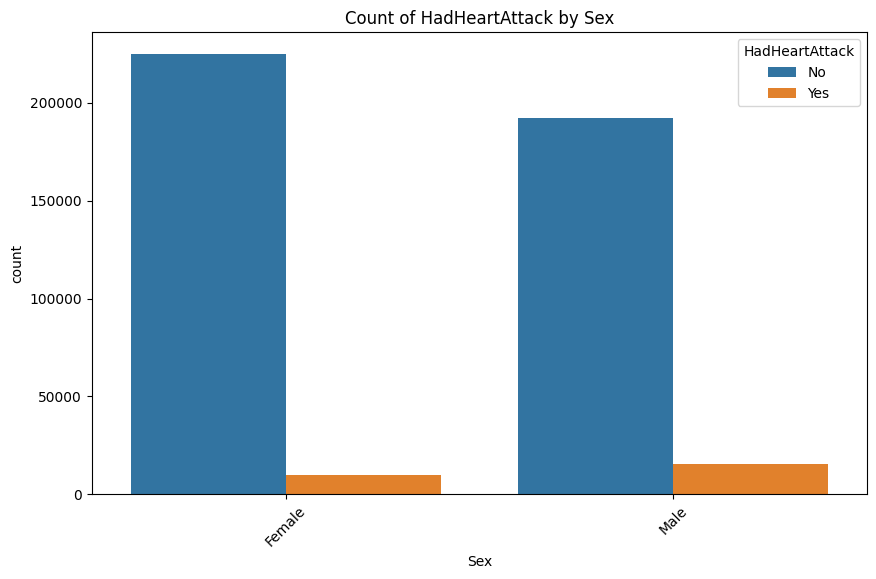

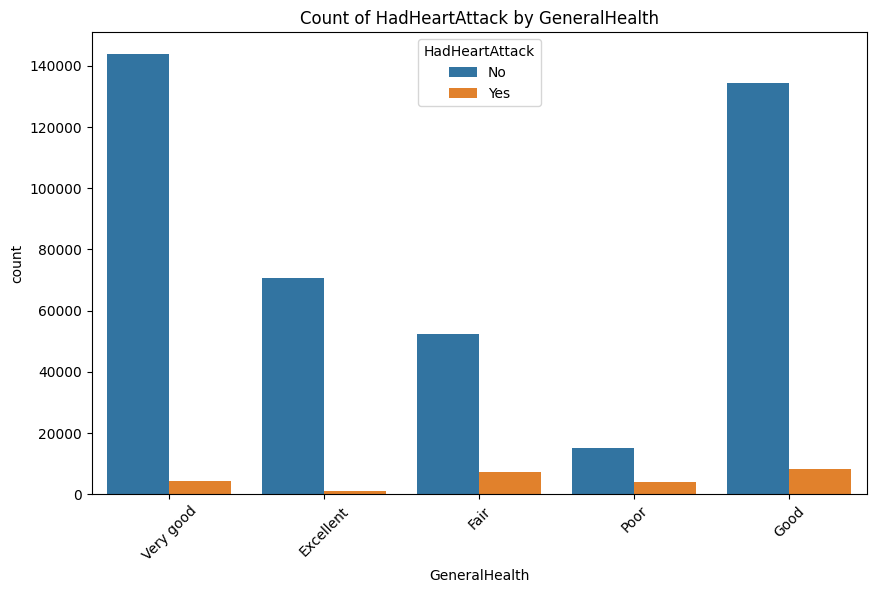

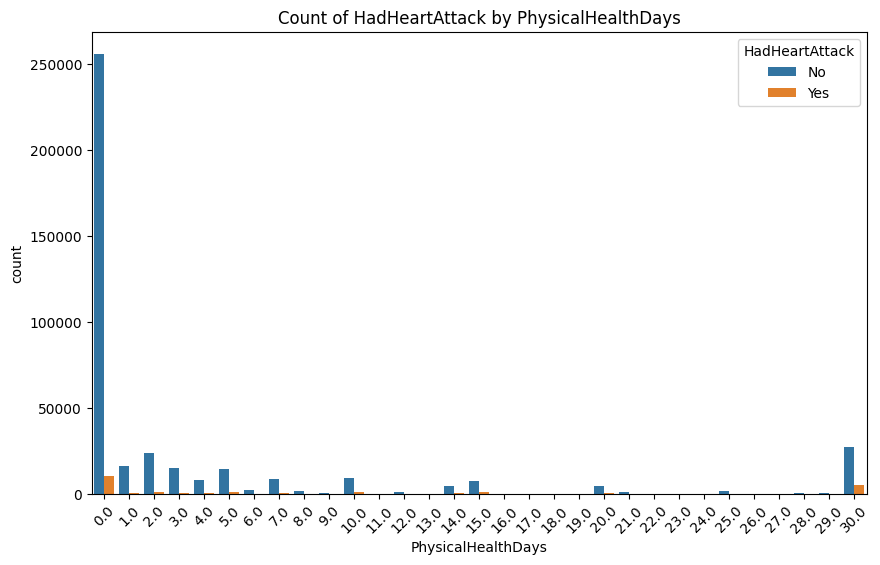

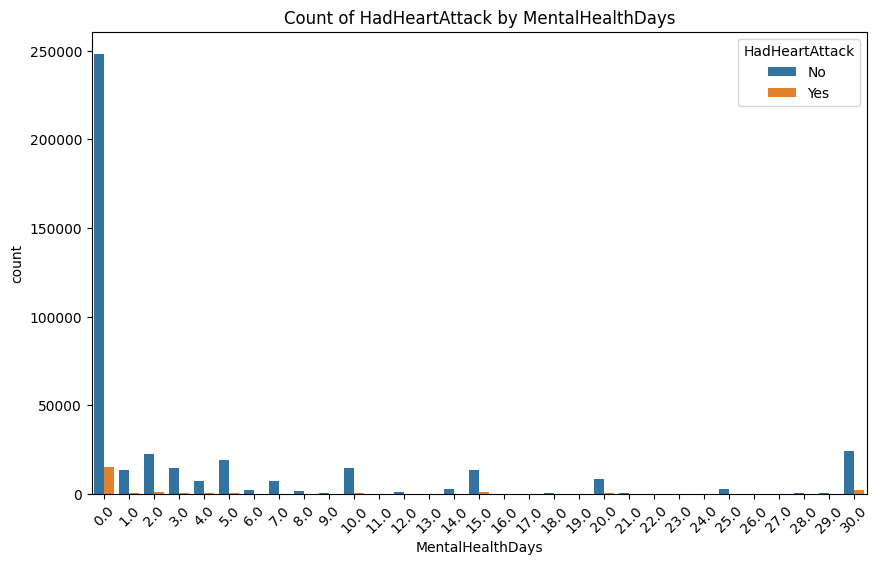

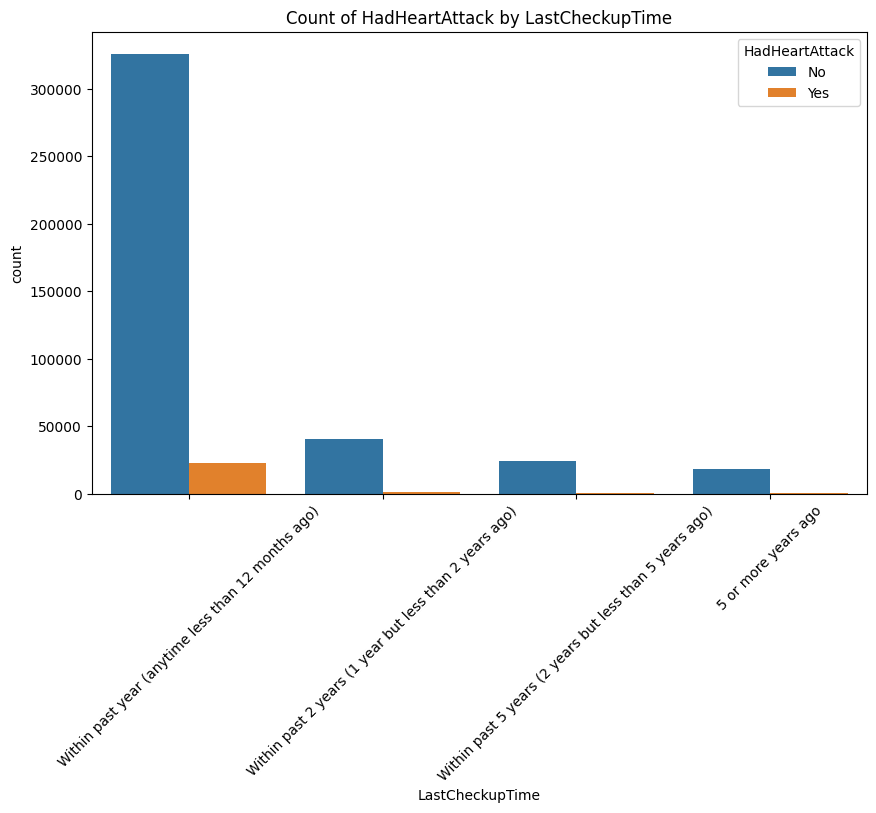

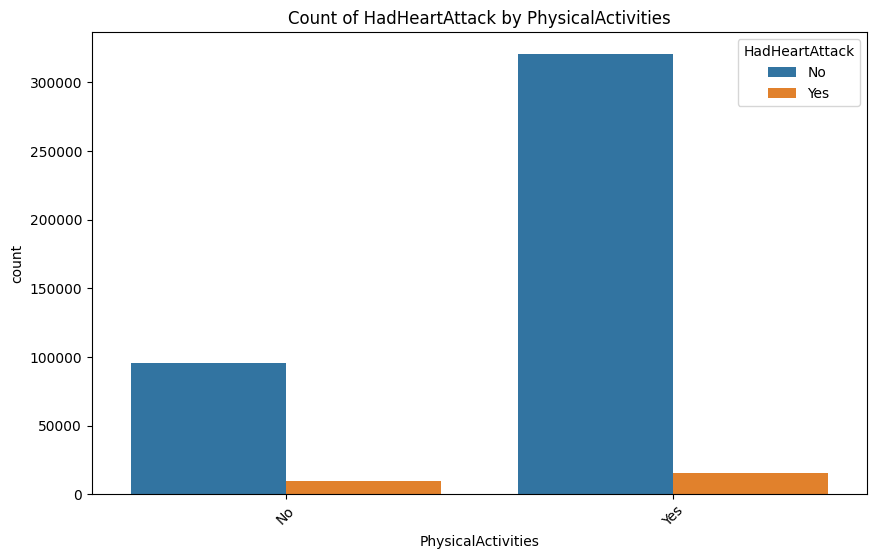

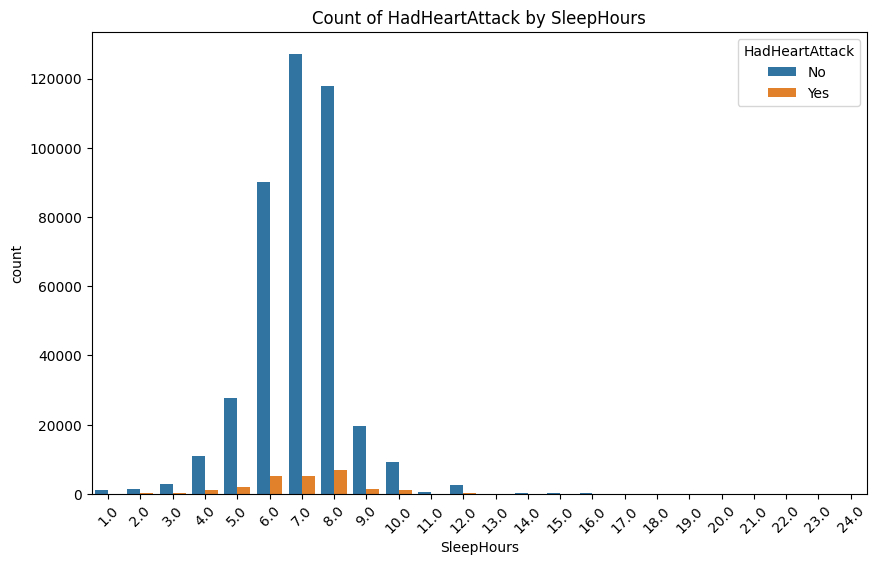

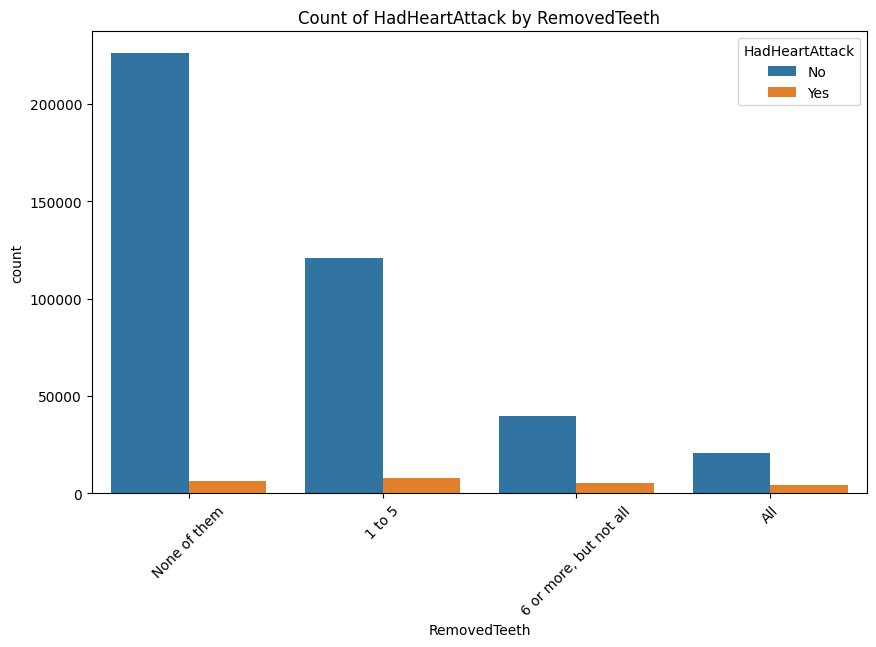

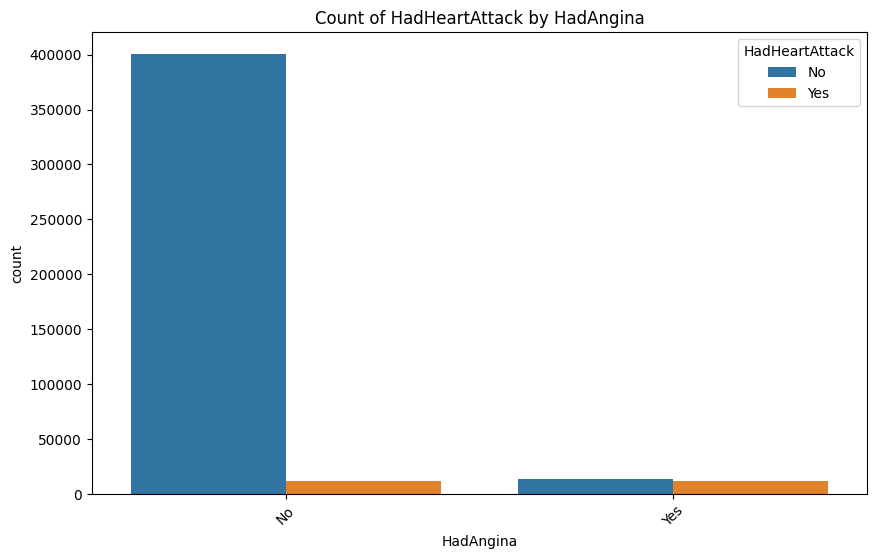

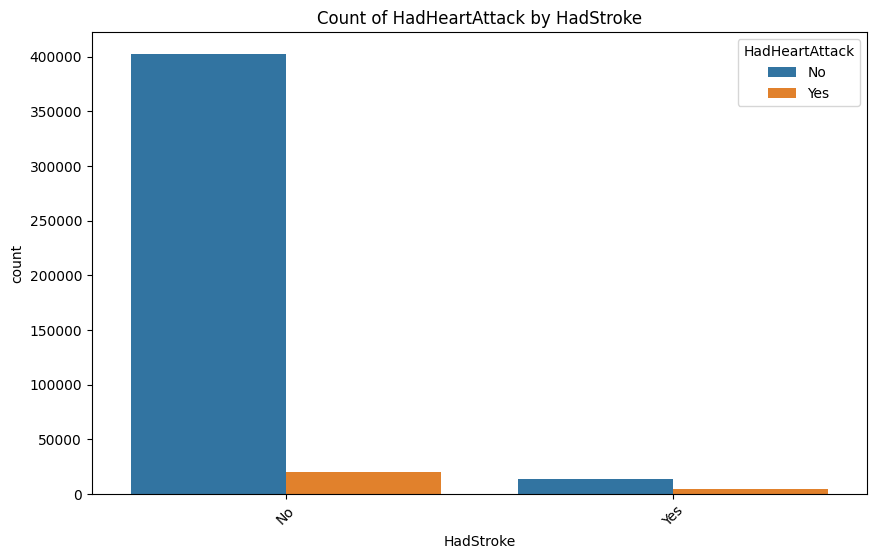

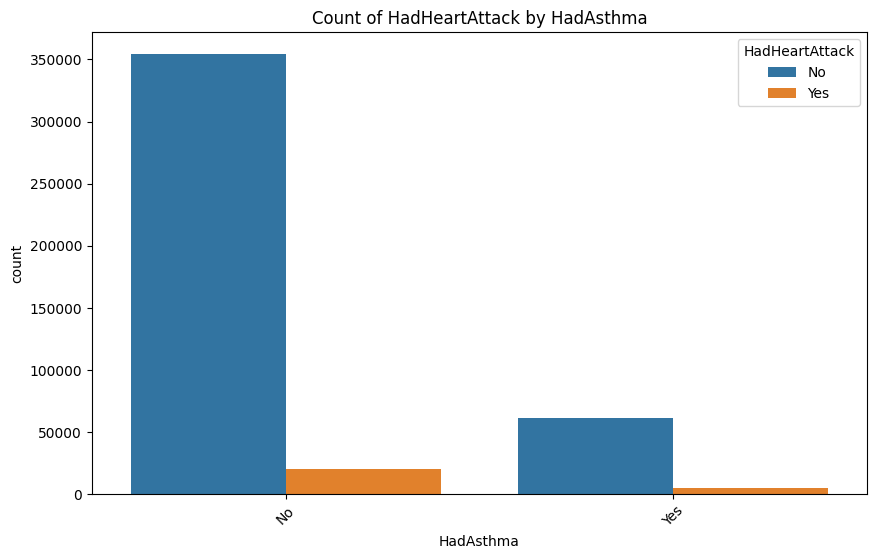

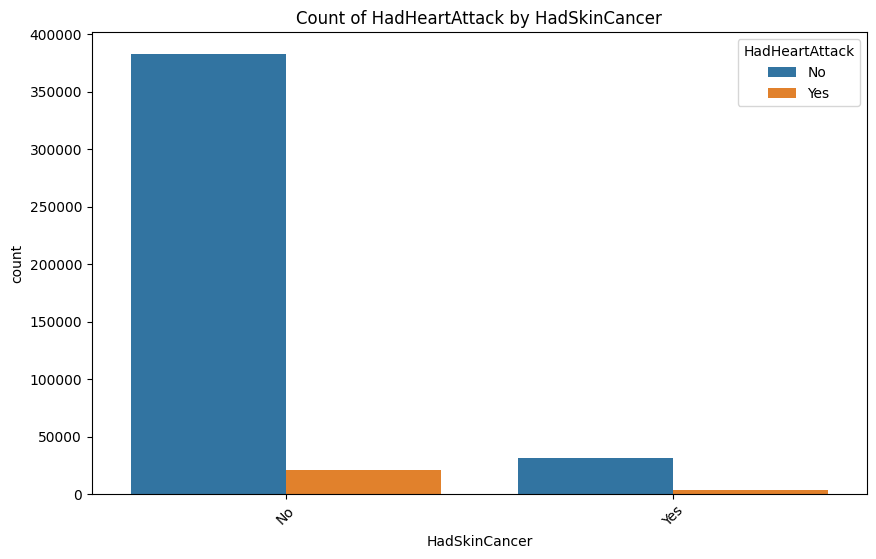

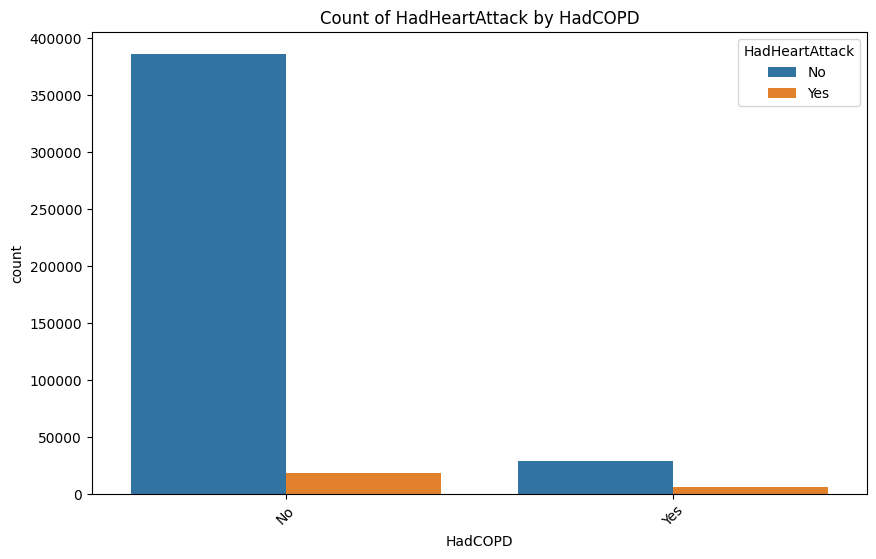

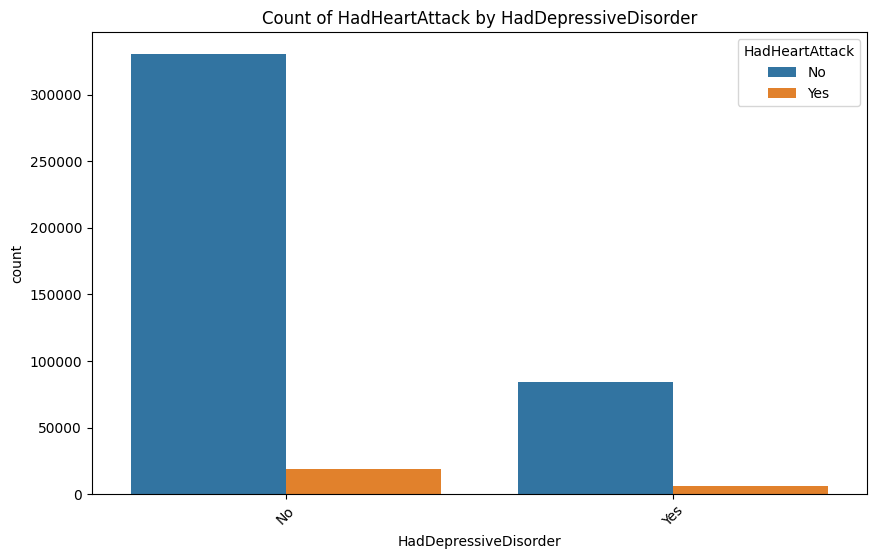

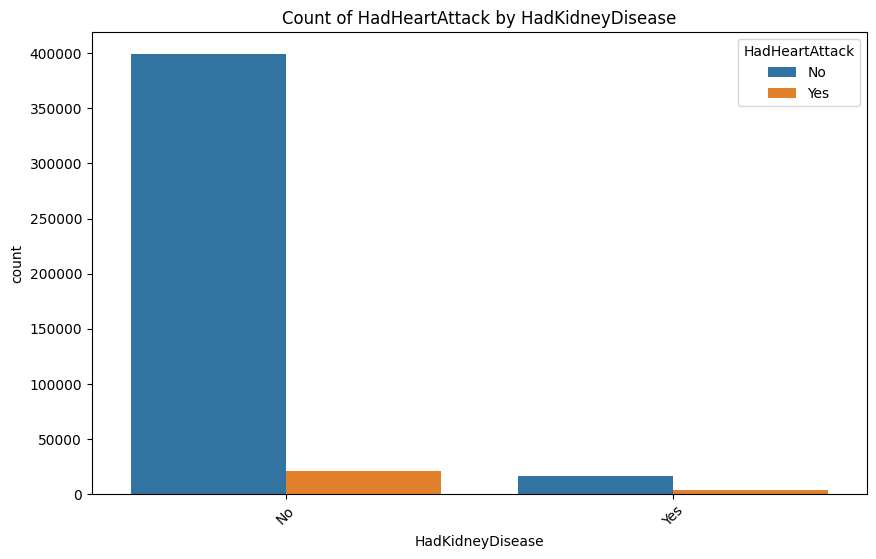

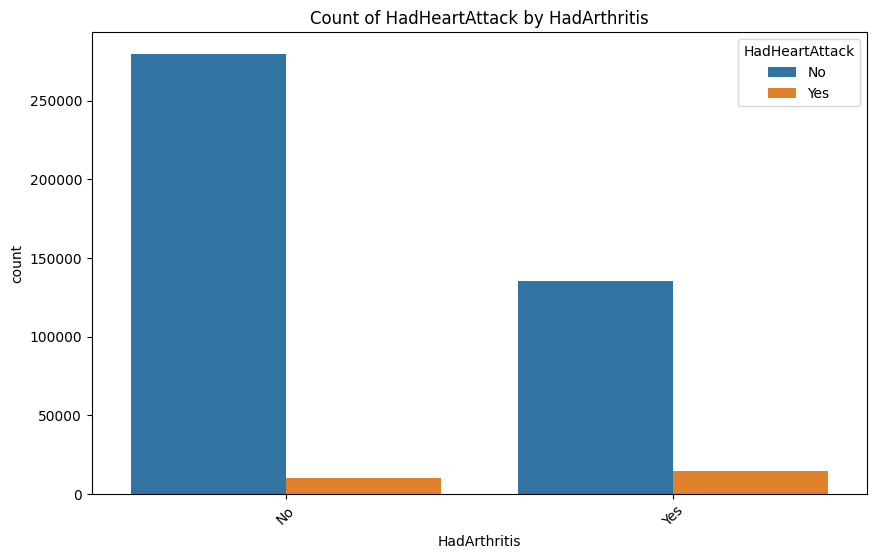

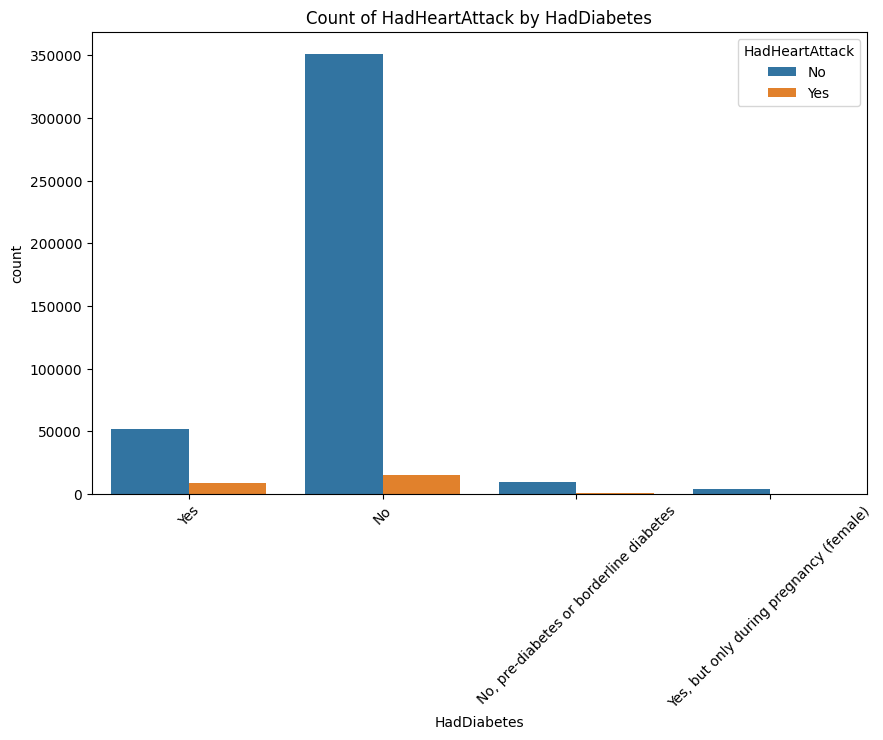

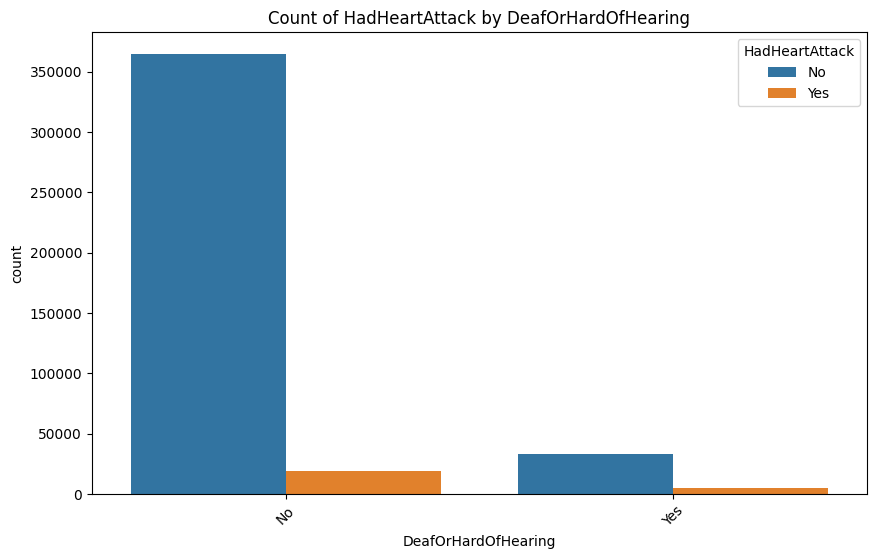

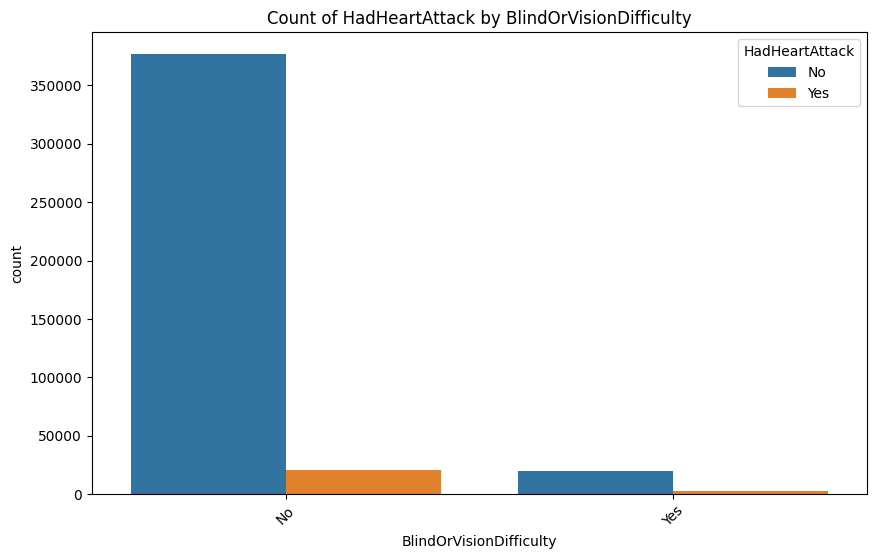

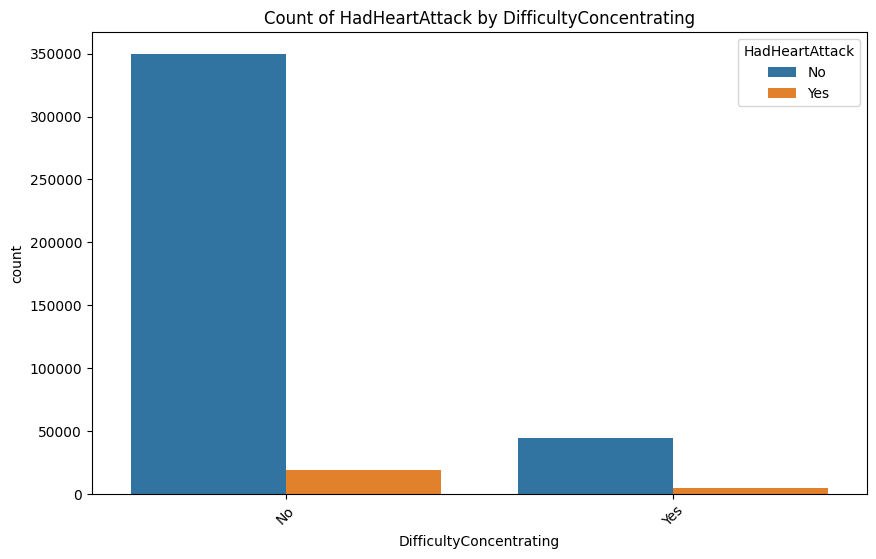

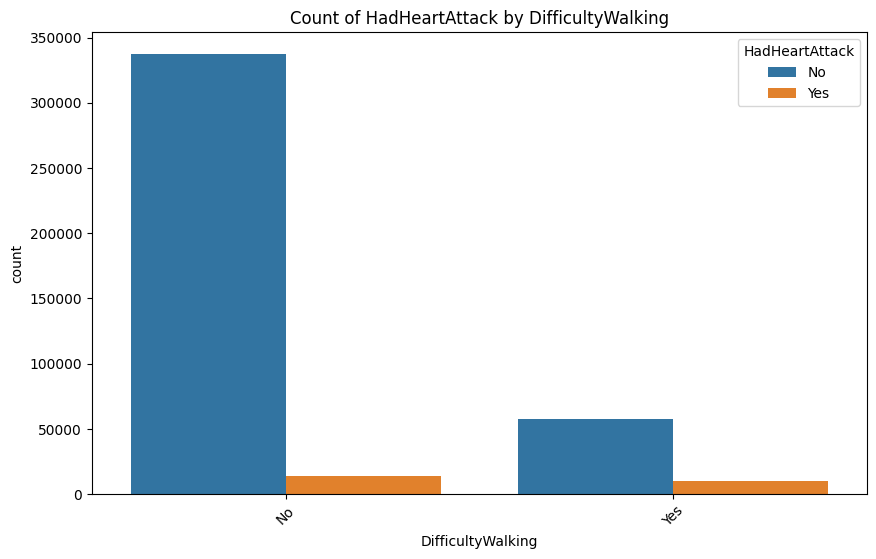

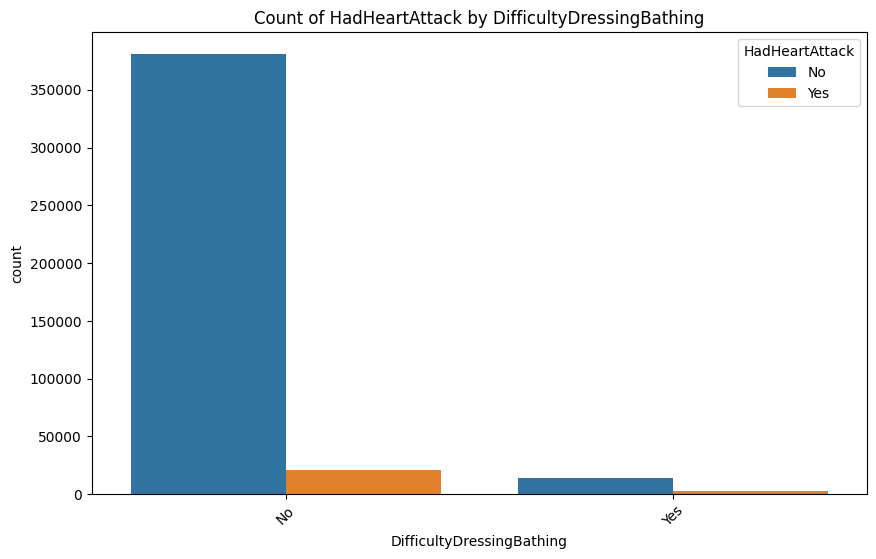

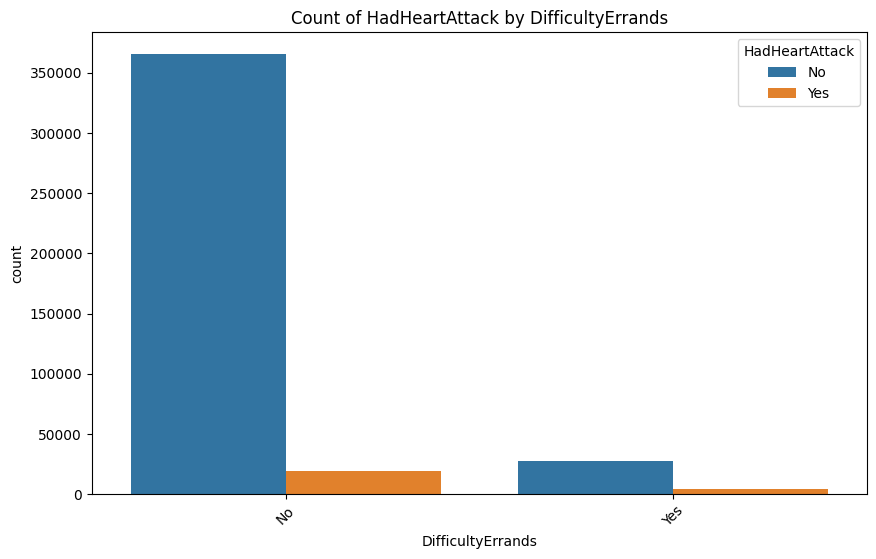

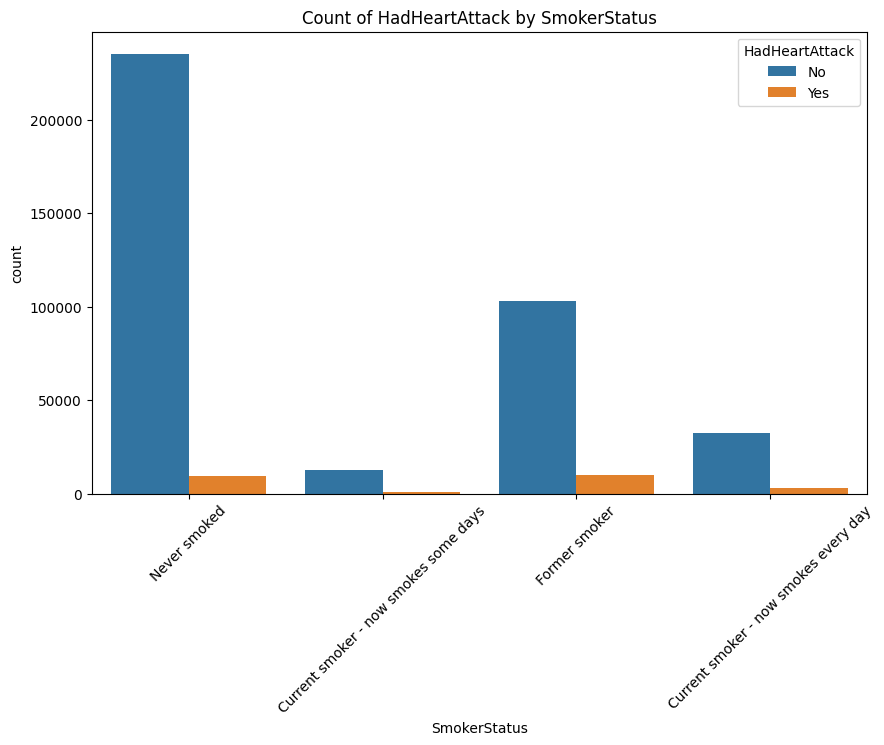

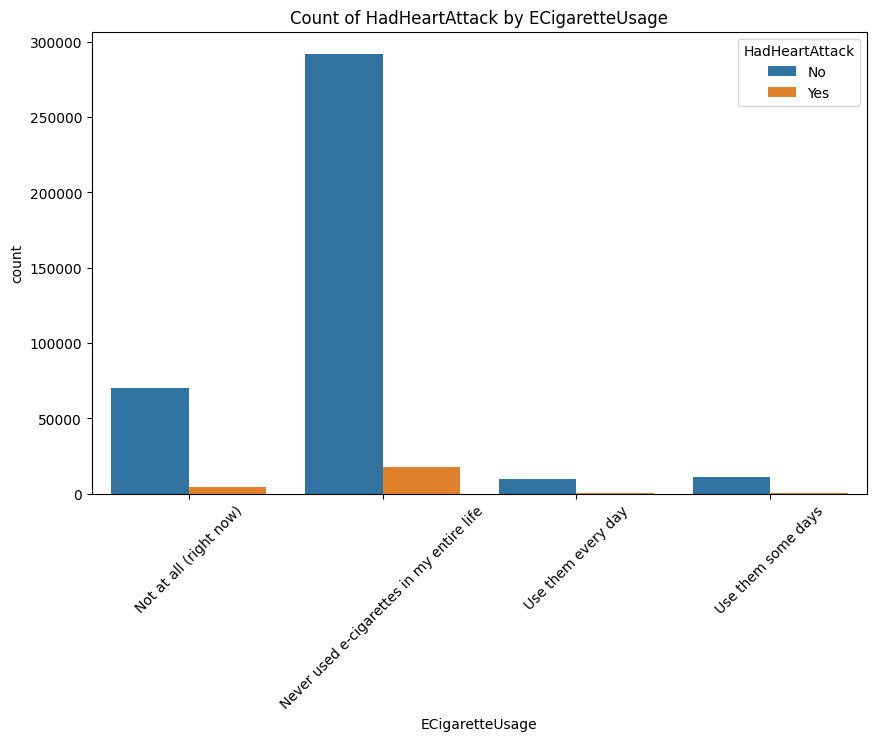

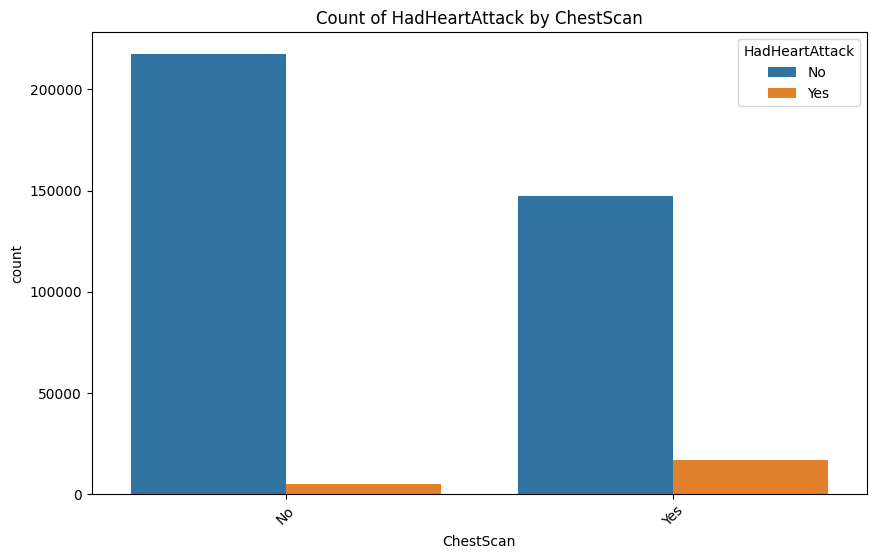

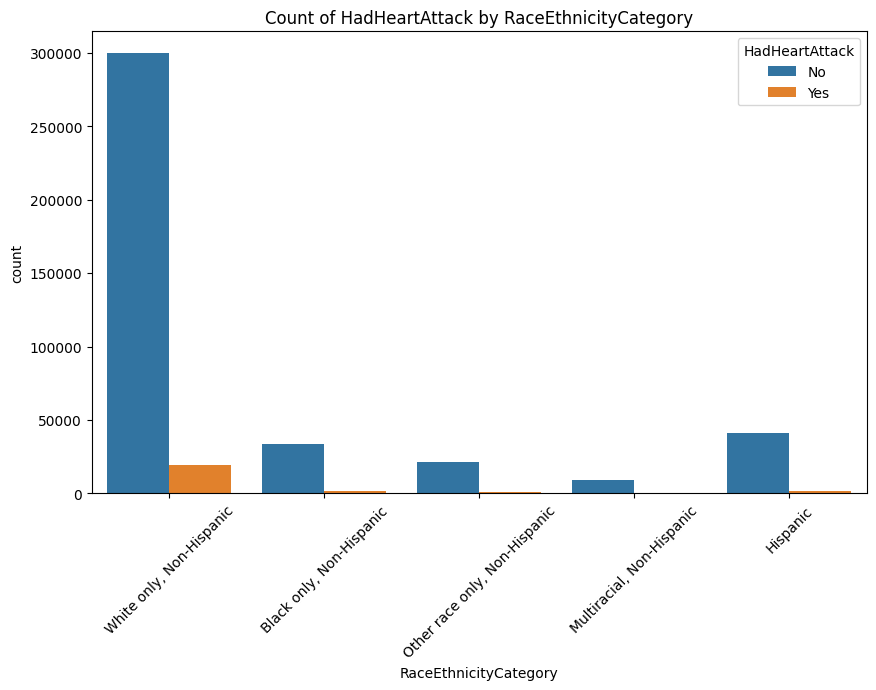

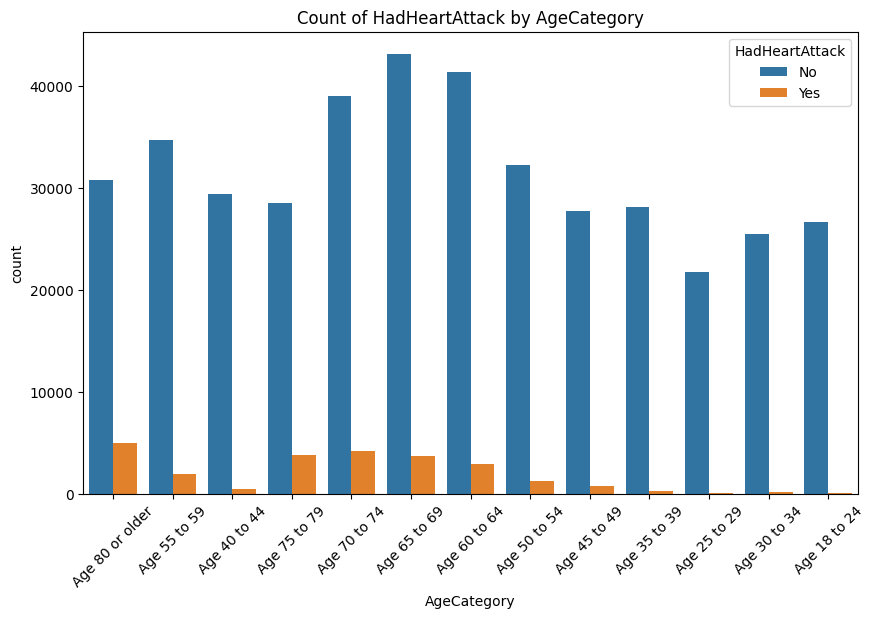

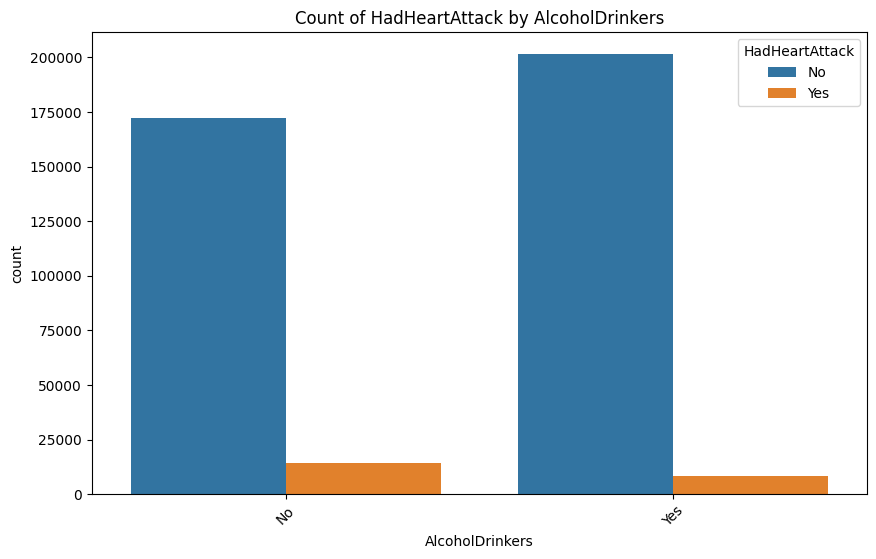

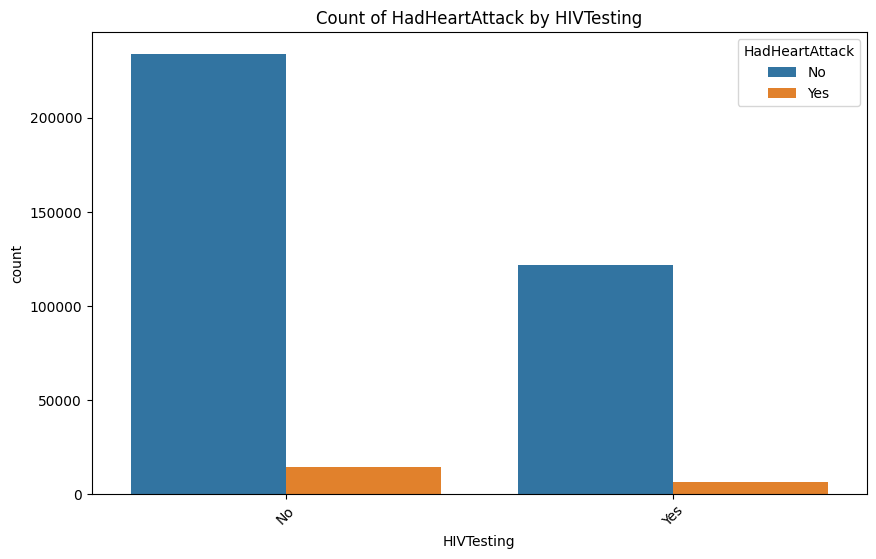

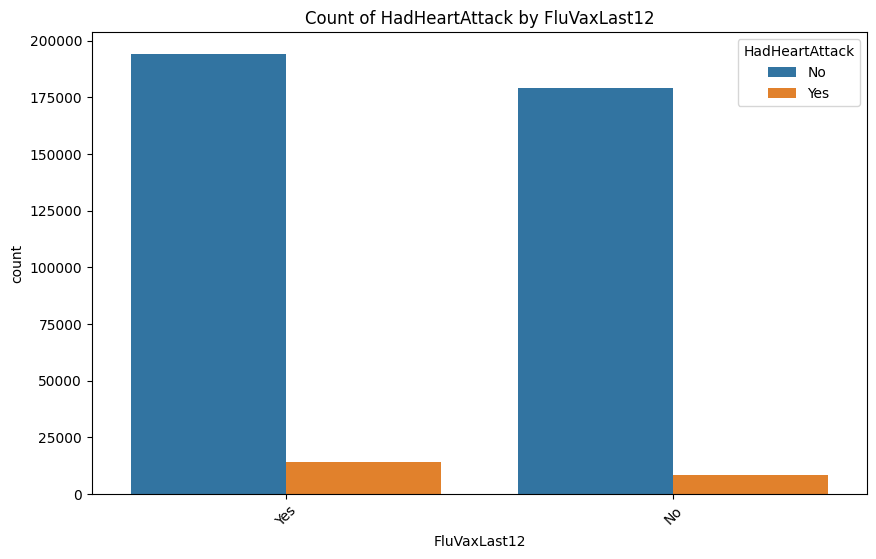

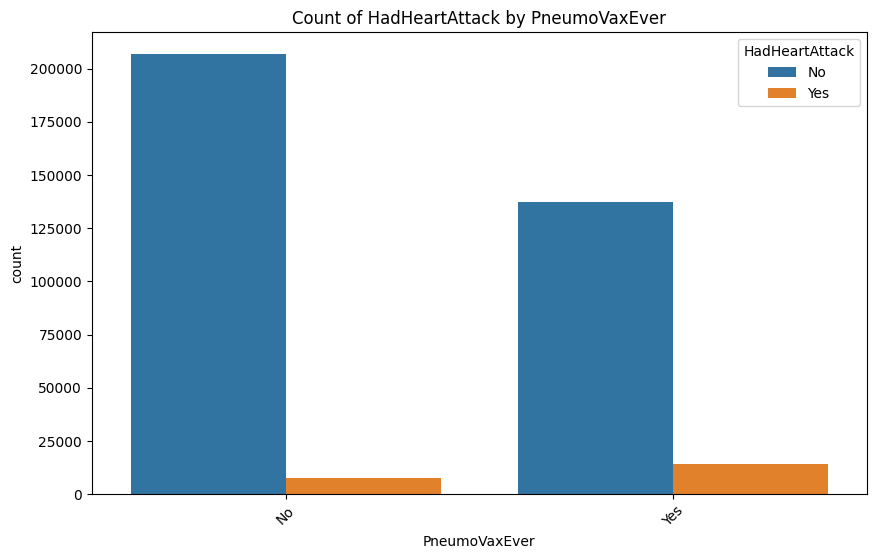

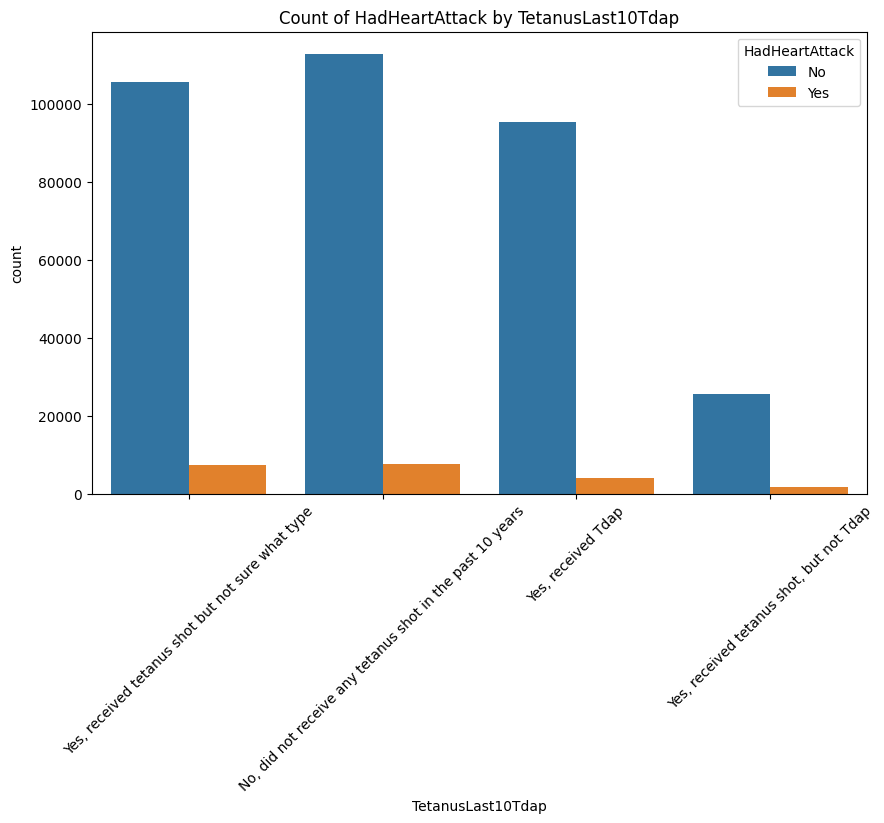

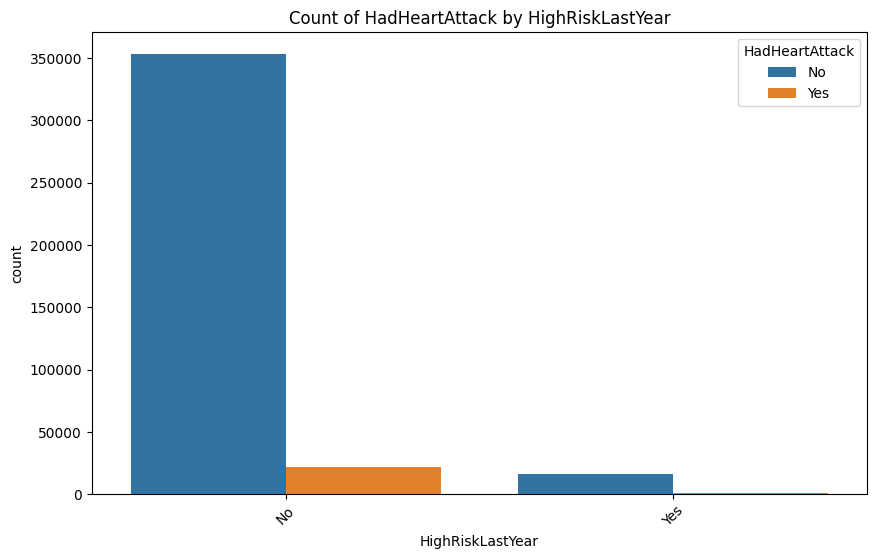

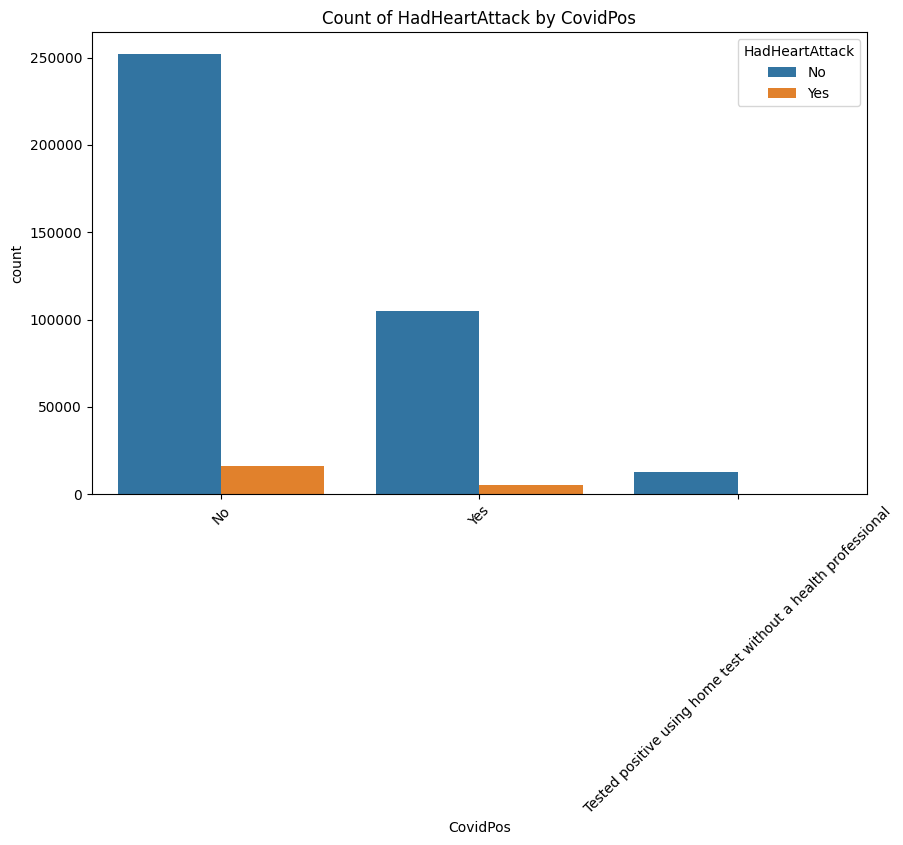

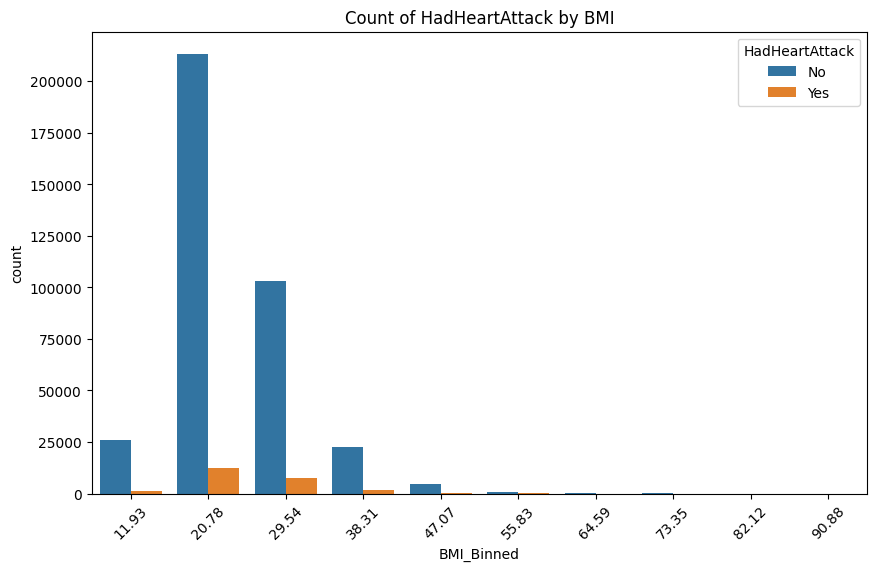

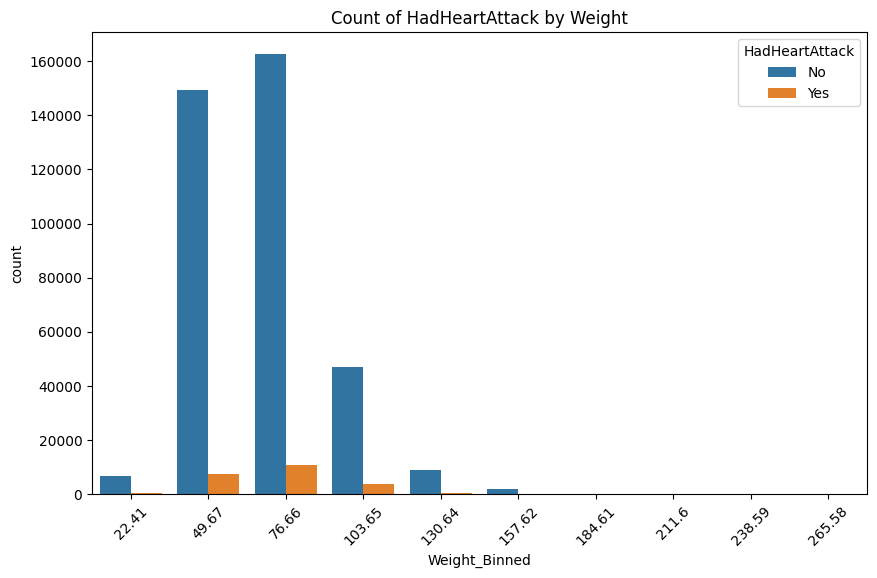

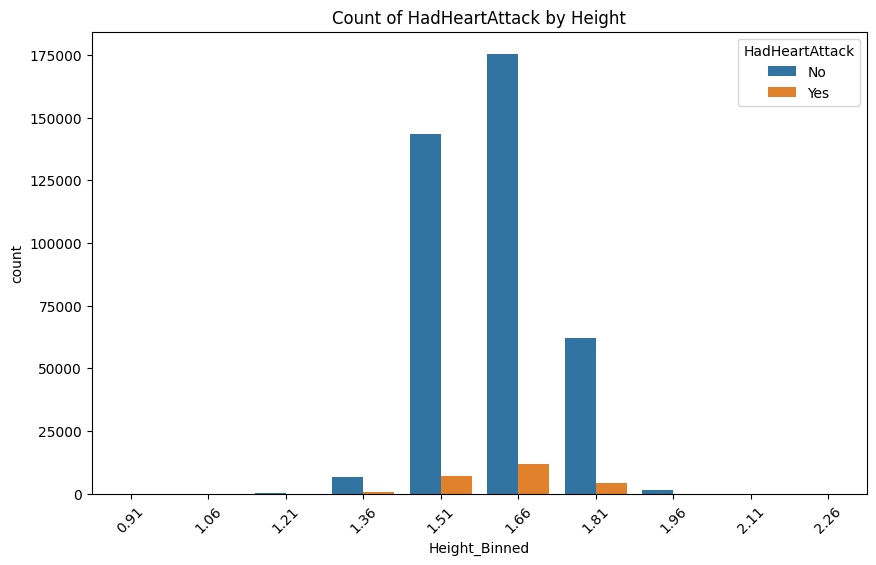

In [ ]:
# Il dataframe df originale non verrà usato per la fase di visualizzazione
# in quanto le modifiche andrebbero a pregiudicare i risultati finale della fase
# di pre-processing. Si è deciso dunque di creare una copia.

# Supponiamo che 'df' sia il DataFrame contenente il dataset

df_vis = df.copy()

# Creare intervalli per attributi continui
bins_bmi = pd.cut(df_vis['BMI'], bins=10)
bins_weight = pd.cut(df_vis['WeightInKilograms'], bins=10)
bins_height = pd.cut(df_vis['HeightInMeters'], bins=10)

# Creiamo nuove colonne con i valori binned
# Extract the left boundary of each interval and round it
df_vis['BMI_Binned'] = bins_bmi.apply(lambda x: round(x.left, 2) if not pd.isna(x) else x)
df_vis['Weight_Binned'] = bins_weight.apply(lambda x: round(x.left, 2) if not pd.isna(x) else x)
df_vis['Height_Binned'] = bins_height.apply(lambda x: round(x.left, 2) if not pd.isna(x) else x)

# Funzione per creare i grafici
def plot_attribute_counts(df, attribute, title):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=attribute, hue='HadHeartAttack')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

# Lista degli attributi
attributes = [
    'Sex', 'GeneralHealth', 'PhysicalHealthDays', 'MentalHealthDays',
    'LastCheckupTime', 'PhysicalActivities', 'SleepHours', 'RemovedTeeth',
    'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD',
    'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'HadDiabetes',
    'DeafOrHardOfHearing', 'BlindOrVisionDifficulty', 'DifficultyConcentrating',
    'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands',
    'SmokerStatus', 'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory',
    'AgeCategory', 'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver',
    'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos'
]

# Plot per tutti gli attributi categorici e gli attributi continui binned
for attribute in attributes:
    plot_attribute_counts(df_vis, attribute, f'Count of HadHeartAttack by {attribute}')

# Plot per gli attributi continui binned
plot_attribute_counts(df_vis, 'BMI_Binned', 'Count of HadHeartAttack by BMI')
plot_attribute_counts(df_vis, 'Weight_Binned', 'Count of HadHeartAttack by Weight')
plot_attribute_counts(df_vis, 'Height_Binned', 'Count of HadHeartAttack by Height')

## Pair plot graph

Successivamente ad una prima rappresentazione grafica si è deciso di esplorare e **scoprire eventuali correlazioni lineari** tra gli attributi numerici del dataset. Successivamente si utilizzerà la matrice di correlazione per confermare ulteriori certezze.

È stato preventivamente creato un sample del dataset la cui dimensione è pari al 10% della dimensione totale, in questo modo la gestione e la visualizzazione è stata notevolmente semplificata.

Si è scelto inoltre di utilizzare uno **Scatter Plot ** in quanto permette di individuare rapidamente correlazioni potenziali tra le variabili.

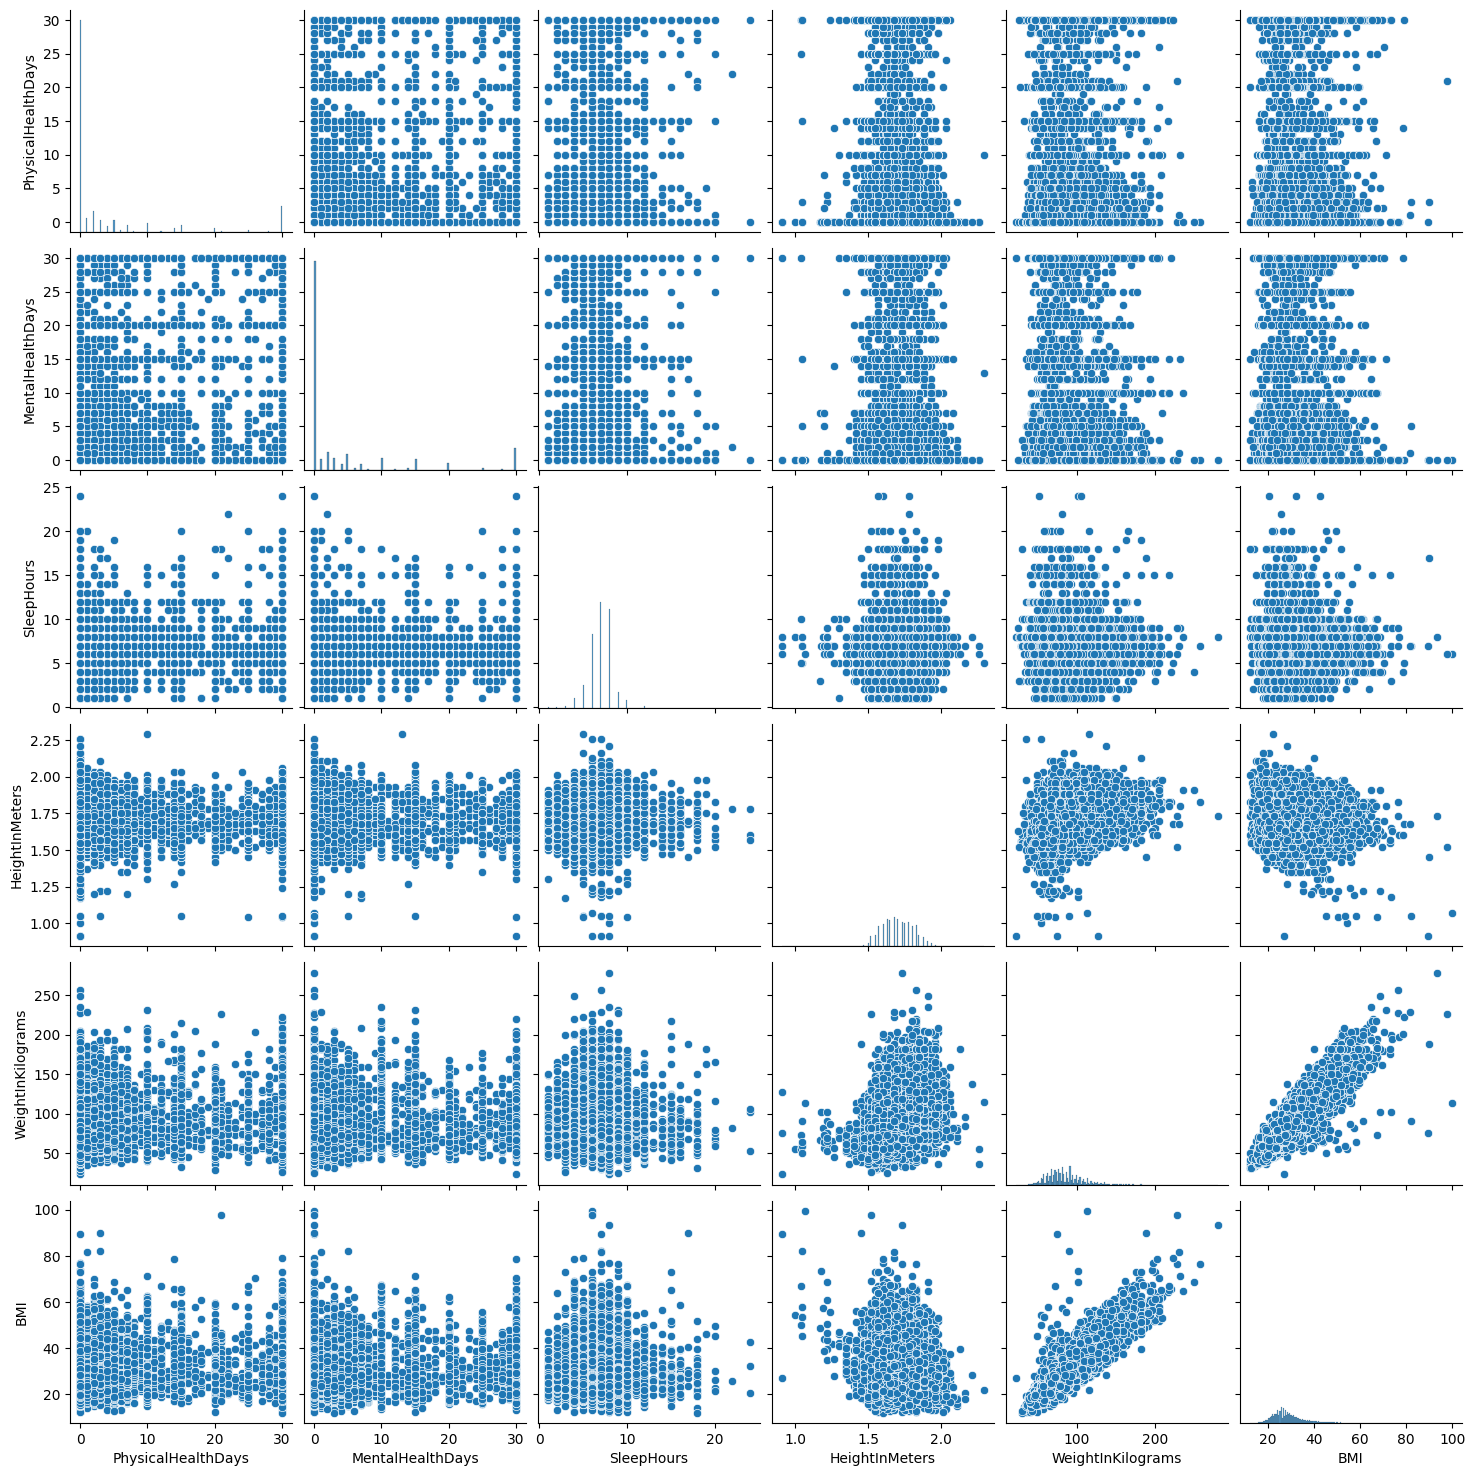

In [ ]:
# Prendere un campione del 10% del dataset (ad esempio)
sample_df = df.sample(frac=0.1, random_state=42)

# Lista degli attributi senza 'HadHeartAttack'
attributes = [
    'Sex', 'GeneralHealth', 'PhysicalHealthDays', 'MentalHealthDays',
    'LastCheckupTime', 'PhysicalActivities', 'SleepHours', 'RemovedTeeth',
    'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD',
    'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'HadDiabetes',
    'DeafOrHardOfHearing', 'BlindOrVisionDifficulty', 'DifficultyConcentrating',
    'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands',
    'SmokerStatus', 'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory',
    'AgeCategory', 'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver',
    'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos', 'HeightInMeters',
    'WeightInKilograms', 'BMI'
]

# Creare scatter plots utilizzando seaborn pairplot
sns.pairplot(sample_df[attributes])
plt.show()

A questo punto sotto ipotesi per la quale i **dataset medici** sono solitamente **molto** **sbilanciati** si è fatto un ulteriore controllo considerando e **contando** unicamente le istanze il cui valore di **HadHeartAttack = "No"** e quelle il cui valore di **HedHeartAttack = "Si"**.

Numero di righe con HadHeartAttack='No': 416959 (93.67%)
Numero di righe con HadHeartAttack='Yes': 25108 (5.64%)
Numero di righe con HadHeartAttack = NaN: 3065 (0.69%)


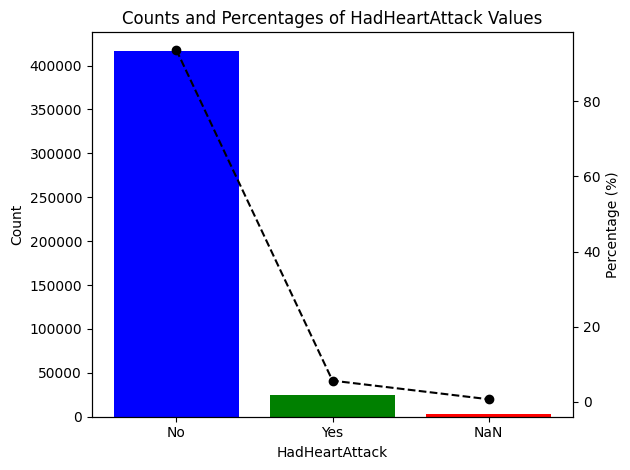

In [ ]:
# Conta il numero di righe per ciascun valore di HadHeartAttack
count_no = df[df['HadHeartAttack'] == 'No'].shape[0]
count_si = df[df['HadHeartAttack'] == 'Yes'].shape[0]

# Calcola la percentuale di righe per ciascun valore di HadHeartAttack
total_rows = df.shape[0]
percentage_no = (count_no / total_rows) * 100
percentage_si = (count_si / total_rows) * 100

# Conto il numero totale di righe con valori NaN per la colonna 'HadHeartAttack'
total_nan_rows = df[df['HadHeartAttack'].isnull()].shape[0]
percentage_nan = (total_nan_rows / total_rows) * 100

print(f"Numero di righe con HadHeartAttack='No': {count_no} ({percentage_no:.2f}%)")
print(f"Numero di righe con HadHeartAttack='Yes': {count_si} ({percentage_si:.2f}%)")

# Visualizzo il numero totale di righe con valori NaN per la colonna 'HadHeartAttack'
print(f"Numero di righe con HadHeartAttack = NaN: {total_nan_rows} ({percentage_nan:.2f}%)")

# Prepara i dati per il plot
labels = ['No', 'Yes', 'NaN']
counts = [count_no, count_si, total_nan_rows]
percentages = [percentage_no, percentage_si, percentage_nan]

# Crea il bar chart
fig, ax1 = plt.subplots()

# Grafico del numero di istanze
ax1.bar(labels, counts, color=['blue', 'green', 'red'])
ax1.set_xlabel('HadHeartAttack')
ax1.set_ylabel('Count', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Aggiungi un secondo asse y per le percentuali
ax2 = ax1.twinx()
ax2.plot(labels, percentages, color='black', marker='o', linestyle='dashed')
ax2.set_ylabel('Percentage (%)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Titolo e layout
plt.title('Counts and Percentages of HadHeartAttack Values')
fig.tight_layout()

# Mostra il grafico
plt.show()

L'**ipotesi** era **corretta**, il dataset è fortemente sbilanciato. In particolare sussiste una percentuale del **93.67%** di istanze con valore di **HadHeartAttack='No'** e **5.64%** di istanze con valore di **HadHeartAttack='Yes'**. Sicché la somma delle due percentuali è pari a 99.31% allora è presente lo 0.69% di righe con valore di HadHeartAttack = NaN, data la loro presenza quantitativamente poco significativa si è prenderà successivamente la decisione di eliminarle completamente.

## Eliminazione duplicati e NaN

Si **eliminano** inoltre eventuali **istanze duplicate**:

In [ ]:
# Calcolo quante sono le istanze duplicate
df.duplicated().sum()

# Cancellazione e ricalcolo della shape complessiva
df = df.drop_duplicates()
print(df.shape)

(444975, 40)


Ci si concentra ora sulla **valutazione** di eventuali **istanze null** presenti:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 444975 entries, 0 to 445131
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      444975 non-null  object 
 1   Sex                        444975 non-null  object 
 2   GeneralHealth              443782 non-null  object 
 3   PhysicalHealthDays         434053 non-null  float64
 4   MentalHealthDays           435913 non-null  float64
 5   LastCheckupTime            436674 non-null  object 
 6   PhysicalActivities         443887 non-null  object 
 7   SleepHours                 439527 non-null  float64
 8   RemovedTeeth               433620 non-null  object 
 9   HadHeartAttack             441915 non-null  object 
 10  HadAngina                  440575 non-null  object 
 11  HadStroke                  443423 non-null  object 
 12  HadAsthma                  443207 non-null  object 
 13  HadSkinCancer              441837 

È intuibile la presenza di molte istanze del dataset con valori NaN tra le features. Cerchiamo adesso di **calcolarne** la **percentuale**:


TetanusLast10Tdap            18.511152
PneumoVaxEver                17.280521
HIVTesting                   14.828024
ChestScan                    12.562504
CovidPos                     11.375471
HighRiskLastYear             11.343783
BMI                          10.935221
FluVaxLast12                 10.556773
AlcoholDrinkers              10.433845
WeightInKilograms             9.423226
ECigaretteUsage               7.981123
SmokerStatus                  7.936626
HeightInMeters                6.405978
DifficultyErrands             5.733131
DifficultyConcentrating       5.414911
DifficultyWalking             5.363672
DifficultyDressingBathing     5.341873
BlindOrVisionDifficulty       4.813529
DeafOrHardOfHearing           4.607450
RaceEthnicityCategory         3.157031
RemovedTeeth                  2.551829
PhysicalHealthDays            2.454520
AgeCategory                   2.038092
MentalHealthDays              2.036519
LastCheckupTime               1.865498
SleepHours               

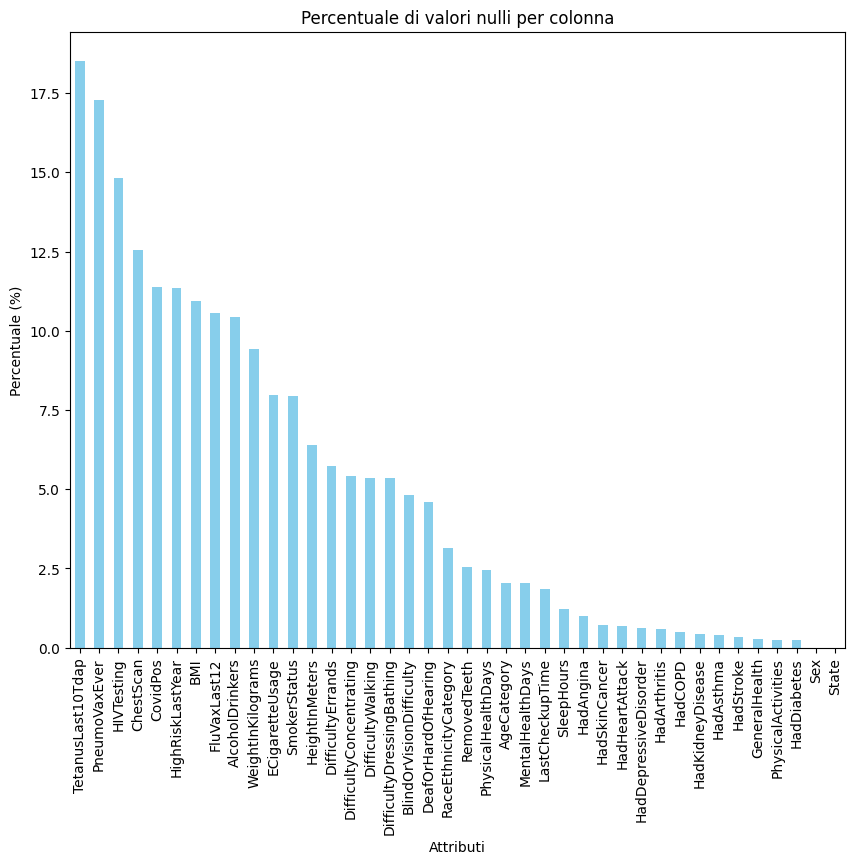

In [ ]:
#print(df.isnull().sum())

def percentualeNan(X):
    # Calcola la percentuale di valori nulli per ogni colonna
    percent_missing = X.isnull().mean() * 100
    percent_missing_sorted = percent_missing.sort_values(ascending=False)

    # Visualizza la percentuale di valori nulli per ogni colonna
    print(percent_missing_sorted)

    # Plotta la percentuale di valori nulli
    fig, ax = plt.subplots(figsize=(10, 8))
    percent_missing_sorted.plot(kind='bar', ax=ax, color='skyblue')
    ax.set_title('Percentuale di valori nulli per colonna')
    ax.set_ylabel('Percentuale (%)')
    ax.set_xlabel('Attributi')
    plt.xticks(rotation=90)  # Ruota le etichette degli attributi per migliorare la leggibilità
    plt.show()

# Esegui la funzione
percentualeNan(df)

Si è **calcolato** inoltre il numero **totale** di **istanze** che possiedono **almeno un valore NaN** presente come percentuale rispetto al totale:





Percentuale di righe con almeno un valore NaN: 44.71%, in totale: 198962/444975.


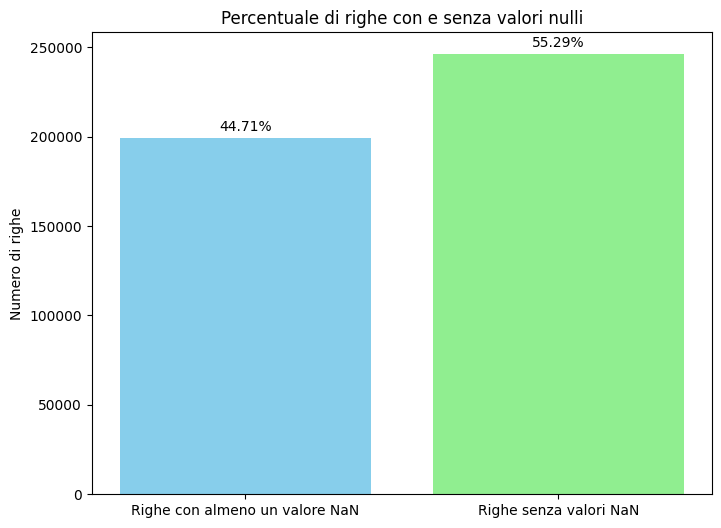

In [ ]:
def percentualeRigheConNull(X):
    # Calcola il numero di righe con almeno un valore null
    rows_with_null = X.isnull().any(axis=1).sum()
    tot_rows = X.shape[0]

    # Calcola la percentuale di righe con almeno un valore null
    percentage_rows_with_null = (rows_with_null / tot_rows) * 100

    print(f"Percentuale di righe con almeno un valore NaN: {percentage_rows_with_null:.2f}%, in totale: {rows_with_null}/{tot_rows}.")

    # Prepara i dati per il grafico a barre
    data = {'Righe con almeno un valore NaN': rows_with_null, 'Righe senza valori NaN': tot_rows - rows_with_null}
    labels = list(data.keys())
    values = list(data.values())
    percentages = [percentage_rows_with_null, 100 - percentage_rows_with_null]

    # Crea il grafico a barre
    fig, ax = plt.subplots(figsize=(8, 6))
    bars = ax.bar(labels, values, color=['skyblue', 'lightgreen'])

    # Aggiungi percentuali sulle barre
    for bar, percentage in zip(bars, percentages):
        height = bar.get_height()
        ax.annotate(f'{percentage:.2f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

    ax.set_title('Percentuale di righe con e senza valori nulli')
    ax.set_ylabel('Numero di righe')
    plt.show()

# Esegui la funzione
percentualeRigheConNull(df)


Si noti dunque una percentuale consistente di istanze del dataset con almeno un valore NaN.

La **decisione** presa in queste circostanze riguarda l'**eliminazione di tutte le istanze contenenti valori NaN** dal nostro dataset che, come visto inizialmente, conta quasi 500.000 istanze.

Questa scelta è motivata dalla necessità di avere un dataset pulito per effettuare un'analisi preliminare accurata e priva di distorsioni dovute ai dati mancanti.

**Tuttavia, per mantenere un approccio rigoroso e completo, abbiamo conservato una copia del dataset originale con i valori NaN. In una fase successiva del progetto, andremo ad applicare tecniche di imputazione dei dati mancanti per confrontare i risultati ottenuti con quelli derivanti dall'analisi del dataset senza NaN.**

Questo confronto ci permetterà di verificare se la rimozione dei dati mancanti ha avuto un impatto significativo sui risultati e se, eventualmente, l'imputazione dei NaN potrebbe offrire un'analisi più completa e accurata.

In [ ]:
df_withNanCopy =  df.copy()

#Visualizza il numero di istanze prima dell'eliminazione
print("Numero di righe originali:", df.shape[0])

#visualizza il numero di istanze che possiede almeno un nan
print("Numero di istanze che possiedono valori Nan :",df.isnull().any(axis=1).sum())

df=df.dropna()
print("Numero istanze senza valori Nan :", df.shape[0])

Numero di righe originali: 444975
Numero di istanze che possiedono valori Nan : 198962
Numero istanze senza valori Nan : 246013


**N.B**: tra le istanze eliminate sono presenti anche quelle tali per cui HadHeartAttack = NaN, in numero pari a 3065.

Di seguito la dimostrazione che il dataset è stato completamente depurato dai valori NaN:

State                        0.0
Sex                          0.0
DifficultyWalking            0.0
DifficultyDressingBathing    0.0
DifficultyErrands            0.0
SmokerStatus                 0.0
ECigaretteUsage              0.0
ChestScan                    0.0
RaceEthnicityCategory        0.0
AgeCategory                  0.0
HeightInMeters               0.0
WeightInKilograms            0.0
BMI                          0.0
AlcoholDrinkers              0.0
HIVTesting                   0.0
FluVaxLast12                 0.0
PneumoVaxEver                0.0
TetanusLast10Tdap            0.0
HighRiskLastYear             0.0
DifficultyConcentrating      0.0
BlindOrVisionDifficulty      0.0
DeafOrHardOfHearing          0.0
HadHeartAttack               0.0
GeneralHealth                0.0
PhysicalHealthDays           0.0
MentalHealthDays             0.0
LastCheckupTime              0.0
PhysicalActivities           0.0
SleepHours                   0.0
RemovedTeeth                 0.0
HadAngina 

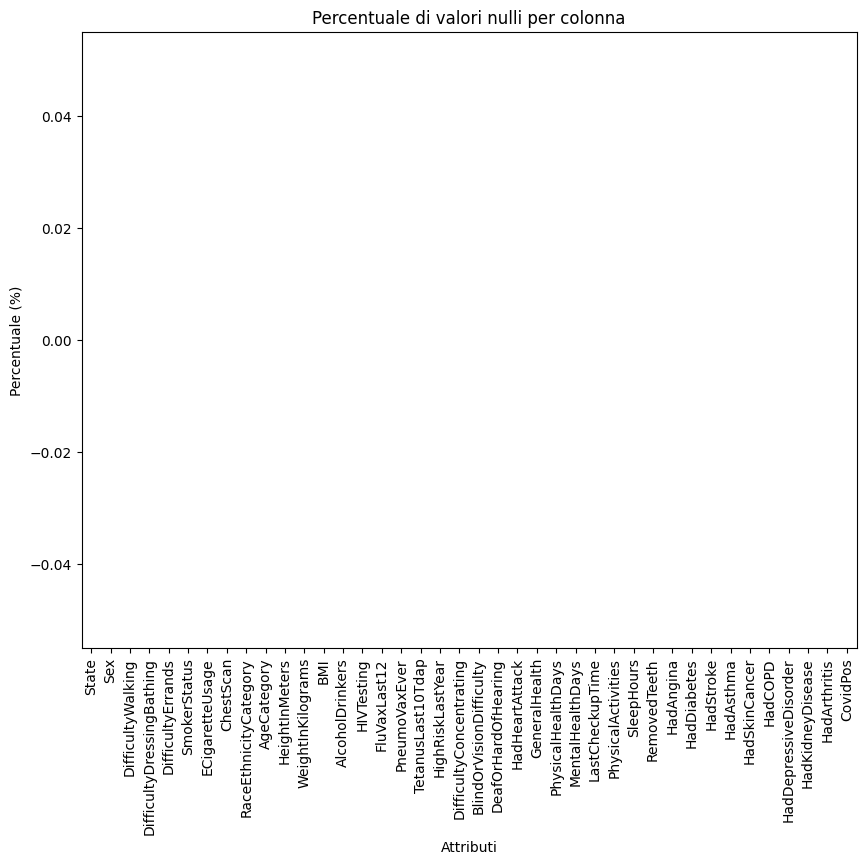

In [ ]:
percentualeNan(df)

# CheckPoint di salvataggio

Salviamo una copia attuale del dataset separando la variabile dipendente, vale a dire l'attributo di classe dal resto delle features.

In [ ]:
X = df.drop(columns= ['HadHeartAttack'])

Y = df['HadHeartAttack']

print(df.shape)

(246013, 40)


# Pre-processing

Terminata la prima fase di pre-analisi possiamo è possibile passare alla fase successiva di **pre-processing** in cui verranno **valutate** eventuali **decisioni** riguardo **codifica di variabili**, **standardizzazione** o altre trasformazioni.

Si tratta di una fase fondamentale nell'intero processo in quanto, se fatta con criterio, permette di ottenere dati di alta qualità che permetteranno poi di eseguire una fase di analisi e classificazione più precisa possibile.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 246013 entries, 342 to 445130
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      246013 non-null  object 
 1   Sex                        246013 non-null  object 
 2   GeneralHealth              246013 non-null  object 
 3   PhysicalHealthDays         246013 non-null  float64
 4   MentalHealthDays           246013 non-null  float64
 5   LastCheckupTime            246013 non-null  object 
 6   PhysicalActivities         246013 non-null  object 
 7   SleepHours                 246013 non-null  float64
 8   RemovedTeeth               246013 non-null  object 
 9   HadHeartAttack             246013 non-null  object 
 10  HadAngina                  246013 non-null  object 
 11  HadStroke                  246013 non-null  object 
 12  HadAsthma                  246013 non-null  object 
 13  HadSkinCancer              24601

Per prima cosa viene **analizzato**, per ogni attributo, il numero **totale** di **occorrenze** di ogni singolo **valore** che tale **attributo** può assumere:


In [ ]:
# Selezionare colonne di tipo object
object_columns = df.select_dtypes(include=['object'])

# Stampare i valori unici e il loro conteggio per ogni colonna object
for col in object_columns.columns:
    value_counts = object_columns[col].value_counts()
    print(f"Colonna '{col}':\n{value_counts}\nNumero di valori unici: {len(value_counts)}\n")

Colonna 'State':
State
Washington              14998
Maryland                 9163
Minnesota                9161
Ohio                     8995
New York                 8923
Texas                    7408
Florida                  7315
Kansas                   6145
Wisconsin                6126
Maine                    6013
Iowa                     5672
Hawaii                   5596
Virginia                 5565
Indiana                  5502
South Carolina           5471
Massachusetts            5465
Arizona                  5461
Utah                     5373
Michigan                 5370
Colorado                 5159
Nebraska                 5107
California               5096
Connecticut              5053
Georgia                  4978
Vermont                  4844
South Dakota             4404
Montana                  4264
Missouri                 4195
New Jersey               3966
New Hampshire            3756
Puerto Rico              3589
Idaho                    3468
Alaska           

## Sostituzione di valori per l'attributo "CovidPos"

Dai risultati precedenti si è riscontrato per l'attributo **"CovidPos"** un valore particolare: **'Tested positive using home test without a health professional'**: sebbene il contesto possa influire sulla certezza del risultato, questo valore implica comunque un risultato positivo.

Considerare questo valore come un positivo può essere ragionevole se il test casalingo è generalmente considerato affidabile.

Percio andiamo a sostituire questo risultato con 'Yes' , in modo tale da semplificare le analisi successive.

In [ ]:
df['CovidPos'] = df['CovidPos'].replace('Tested positive using home test without a health professional', 'Yes')
value_counts = df['CovidPos'].value_counts(dropna=False)
print(value_counts)

CovidPos
No     167297
Yes     78716
Name: count, dtype: int64


## Trasformazione per l'attributo "HadDiabetes"

Per quanto riguarda l'attributo "**HadDiabetes**" si è deciso di sostituire il valore '**Yes, but only during pregnancy (female)**' con '**No**'.

La ragione di questa scelta è che il diabete gestazionale, pur essendo una forma di diabete, è temporaneo e si manifesta solo durante la gravidanza. Considerando la natura temporanea e specifica di questa condizione, abbiamo deciso di trattarla come un'assenza di diabete nel contesto generale dell'analisi.

Questo ha aiutato a mantenere una distinzione chiara tra i casi di diabete cronico e temporaneo, facilitando così interpretazioni più precise dei dati relativi alla presenza di diabete.

In [ ]:
df['HadDiabetes'] = df['HadDiabetes'].replace('Yes, but only during pregnancy (female)', 'No')

## Trasformazione per l'attributo TetanusLast10Tdap:

In questo caso si è ritenuto possibile consolidare tre diversi valori ('**Yes, received tetanus shot but not sure what type**', '**Yes, received Tdap**', '**Yes, received tetanus shot, but not Tdap**') in un unico valore '**Yes**'.

Questo è stato fatto per semplificare l'analisi e la gestione dei dati, considerando che tutte e tre le risposte indicano comunque la ricezione di un vaccino antitetanico negli ultimi dieci anni.

La distinzione tra i tipi specifici di vaccino non era rilevante per il nostro scopo principale, quindi una rappresentazione unificata come 'Yes' rende più facile e intuitiva l'interpretazione dei dati senza perdita di informazioni significative.

In [ ]:
df['TetanusLast10Tdap'] = df['TetanusLast10Tdap'].replace({
    'Yes, received tetanus shot but not sure what type': 'Yes',
    'Yes, received Tdap': 'Yes',
    'Yes, received tetanus shot, but not Tdap': 'Yes',
    'No, did not receive any tetanus shot in the past 10 years':'No'
})

## Trasformazione features con valore binario

Le seguenti features:

* Sex;
* PhysicalActivities,
* HadAngina,
* HadStroke,
* HadAsthma,
* HadSkinCancer,
* HadCOPD,
* HadDepressiveDisorder,
* HadKidneyDisease,
* HadArthrits,
* DearOfHardOfHearing,
* BlindOrVisionDifficulty,
* DifficultyConcentrating,
* DifficultyWalking,
* DifficultyDressingBathing,
* DifficultyErrands,
* AlcholDrinkers,
* CovidPos

Risultano essere degli attributi binari, perciò è possibile la semplice sostituzione **'Yes'=1**,**'No'=0**.

Per Sex si usa invece **'Male'=1**,**'Female'=0**.

In [ ]:
binary_columns = [
    'HadHeartAttack','PhysicalActivities', 'HadAngina', 'HadStroke', 'HadAsthma',
    'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease',
    'HadArthritis', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
    'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing',
    'DifficultyErrands', 'AlcoholDrinkers', 'CovidPos','FluVaxLast12','PneumoVaxEver',
    'HIVTesting','TetanusLast10Tdap','HighRiskLastYear','ChestScan'
]

# Codifica delle variabili binarie usando LabelEncoder
encoder = LabelEncoder()

for col in binary_columns:
    if df[col].dtype == 'object':  # Assicurati che sia una colonna di tipo 'object'
        encoder.fit(['No', 'Yes'])  # Specifica manualmente l'ordine di codifica
        df[col] = encoder.transform(df[col].astype(str))

encoder.fit(['Female','Male'])
df['Sex']=encoder.transform(df['Sex'].astype(str))

## Trasformazione features con valore categorico

### Features non ordinali

Le features:

* State
* RaceEthnicityCategory

essendo di tipo nominale non ordinato sono state trasformate usando una codifica di tipo **OneHotEncoding**.

In [ ]:
# Applicazione del one-hot encoding alle feature specifiche
df = pd.get_dummies(df, columns=['State','RaceEthnicityCategory'])

### Features ordinali

Le rimanenti:

* ECigaretteUsage
* SmokerStatus
* HadDiabetes
* GeneralHealth
* LastCheckupTime
* RemovedTeeth
* AgeCategory


essendo di tipo ordinale sono state trasformate usando una codifica tramite **OrdinalEncoder** per evitare di perdere informazioni sull'ordinamento.

Viene eseguito prima l'Ordinal Encoding sulla feature "ECigaretteUsage":

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
# Definire l'ordine dei valori per la codifica ordinale
ECigarette_order = ['Never used e-cigarettes in my entire life', 'Not at all (right now)', 'Use them some days', 'Use them every day']
ordinal_encoder = OrdinalEncoder(categories=[ECigarette_order])

# Codificare la feature EcigaretteUsage
df['ECigaretteUsage'] = ordinal_encoder.fit_transform(df[['ECigaretteUsage']])

Successivamente sulla feature "SmokerStatus":

In [ ]:
# Definire l'ordine dei valori per la codifica ordinale
SmokerSatus_order=['Never smoked','Former smoker','Current smoker - now smokes some days','Current smoker - now smokes every day']
ordinal_encoder=OrdinalEncoder(categories=[SmokerSatus_order])

# Codificare la feature SmokerStatus
df['SmokerStatus'] = ordinal_encoder.fit_transform(df[['SmokerStatus']])

Segue poi la feature "HadDiabetes_order":

In [ ]:
HadDiabetes_order=['No','No, pre-diabetes or borderline diabetes','Yes']
ordinal_encoder = OrdinalEncoder(categories=[HadDiabetes_order])

# Codificare la feature HadDiabetes
df['HadDiabetes']=ordinal_encoder.fit_transform(df[['HadDiabetes']])

Ripetiamo il procedimento di Ordinal Encoding anche per le features:

* GeneralHealth
* LastCheckupTime
* RemovedTeeth
* AgeCategory

In [ ]:
health_order = ['Poor', 'Fair', 'Good', 'Very good', 'Excellent']
ordinal_encoder = OrdinalEncoder(categories=[health_order])

# Codificare la feature GeneralHealth
df['GeneralHealth'] = ordinal_encoder.fit_transform(df[['GeneralHealth']])

#--------------

checkup_order = [
    '5 or more years ago',
    'Within past 5 years (2 years but less than 5 years ago)',
    'Within past 2 years (1 year but less than 2 years ago)',
    'Within past year (anytime less than 12 months ago)'
]
ordinal_encoder = OrdinalEncoder(categories=[checkup_order])

# Codificare la feature LastCheckupTime
df['LastCheckupTime'] = ordinal_encoder.fit_transform(df[['LastCheckupTime']])

#--------------

teeth_order = [
    'None of them',
    '1 to 5',
    '6 or more, but not all',
    'All'
]
ordinal_encoder = OrdinalEncoder(categories=[teeth_order])

# Codificare la feature RemovedTeeth
df['RemovedTeeth'] = ordinal_encoder.fit_transform(df[['RemovedTeeth']])

#--------------

age_order = [
    'Age 18 to 24',
    'Age 25 to 29',
    'Age 30 to 34',
    'Age 35 to 39',
    'Age 40 to 44',
    'Age 45 to 49',
    'Age 50 to 54',
    'Age 55 to 59',
    'Age 60 to 64',
    'Age 65 to 69',
    'Age 70 to 74',
    'Age 75 to 79',
    'Age 80 or older'
]
ordinal_encoder = OrdinalEncoder(categories=[age_order])

# Codificare la feature AgeCategory
df['AgeCategory'] = ordinal_encoder.fit_transform(df[['AgeCategory']])

Controlliamo a questo punto che ogni codifica sia avvenuta con successo:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 246013 entries, 342 to 445130
Data columns (total 97 columns):
 #   Column                                               Non-Null Count   Dtype  
---  ------                                               --------------   -----  
 0   Sex                                                  246013 non-null  int64  
 1   GeneralHealth                                        246013 non-null  float64
 2   PhysicalHealthDays                                   246013 non-null  float64
 3   MentalHealthDays                                     246013 non-null  float64
 4   LastCheckupTime                                      246013 non-null  float64
 5   PhysicalActivities                                   246013 non-null  int64  
 6   SleepHours                                           246013 non-null  float64
 7   RemovedTeeth                                         246013 non-null  float64
 8   HadHeartAttack                                       2460

## Feature selection

Una volta terminato il coding delle variabili , possiamo procedere andando a studiare la correlazione che esiste tra tutte le variabili del dataset , ci andiamo cosi a rappresentare tutte le correlazioni attraverso una matrice di correlazione.

Prima di rappresentare la correlazione tra tutte le variabili andiamo  ad analizzare la correlazione tra la variabile dipendente e tutti gli State che hanno portato ad un esplosione delle colonne del dataset, per capire se risulta essere utile o possiamo eliminarla.

In [ ]:
# Seleziona le colonne di stato e heartDisease
state_columns = [col for col in df.columns if 'State' in col]
columns_of_interest = state_columns + ['HadHeartAttack']

# Crea un nuovo DataFrame con le colonne di interesse
df_selected = df[columns_of_interest]

# Calcola la matrice di correlazione
correlation_matrix = df_selected.corr()

# Stampa la matrice di correlazione tra le colonne di stato e heartDisease
print(correlation_matrix['HadHeartAttack'][state_columns])

State_Alabama                 0.004111
State_Alaska                 -0.001582
State_Arizona                 0.007379
State_Arkansas                0.013737
State_California             -0.008076
State_Colorado               -0.008957
State_Connecticut            -0.005795
State_Delaware               -0.001860
State_District of Columbia   -0.007547
State_Florida                 0.016591
State_Georgia                 0.000527
State_Guam                   -0.001265
State_Hawaii                 -0.006792
State_Idaho                  -0.003549
State_Illinois               -0.006005
State_Indiana                 0.004662
State_Iowa                   -0.004619
State_Kansas                 -0.000525
State_Kentucky                0.004760
State_Louisiana               0.002379
State_Maine                   0.011194
State_Maryland               -0.000416
State_Massachusetts          -0.006245
State_Michigan                0.000948
State_Minnesota              -0.009854
State_Mississippi        

Come possiamo notare i coefficienti di correlazione risultano essere tutti vicini allo 0, perciò possiamo concludere che 'State' sia una features non statisticamente significativa per spiegare la variabile dipendente , perciò procediamo con eliminare tutte le features derivanti da 'State'

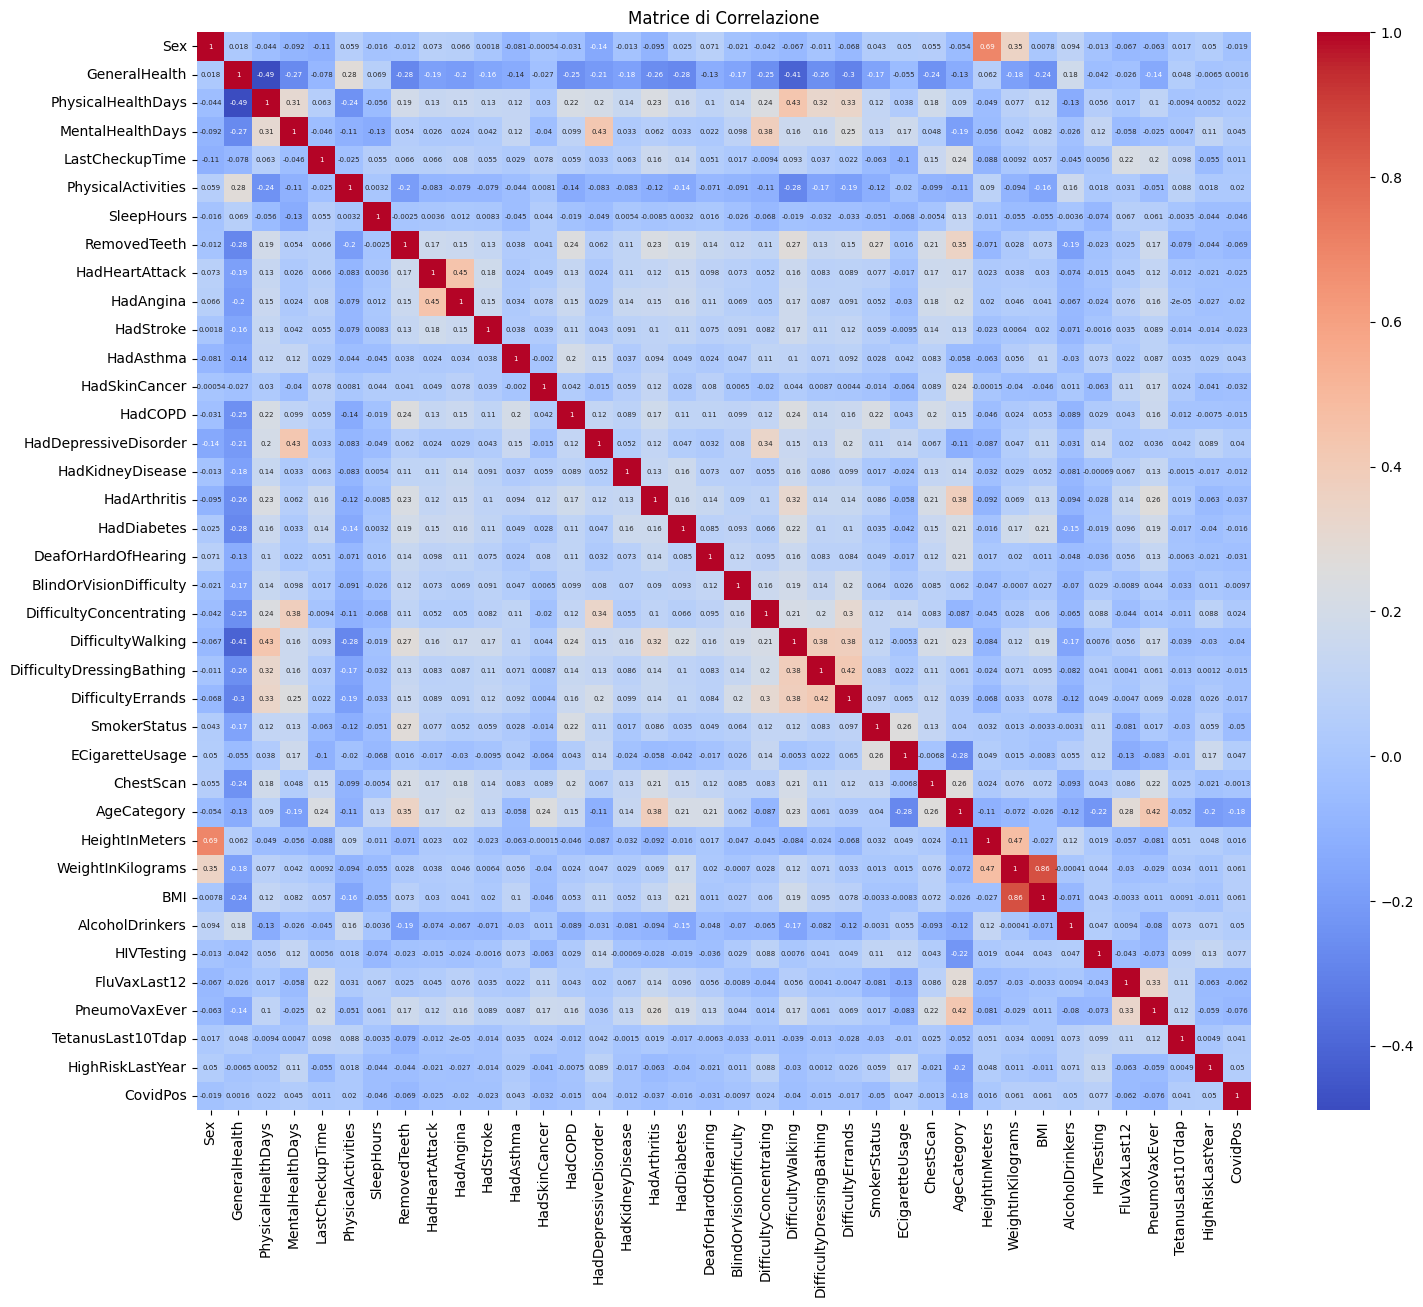

In [ ]:
# Lista delle colonne da rimuovere che iniziano per 'State'
columns_to_remove = df.filter(regex=r'^State').columns

# Crea un nuovo DataFrame escludendo le colonne 'State'
df = df.drop(columns=columns_to_remove)

numeric_columns = df.select_dtypes(include=[np.number])
corr_matrix = numeric_columns.corr(method='pearson')

# Imposta le dimensioni del grafico e le proprietà delle annotazioni
plt.figure(figsize=(17, 14))  # Imposta le dimensioni del grafico
sns.heatmap(corr_matrix, annot=True, annot_kws={"size": 5}, cmap='coolwarm')

# Aggiungi titolo e visualizza il grafico
plt.title('Matrice di Correlazione')
plt.show()

L'aver stampato la matrice di correlazione ha permesso di confermare l'alta correlazione positiva tra le feature "**BMI**" e "**WeightInKilograms**" precedentemente notata nel paragrafo relativo **Pair Plot Visualization**.

Si è deciso dunque di eliminare le features "**WeightInKilograms**" e "**HeightInMeters**" dal dataset poiché si dispone già della feature **BMI**, che sintetizza queste due variabili attraverso la formula del Body Mass Index (BMI).

La presenza di questi due attributi risulta quindi ridondante, la loro cancellazione ha permesso di semplificare il dataset senza perdere informazioni rilevanti, migliorando l'efficienza delle analisi successive.

Il BMI è calcolato come il peso in chilogrammi diviso per il quadrato dell'altezza in metri:

$$
BMI = \frac{peso (kg))}{altezza^2 (m^2))}
$$

In [ ]:
df = df.drop(columns=['WeightInKilograms', 'HeightInMeters'])

corr_matrix['HadHeartAttack'].sort_values(ascending=False)

HadHeartAttack               1.000000
HadAngina                    0.445902
HadStroke                    0.177149
AgeCategory                  0.172181
ChestScan                    0.167766
RemovedTeeth                 0.165903
DifficultyWalking            0.159884
HadDiabetes                  0.146961
PhysicalHealthDays           0.133422
HadCOPD                      0.133220
PneumoVaxEver                0.119965
HadArthritis                 0.117772
HadKidneyDisease             0.109353
DeafOrHardOfHearing          0.097660
DifficultyErrands            0.089492
DifficultyDressingBathing    0.083089
SmokerStatus                 0.077334
Sex                          0.073317
BlindOrVisionDifficulty      0.072962
LastCheckupTime              0.065757
DifficultyConcentrating      0.051661
HadSkinCancer                0.049415
FluVaxLast12                 0.045242
WeightInKilograms            0.038432
BMI                          0.030409
MentalHealthDays             0.025888
HadAsthma   

Analizzando la matrice di correlazione, osserviamo che alcune variabili mostrano relazioni significative con la variabile HadHeartAttack. Per esempio, **HadAngina** ha una correlazione positiva abbastanza forte (**0.445902**), suggerendo una relazione lineare che potrebbe essere stretta tra questi due fattori. Altre variabili come **HadStroke** (**0.177149**) e **AgeCategory** (**0.176501**) mostrano correlazioni moderate. Diverse variabili legate alla salute, come **ChestScan** (**0.167766**), **DifficultyWalking** (**0.159884**), **RemovedTeeth** (**0.150742**), e **HadDiabetes** (**0.144088**) presentano anch'esse correlazioni positive rilevanti.

Tuttavia, alcune correlazioni negative sono anche rilevanti: per esempio, **AlcoholDrinkers** (**-0.074176**) e **PhysicalActivities** (**-0.083186**) hanno correlazioni negative con HadHeartAttack. Notiamo anche che variabili come **Sex** (**0.073317**), **LastCheckupTime** (**0.070990**), e **SmokerStatus_Former** smoker (**0.074540**) presentano correlazioni deboli ma non trascurabili.

È cruciale considerare che la correlazione ci offre solo una visione delle relazioni lineari tra le variabili. Pertanto, potrebbe essere necessario condurre ulteriori analisi per escludere o includere alcune feature nel modello finale. Analisi più avanzate che considerino l'analisi delle interazioni non lineari, possono fornire ulteriori insights e garantire che le decisioni prese siano ben fondate e ottimizzate per la performance del modello. La correlazione, pur essendo un utile punto di partenza, rappresenta solo una parte del quadro complessivo necessario per un'analisi completa e accurata

In [ ]:
df.dtypes

Sex                                                      int64
GeneralHealth                                          float64
PhysicalHealthDays                                     float64
MentalHealthDays                                       float64
LastCheckupTime                                        float64
PhysicalActivities                                       int64
SleepHours                                             float64
RemovedTeeth                                           float64
HadHeartAttack                                           int64
HadAngina                                                int64
HadStroke                                                int64
HadAsthma                                                int64
HadSkinCancer                                            int64
HadCOPD                                                  int64
HadDepressiveDisorder                                    int64
HadKidneyDisease                                       

### Discretizzazione dell'attributo BMI



In [ ]:
from sklearn.preprocessing import KBinsDiscretizer

# Istanzia il discretizzatore
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')

# Applica il discretizzatore alla colonna 'BMI'
bmi_discretized = discretizer.fit_transform(df[['BMI']])

# Sostituisci la colonna 'BMI' con la colonna discretizzata
df['BMI'] = bmi_discretized

# Verifica i risultati
print(df[['BMI']].head())

     BMI
342  0.0
343  1.0
345  1.0
346  1.0
347  1.0


### Discretizzazione dell'attributo PhysicalHealthDays

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer

# Istanzia il discretizzatore
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')

# Applica il discretizzatore alla colonna 'BMI'
physicalHealthDays_discretized = discretizer.fit_transform(df[['PhysicalHealthDays']])

# Sostituisci la colonna 'BMI' con la colonna discretizzata
df['PhysicalHealthDays'] = physicalHealthDays_discretized

# Verifica i risultati
print(df[['PhysicalHealthDays']].head())

     PhysicalHealthDays
342                 0.0
343                 0.0
345                 0.0
346                 0.0
347                 0.0


###Discretizzazione dell'attributo MentalHealthDays

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer

# Istanzia il discretizzatore
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')

# Applica il discretizzatore alla colonna 'BMI'
mentalHealthDays_discretized = discretizer.fit_transform(df[['MentalHealthDays']])

# Sostituisci la colonna 'BMI' con la colonna discretizzata
df['MentalHealthDays'] = mentalHealthDays_discretized

# Verifica i risultati
print(df[['MentalHealthDays']].head())

     MentalHealthDays
342               0.0
343               0.0
345               0.0
346               0.0
347               2.0


In [ ]:
df_backup = df.copy()

df_backup.head()

Sex  GeneralHealth  PhysicalHealthDays  MentalHealthDays  \
342    0            3.0                 0.0               0.0   
343    1            3.0                 0.0               0.0   
345    1            3.0                 0.0               0.0   
346    0            1.0                 0.0               0.0   
347    0            2.0                 0.0               2.0   

     LastCheckupTime  PhysicalActivities  SleepHours  RemovedTeeth  \
342              3.0                   1         9.0           0.0   
343              3.0                   1         6.0           0.0   
345              3.0                   0         8.0           2.0   
346              3.0                   1         9.0           0.0   
347              3.0                   1         5.0           1.0   

     HadHeartAttack  HadAngina  ...  FluVaxLast12  PneumoVaxEver  \
342               0          0  ...             1              1   
343               0          0  ...             1              1   
345               0          0  ...             0              1   
346               0          0  ...             1              1   
347               0          0  ...             1              1   

     TetanusLast10Tdap  HighRiskLastYear  CovidPos  \
342                  1                 0         0   
343                  1                 0         0   
345                  0                 0         1   
346                  0                 0         1   
347                  0                 0         0   

     RaceEthnicityCategory_Black only, Non-Hispanic  \
342                                           False   
343                                           False   
345                                           False   
346                                           False   
347                                           False   

     RaceEthnicityCategory_Hispanic  \
342                           False   
343                           False   
345                           False   
346                           False   
347                           False   

     RaceEthnicityCategory_Multiracial, Non-Hispanic  \
342                                            False   
343                                            False   
345                                            False   
346                                            False   
347                                            False   

     RaceEthnicityCategory_Other race only, Non-Hispanic  \
342                                              False     
343                                              False     
345                                              False     
346                                              False     
347                                              False     

     RaceEthnicityCategory_White only, Non-Hispanic  
342                                            True  
343                                            True  
345                                            True  
346                                            True  
347                                            True  

[5 rows x 41 columns]

### Feature importance con RandomForestClassifier

Con il termine di Feature Importance si intende il contributo di ciascuna feature/attributo durante la fase di previsione di un modello di classificazione; quindi permette di determinare il livello di utilità di una variabile specifica per il modello e la previsione corrente.

In generale, l'importanza di ogni feature viene espressa mediante un valore numerico chiamato score, dove uno score più elevato corrisponde a una maggiore importanza.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# df: il dataframe completo

# Separa le caratteristiche (X) e la variabile target (Y)
X = df.drop(columns=['HadHeartAttack'])
y = df['HadHeartAttack']

# Inizializza il RandomForestClassifier
rnd_clf = RandomForestClassifier(random_state=42)

# Addestra il modello
rnd_clf.fit(X, y)

# Crea una serie con le importanze delle caratteristiche
feat_importancesRF = pd.Series(rnd_clf.feature_importances_, index=X.columns)

# Ordina le caratteristiche in base all'importanza
feat_importancesRF = feat_importancesRF.sort_values(ascending=False)



In [ ]:
print(feat_importancesRF)

HadAngina                                              0.155708
SleepHours                                             0.075495
AgeCategory                                            0.075346
GeneralHealth                                          0.046660
RemovedTeeth                                           0.045268
SmokerStatus                                           0.034773
BMI                                                    0.029507
PhysicalHealthDays                                     0.029456
TetanusLast10Tdap                                      0.025201
FluVaxLast12                                           0.023554
CovidPos                                               0.023440
MentalHealthDays                                       0.023328
ECigaretteUsage                                        0.022812
AlcoholDrinkers                                        0.022286
HadArthritis                                           0.021634
HadDiabetes                             

Si è deciso di produrre una rappresentazione grafica complessiva per gli score in modo tale da migliorarne la comprensione

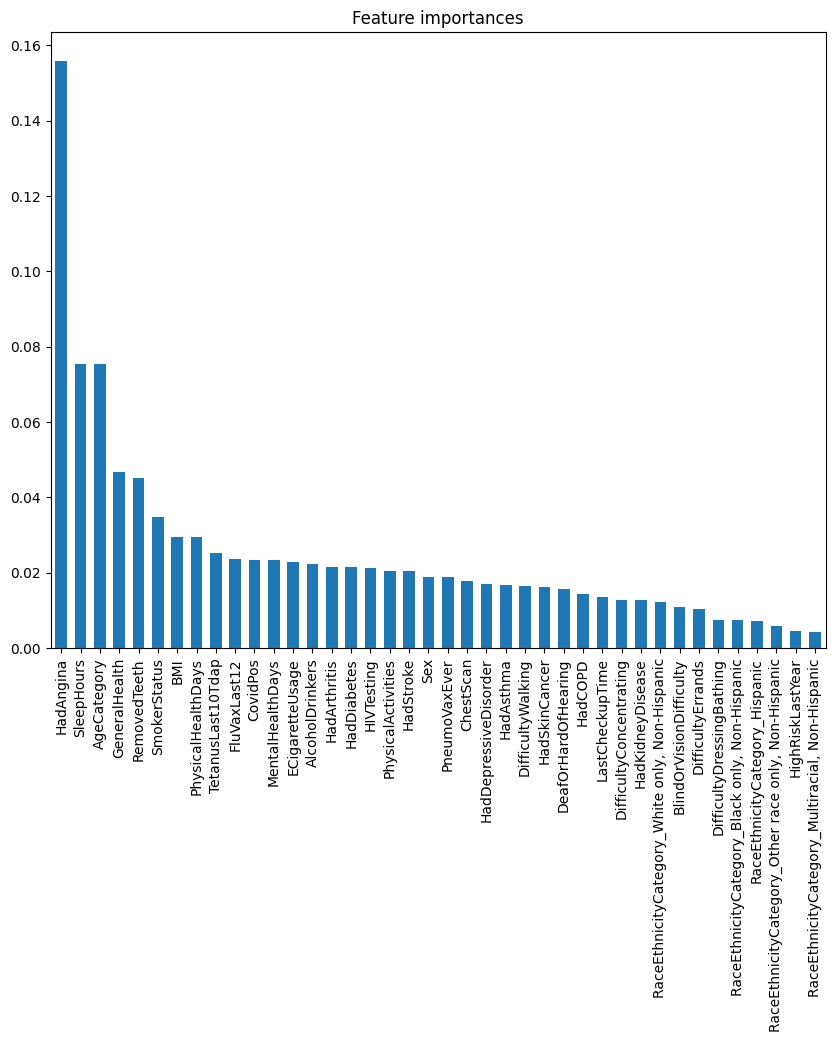

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))  # Opzionale: aumenta le dimensioni della figura

# Aumenta la grandezza delle barre
feat_importancesRF.plot.bar(ax=ax, width=0.6)

ax.set_title("Feature importances")

# Mostra il grafico
plt.show()

Dal grafico risulta immediatamente visibile come le features **hadAngina** e **BMI** abbiano lo score maggiore pertanto sono da considerarsi sicuramente importanti nel processo di predizione da parte del modello.

Proseguendo con un'analisi più approfondita si è deciso comunque di mantenere le feature il score è strettamente maggiore di 0.015, tra queste riportiamo:

1. **HadAngina**: 0.156445
2. **SleepHours**: 0.070047
3. **AgeCategory**: 0.070027
4. **PhysicalHealthDays**: 0.053947
5. **GeneralHealth**: 0.044128
6. **RemovedTeeth**: 0.042070
7. **MentalHealthDays**: 0.041682
8. **SmokerStatus**: 0.033266
9. **BMI**: 0.027354
10. **TetanusLast10Tdap**: 0.023514
11. **FluVaxLast12**: 0.022174
12. **CovidPos**: 0.021852
13. **AlcoholDrinkers**: 0.021774
14. **ECigaretteUsage**: 0.021658
15. **HadArthritis**: 0.020456
16. **HadDiabetes**: 0.020169
17. **HadStroke**: 0.020043
18. **HIVTesting**: 0.019986
19. **PhysicalActivities**: 0.019486
20. **Sex**: 0.018948



A questo punto è possibile finalizzare il processo di feature selection andando effettivamente a filtrare gli attributi risultati più importanti nelle fasi precedenti:

In [ ]:
columns_to_drop = ['PneumoVaxEver',
                   'ChestScan',
                   'HadAsthma',
                   'DifficultyWalking',
                   'HadDepressiveDisorder',
                   'HadSkinCancer',
                   'DeafOrHardOfHearing',
                   'HadCOPD',
                   'LastCheckupTime',
                   'DifficultyConcentrating',
                   'HadKidneyDisease',
                   'RaceEthnicityCategory_White only, Non-Hispanic',
                   'BlindOrVisionDifficulty',
                   'DifficultyErrands',
                   'RaceEthnicityCategory_Black only, Non-Hispanic',
                   'DifficultyDressingBathing',
                   'RaceEthnicityCategory_Hispanic',
                   'RaceEthnicityCategory_Other race only, Non-Hispanic',
                   'HighRiskLastYear',
                   'RaceEthnicityCategory_Multiracial, Non-Hispanic']

df = df.drop(columns= columns_to_drop)

df.head()

Sex  GeneralHealth  PhysicalHealthDays  MentalHealthDays  \
342    0            3.0                 0.0               0.0   
343    1            3.0                 0.0               0.0   
345    1            3.0                 0.0               0.0   
346    0            1.0                 0.0               0.0   
347    0            2.0                 0.0               2.0   

     PhysicalActivities  SleepHours  RemovedTeeth  HadHeartAttack  HadAngina  \
342                   1         9.0           0.0               0          0   
343                   1         6.0           0.0               0          0   
345                   0         8.0           2.0               0          0   
346                   1         9.0           0.0               0          0   
347                   1         5.0           1.0               0          0   

     HadStroke  ...  HadDiabetes  SmokerStatus  ECigaretteUsage  AgeCategory  \
342          0  ...          0.0           1.0              0.0          9.0   
343          0  ...          2.0           1.0              0.0         10.0   
345          0  ...          0.0           1.0              0.0         11.0   
346          0  ...          0.0           0.0              0.0         12.0   
347          0  ...          0.0           0.0              0.0         12.0   

     BMI  AlcoholDrinkers  HIVTesting  FluVaxLast12  TetanusLast10Tdap  \
342  0.0                0           0             1                  1   
343  1.0                0           0             1                  1   
345  1.0                1           0             0                  0   
346  1.0                0           0             1                  0   
347  1.0                0           0             1                  0   

     CovidPos  
342         0  
343         0  
345         1  
346         1  
347         0  

[5 rows x 21 columns]

# Classificazione

Si è passati a questo punto alla fase di **classificazione** con l'obiettivo di addestrare diversi modelli in modo tale da confrontarli e capire quale possa essere il migliore con i dati a disposizione.

In prima battuta si ragionerà sui dati senza effettuare alcuna operazione di bilanciamento (come visto il dataset è fortemente sbilanciato) per capire come si comportano i modelli.

Successivamente si procederà al bilanciamento del dataset utilizzando principalemente due librerie: **Imbalanced Learn** e **Smote**.

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['HadHeartAttack'])
y = df['HadHeartAttack']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_train.shape

(184509, 20)

## Classificazione (dataset sbilanciato)

### Misure di valutazione utilizzate

Per la valutazione dei modelli di classificazione si è scelto di utilizzare un set di misure standard all'interno del quale è possibile trovare:

1. $$
Precision = \frac{TP}{TP + FP}
$$
2. $$
Recall = \frac{TP}{TP + FN}
$$
  Trattando un dataset medico si è prestata una maggiore attenzione al valore di questa misura in quanto capace di calcolare la proporzione di veri positivi (i casi effettivamente positivi) correttamente identificati dal modello.
3. $$
F1-Score / F-Measure = \frac{2 x Precision x Recall}{Precision + Recall}
$$

4. **ROC-Curve e AUC** = Per **ROC-Curve** si intende una particolare curva che permette di mostrare il trade-off tra il tasso di veri positivi (True Positive Rate, TPR) e il tasso di falsi positivi (False Positive Rate, FPR).

  Nella maggior parte dei casi alla **ROC-Curve** si affianca il valore dell'**AUC (Area Under the Curve**) che permette di riassumere le prestazioni del modello. Si tratta di una misura che varia tra 0 e 1, in particolare:
  * Se **AUC = 1**: Il modello ha prestazioni perfette. Identifica correttamente tutti i positivi e i negativi.
  * Se **AUC = 0.5**: Il modello ha prestazioni casuali. Non distingue tra classi positive e negative meglio di un lancio di moneta.
  * Se **AUC < 0.5**: Le prestazioni del modello sono peggiori del caso.

  Proprio come per la Recall anche in questo caso si è prestata una maggiore attenzione in quanto un valore alto della AUC è sinonimo di una buona classificazione da parte del modello.


Per calcolare i primi 3 valori è stato utilizzato il **classification report** presente nella libreria Sklearn.


### Random Forest Classification

In [ ]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, RocCurveDisplay, roc_curve, auc, recall_score
from sklearn.metrics import classification_report

def plot_ROC_curve(model, X_test, y_test, y_pred):
  RocCurveDisplay.from_estimator(model, X_test, y_test)
  plt.title('ROC Curve')
  plt.plot([0,1],[0,1],'k--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.show()
  roc_auc = roc_auc_score(y_test, y_pred)
  print(f"ROC-AUC Score: {roc_auc}")

def plot_Confusion_matrix (cm):
  plt.figure(figsize=(8, 7))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()


def plot_confusion_matrix_and_roc(model, X_test, y_test, y_pred, y_prob):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 7))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('True')
    ax1.set_title('Confusion Matrix')

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    ax2.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    ax2.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax2.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

def compute_and_display_metrics(y_test, y_pred):
    # Calcolo delle metriche
    f1_std = f1_score(y_test, y_pred)
    f1_w = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    # Creazione del dataframe con le metriche
    metrics = {
        'Metric': ['F1 Score Std', 'F1 Score Weighted', 'Accuracy', 'Recall'],
        'Value': [f1_std, f1_w, accuracy, recall]
    }

    metrics_df = pd.DataFrame(metrics)

    # Stampa della tabella
    print(metrics_df)

def compute_RndFrst (dict, X_train, X_test, y_train, y_test):
  forest_clf = RandomForestClassifier(random_state = 42, class_weight= dict)
  forest_clf.fit(X_train, y_train)

  y_pred = forest_clf.predict(X_test)

  print(f"Results for weigthed Random Forest [{dict[0], dict[1]}]\n")

  #Visualizza matrice di confusione e curva ROC
  plot_confusion_matrix_and_roc(forest_clf, X_test, y_test, y_pred, forest_clf.predict_proba(X_test)[:,1])

  #Calcola e visualizza le metriche di valutazione del modello
  compute_and_display_metrics(y_test,y_pred)


Results for weigthed Random Forest without any weights



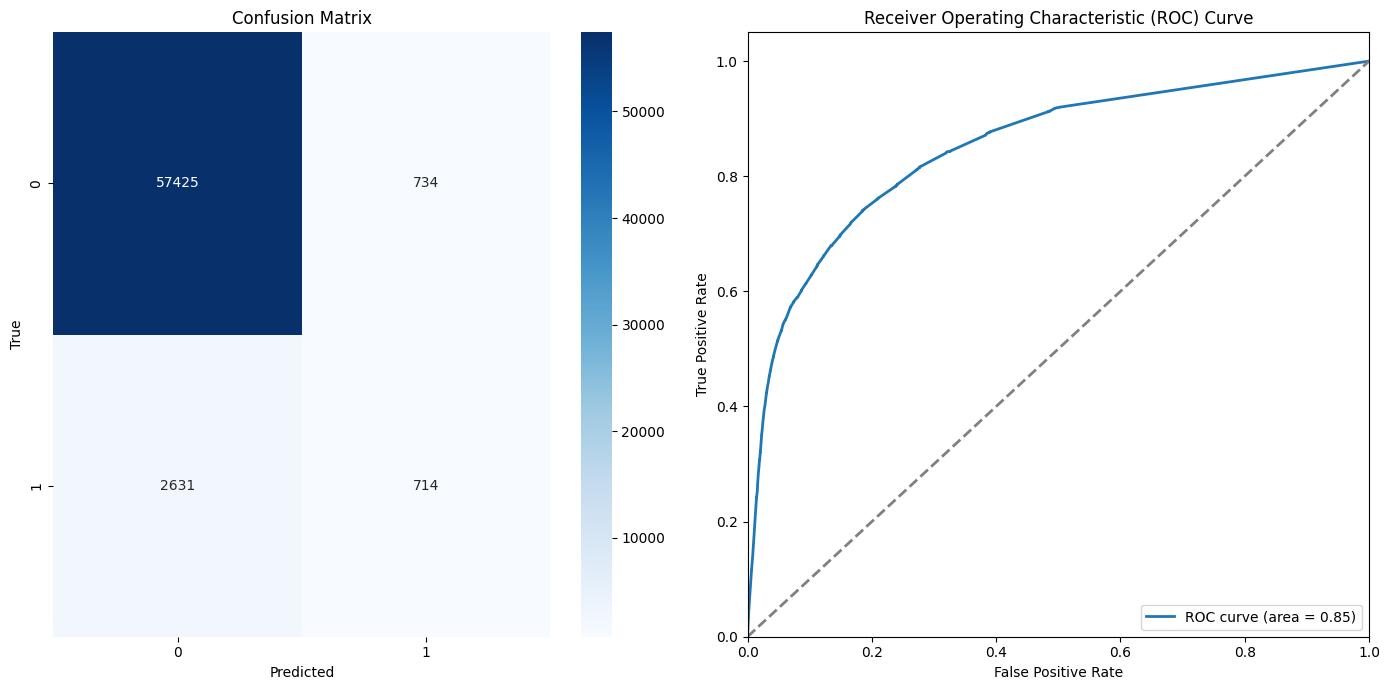

------- Sklearn Classification Report ------- 

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     58159
           1       0.49      0.21      0.30      3345

    accuracy                           0.95     61504
   macro avg       0.72      0.60      0.63     61504
weighted avg       0.93      0.95      0.93     61504



In [ ]:
def forest_clf_displayStats (forest_clf, X_train, X_test, y_train, y_test, y_pred, y_prob):
  print(f"Results for weigthed Random Forest without any weights\n")

  #Visualizza matrice di confusione e curva ROC
  plot_confusion_matrix_and_roc(forest_clf, X_test, y_test, y_pred, forest_clf.predict_proba(X_test)[:,1])

  print("------- Sklearn Classification Report ------- \n")
  print(classification_report(y_test, y_pred))

forest_clf_notBalanced = RandomForestClassifier(random_state = 42)
forest_clf_notBalanced.fit(X_train, y_train)

y_pred_notBalanced = forest_clf_notBalanced.predict(X_test)

y_prob_notBalanced = forest_clf_notBalanced.predict_proba(X_test)[:, 1]

#Random forest without weights
forest_clf_displayStats(forest_clf_notBalanced, X_train, X_test, y_train, y_test, y_pred_notBalanced, y_prob_notBalanced)

## Classificazione (dataset bilanciato)

Dai risultati ottenuti nella fase precedente dell'elaborato si è potuto constatare dai valori dell' F-Measure / F1-Score che i modelli di classificazione utilizzati non performano al meglio, questo è accaduto in quanto il dataset come anticipato era fortemente sbilanciato.

Si è deciso a questo punto di bilanciare il dataset procedendo in due fasi:

1. Fase di **downsampling**: Rimozione e rimodulazione del numero di istanze con classe negativa ("hadHeartAttack = No") fino ad un totale di 20k/30k tramite la libreria **Imbalanced-Learn**, in particolare usando l'algoritmo **TomekLinks**;
2. Fase di **upsampling**: Costruzione e aggiunta di istanze sintetiche con classe positiva ("hadHeartAttack = Si") fino ad un totale di 20k/25k tramite **Smote**.  



In [ ]:
#df = dataset completo pre-bilanciamento

df.head()

Sex  GeneralHealth  PhysicalHealthDays  MentalHealthDays  \
342    0            3.0                 0.0               0.0   
343    1            3.0                 0.0               0.0   
345    1            3.0                 0.0               0.0   
346    0            1.0                 0.0               0.0   
347    0            2.0                 0.0               2.0   

     PhysicalActivities  SleepHours  RemovedTeeth  HadHeartAttack  HadAngina  \
342                   1         9.0           0.0               0          0   
343                   1         6.0           0.0               0          0   
345                   0         8.0           2.0               0          0   
346                   1         9.0           0.0               0          0   
347                   1         5.0           1.0               0          0   

     HadStroke  ...  HadDiabetes  SmokerStatus  ECigaretteUsage  AgeCategory  \
342          0  ...          0.0           1.0              0.0          9.0   
343          0  ...          2.0           1.0              0.0         10.0   
345          0  ...          0.0           1.0              0.0         11.0   
346          0  ...          0.0           0.0              0.0         12.0   
347          0  ...          0.0           0.0              0.0         12.0   

     BMI  AlcoholDrinkers  HIVTesting  FluVaxLast12  TetanusLast10Tdap  \
342  0.0                0           0             1                  1   
343  1.0                0           0             1                  1   
345  1.0                1           0             0                  0   
346  1.0                0           0             1                  0   
347  1.0                0           0             1                  0   

     CovidPos  
342         0  
343         0  
345         1  
346         1  
347         0  

[5 rows x 21 columns]

Arrivati a questo punto si è ottenuto un nuovo dataset in cui la condizione di sbilanciamento dei dati iniziale è stata annullata. In particolare la dimensione del dataset attuale è pari a 35890 con un numero di **istanze positive** pari a **16945** e un numero di **istanze negative** pari a **18945**.

### Downsampling e UpSampling

In [ ]:
import pandas as pd
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

In [ ]:
df_backup2 = df.copy()

# Supponiamo che X_train e y_train siano già definiti
# Concatenare X_train e y_train per facilitare le operazioni di bilanciamento
Xy_train = pd.concat([X_train, y_train], axis=1)

# Separare le istanze per classe
X_no_heartAttack = Xy_train[Xy_train['HadHeartAttack'] == 0].drop(columns=['HadHeartAttack'])
y_no_heartAttack = Xy_train[Xy_train['HadHeartAttack'] == 0]['HadHeartAttack']
X_yes_heartAttack = Xy_train[Xy_train['HadHeartAttack'] == 1].drop(columns=['HadHeartAttack'])
y_yes_heartAttack = Xy_train[Xy_train['HadHeartAttack'] == 1]['HadHeartAttack']

# Applichiamo Tomek Links sull'intero dataset
tomek = TomekLinks(sampling_strategy='majority')
X_tomek, y_tomek = tomek.fit_resample(X_train, y_train)

In [ ]:
X_tomek.head()

Sex  GeneralHealth  PhysicalHealthDays  MentalHealthDays  \
0    1            3.0                 0.0               4.0   
1    0            3.0                 0.0               0.0   
2    0            2.0                 0.0               0.0   
3    0            3.0                 0.0               0.0   
4    1            3.0                 0.0               0.0   

   PhysicalActivities  SleepHours  RemovedTeeth  HadAngina  HadStroke  \
0                   1         5.0           0.0          0          0   
1                   0         7.0           2.0          0          0   
2                   1         8.0           0.0          0          0   
3                   1         6.0           1.0          0          0   
4                   1         7.0           1.0          0          0   

   HadArthritis  HadDiabetes  SmokerStatus  ECigaretteUsage  AgeCategory  BMI  \
0             0          0.0           3.0              1.0          4.0  0.0   
1             1          0.0           0.0              0.0          9.0  0.0   
2             1          0.0           0.0              0.0         10.0  0.0   
3             1          0.0           0.0              0.0         12.0  1.0   
4             0          0.0           1.0              0.0          7.0  0.0   

   AlcoholDrinkers  HIVTesting  FluVaxLast12  TetanusLast10Tdap  CovidPos  
0                1           1             0                  1         0  
1                0           0             1                  1         0  
2                0           0             1                  1         0  
3                0           0             1                  0         0  
4                1           1             0                  0         0

In [ ]:
y_tomek.head()

0    0
1    0
2    0
3    0
4    0
Name: HadHeartAttack, dtype: int64

In [ ]:
# Creare un nuovo DataFrame dal risultato di Tomek Links
Xy_tomek = pd.concat([X_tomek, y_tomek], axis=1)

print(Xy_tomek.shape)
Xy_tomek.head()

(182684, 21)


Sex  GeneralHealth  PhysicalHealthDays  MentalHealthDays  \
0    1            3.0                 0.0               4.0   
1    0            3.0                 0.0               0.0   
2    0            2.0                 0.0               0.0   
3    0            3.0                 0.0               0.0   
4    1            3.0                 0.0               0.0   

   PhysicalActivities  SleepHours  RemovedTeeth  HadAngina  HadStroke  \
0                   1         5.0           0.0          0          0   
1                   0         7.0           2.0          0          0   
2                   1         8.0           0.0          0          0   
3                   1         6.0           1.0          0          0   
4                   1         7.0           1.0          0          0   

   HadArthritis  ...  SmokerStatus  ECigaretteUsage  AgeCategory  BMI  \
0             0  ...           3.0              1.0          4.0  0.0   
1             1  ...           0.0              0.0          9.0  0.0   
2             1  ...           0.0              0.0         10.0  0.0   
3             1  ...           0.0              0.0         12.0  1.0   
4             0  ...           1.0              0.0          7.0  0.0   

   AlcoholDrinkers  HIVTesting  FluVaxLast12  TetanusLast10Tdap  CovidPos  \
0                1           1             0                  1         0   
1                0           0             1                  1         0   
2                0           0             1                  1         0   
3                0           0             1                  0         0   
4                1           1             0                  0         0   

   HadHeartAttack  
0               0  
1               0  
2               0  
3               0  
4               0  

[5 rows x 21 columns]

In [ ]:
# Separare le istanze dopo Tomek Links
Xy_tomek_HHA_no = Xy_tomek[Xy_tomek['HadHeartAttack'] == 0]
Xy_tomek_HHA_yes = Xy_tomek[Xy_tomek['HadHeartAttack'] == 1]

# Downsampling delle istanze "no" nel training set
Xy_no_heartAttack_downsampled = resample(Xy_tomek_HHA_no,
                                         replace=False,
                                         n_samples=20000,
                                         random_state=42)

print(Xy_no_heartAttack_downsampled.shape)

Xy_heartAttack_downsampled_complete = pd.concat([Xy_no_heartAttack_downsampled, Xy_tomek_HHA_yes])
print(Xy_heartAttack_downsampled_complete.shape)

X_heartAttack_downsampled_complete = Xy_heartAttack_downsampled_complete.drop(columns=['HadHeartAttack'])
y_heartAttack_downsampled_complete = Xy_heartAttack_downsampled_complete['HadHeartAttack']

# Upsampling delle istanze "yes" nel training set
#Istanziamo SMOTE
smote = SMOTE(sampling_strategy='minority', random_state=42)

#Applichiamo SMOTE
X_upsampled_train, y_upsampled_train = smote.fit_resample(X_heartAttack_downsampled_complete, y_heartAttack_downsampled_complete)

y_upsampled_train.value_counts()

(20000, 21)
(30090, 21)


HadHeartAttack
0    20000
1    20000
Name: count, dtype: int64

### Training dei modelli di classificazione sul nuovo dataset

L'obiettivo ora è quello di addestrare i modelli di classificazione sul nuovo dataset per verificare se effettivamente le fasi di downsampling e upsampling hanno avuto successo.

Ci si aspetta in particolare che gli score che permettono di valutare le prestazioni del modello siano notevolmente aumentati rispetto al contesto precedente.

In [ ]:
#Da usare:

print(X_upsampled_train.shape)
print(y_upsampled_train.shape)


(40000, 20)
(40000,)


#### Random Forest Classification

Il primo modello di classificazione provato sul nuovo training set bilanciato è stato il Random Forest Classifier.

In [ ]:
def compute_RndFrst_balanced (X_train, X_test, y_train, y_test):
  forest_clf = RandomForestClassifier(random_state = 42)
  forest_clf.fit(X_train, y_train)

  y_pred = forest_clf.predict(X_test)

  print(f"Results for Random Forest\n")

  #Visualizza matrice di confusione e curva ROC
  plot_confusion_matrix_and_roc(forest_clf, X_test, y_test, y_pred, forest_clf.predict_proba(X_test)[:,1])

  print("------- Sklearn Classification Report ------- \n")
  print(classification_report(y_test, y_pred))

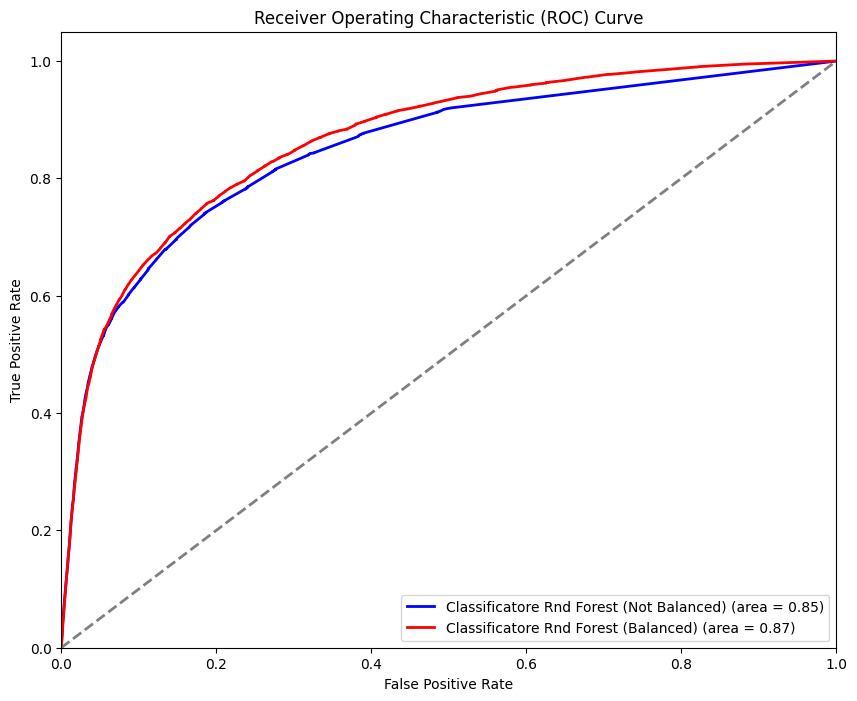

In [ ]:
#Istanziazione del modello balanced per confrontarlo con il gemello notBalanced

forest_clf_balanced = RandomForestClassifier(random_state = 42)
forest_clf_balanced.fit(X_upsampled_train, y_upsampled_train)

y_pred_balanced = forest_clf_balanced.predict(X_test)

y_prob_balanced = forest_clf_balanced.predict_proba(X_test)[:, 1]

#Calcolo delle curve ROC
fpr_c1, tpr_c1, _ = roc_curve(y_test, y_prob_notBalanced)
roc_auc_c1 = auc(fpr_c1, tpr_c1)

fpr_c2, tpr_c2, _ = roc_curve(y_test, y_prob_balanced)
roc_auc_c2 = auc(fpr_c2, tpr_c2)

# Tracciare le curve ROC
plt.figure(figsize=(10, 8))
plt.plot(fpr_c1, tpr_c1, color='blue', lw=2, label=f'Classificatore Rnd Forest (Not Balanced) (area = {roc_auc_c1:.2f})')
plt.plot(fpr_c2, tpr_c2, color='red', lw=2, label=f'Classificatore Rnd Forest (Balanced) (area = {roc_auc_c2:.2f})')

# Linea di riferimento
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')

# Etichette e titolo
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Mostrare il plot
plt.show()

Results for Random Forest



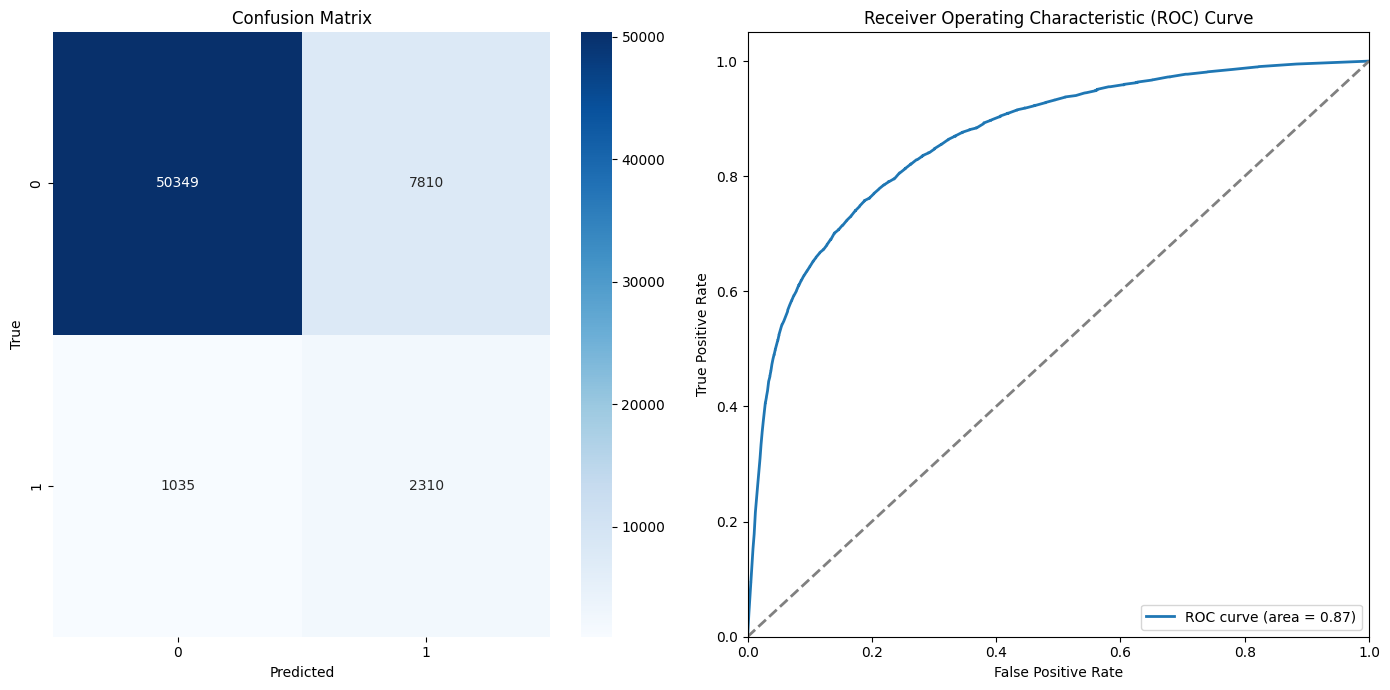

------- Sklearn Classification Report ------- 

              precision    recall  f1-score   support

           0       0.98      0.87      0.92     58159
           1       0.23      0.69      0.34      3345

    accuracy                           0.86     61504
   macro avg       0.60      0.78      0.63     61504
weighted avg       0.94      0.86      0.89     61504



In [ ]:
#Random forest classification
compute_RndFrst_balanced(X_upsampled_train, X_test, y_upsampled_train, y_test)

Non avendo certezza che i parametri utilizzati fossero tali da garantire le migliori performance previsive per il modello si è deciso di utilizzare la funzione **grid_search** di **GridSearchCV** in modo tale da poter trovare la combinazione ottima degli stessi.

Questo procedimento è stato svolto per ogni modello di classificazione.

##### Grid Search w/ Random Forest Classifier

In [ ]:
from sklearn.model_selection import GridSearchCV

def compute_grid_search (model, param_grid, X_train, X_test, y_train, y_test):

  grid_search = GridSearchCV(model, param_grid, cv=5, scoring= ['f1','f1_weighted','recall','roc_auc'], refit = 'f1_weighted')

  grid_search.fit(X_train, y_train)

  print(f"Best parameters: {grid_search.best_params_}")
  print(f"Best score: {grid_search.best_score_}")
  print(f"Best estimator: {grid_search.best_estimator_}")

  y_pred = grid_search.predict(X_test)
  y_prob = grid_search.predict_proba(X_test)[:, 1]

  #Creiamo un dataframe Pandas con tutti gli score
  results_df = pd.DataFrame(grid_search.cv_results_)
  scores_df = results_df[['params', 'mean_test_f1', 'mean_test_f1_weighted', 'mean_test_recall', 'mean_test_roc_auc']]
  print(scores_df)

  plot_confusion_matrix_and_roc(grid_search.best_estimator_, X_test, y_test, y_pred, y_prob)

  print("------- Sklearn Classification Report ------- \n")
  print(classification_report(y_test, y_pred))

Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best score: 0.8601475273978817
Best estimator: RandomForestClassifier(n_estimators=200, random_state=42)
                                               params  mean_test_f1  \
0   {'max_depth': None, 'min_samples_leaf': 1, 'mi...      0.851922   
1   {'max_depth': None, 'min_samples_leaf': 1, 'mi...      0.853370   
2   {'max_depth': None, 'min_samples_leaf': 1, 'mi...      0.854496   
3   {'max_depth': None, 'min_samples_leaf': 1, 'mi...      0.846887   
4   {'max_depth': None, 'min_samples_leaf': 1, 'mi...      0.850554   
5   {'max_depth': None, 'min_samples_leaf': 1, 'mi...      0.850997   
6   {'max_depth': None, 'min_samples_leaf': 1, 'mi...      0.843506   
7   {'max_depth': None, 'min_samples_leaf': 1, 'mi...      0.845860   
8   {'max_depth': None, 'min_samples_leaf': 1, 'mi...      0.846272   
9   {'max_depth': None, 'min_samples_leaf': 2, 'mi...      0.846156   
10  {'max

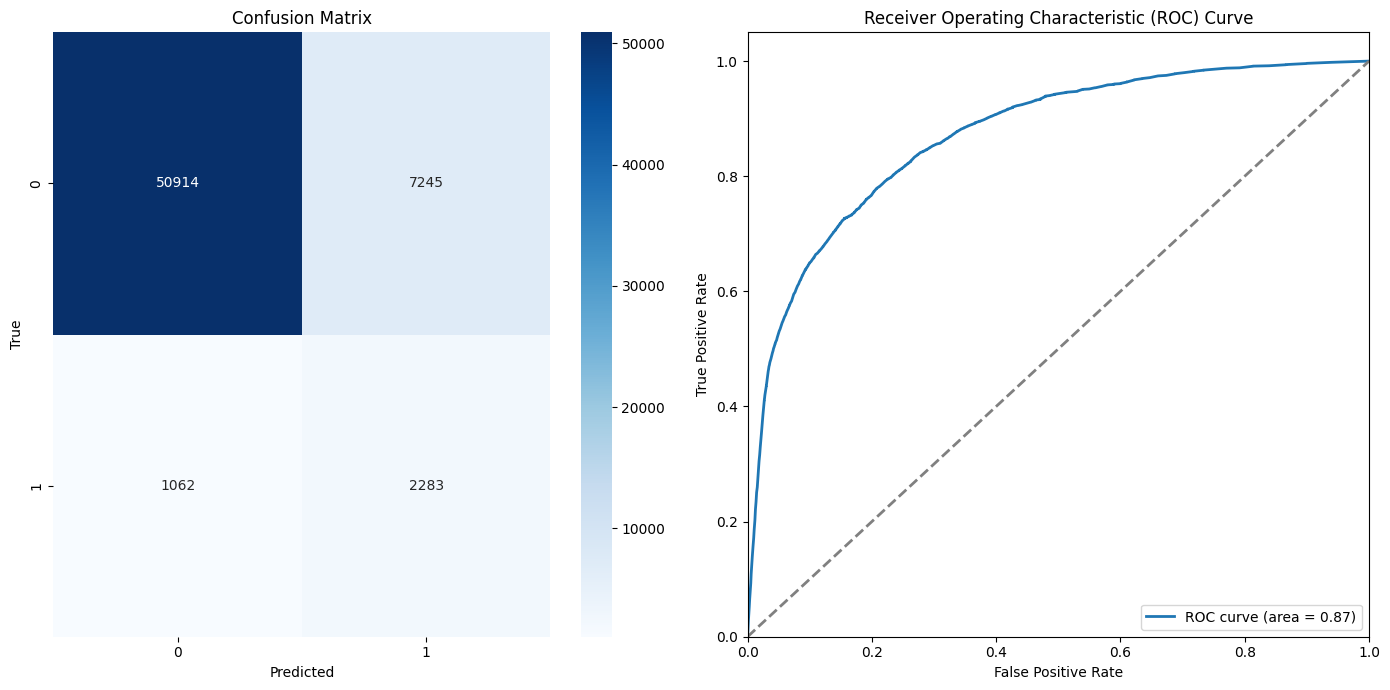

------- Sklearn Classification Report ------- 

              precision    recall  f1-score   support

           0       0.98      0.88      0.92     58159
           1       0.24      0.68      0.35      3345

    accuracy                           0.86     61504
   macro avg       0.61      0.78      0.64     61504
weighted avg       0.94      0.86      0.89     61504



In [ ]:
forest_clf = RandomForestClassifier(random_state = 42)

param_grid_forest = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2]
}

compute_grid_search(forest_clf, param_grid_forest, X_upsampled_train, X_test, y_upsampled_train, y_test)


#### Logistic Regression Classification



In [ ]:
from sklearn.linear_model import LogisticRegression

def compute_LogRegr (X_train, X_test, y_train, y_test):
  logReg_clf = LogisticRegression(random_state = 42)
  logReg_clf.fit(X_train, y_train)

  y_pred = logReg_clf.predict(X_test)

  print(f"Results for Logistic Regression\n")

  #Visualizza matrice di confusione e curva ROC
  plot_confusion_matrix_and_roc(logReg_clf, X_test, y_test, y_pred, logReg_clf.predict_proba(X_test)[:,1])

  print("------- Sklearn Classification Report ------- \n")
  print(classification_report(y_test, y_pred))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Results for Logistic Regression



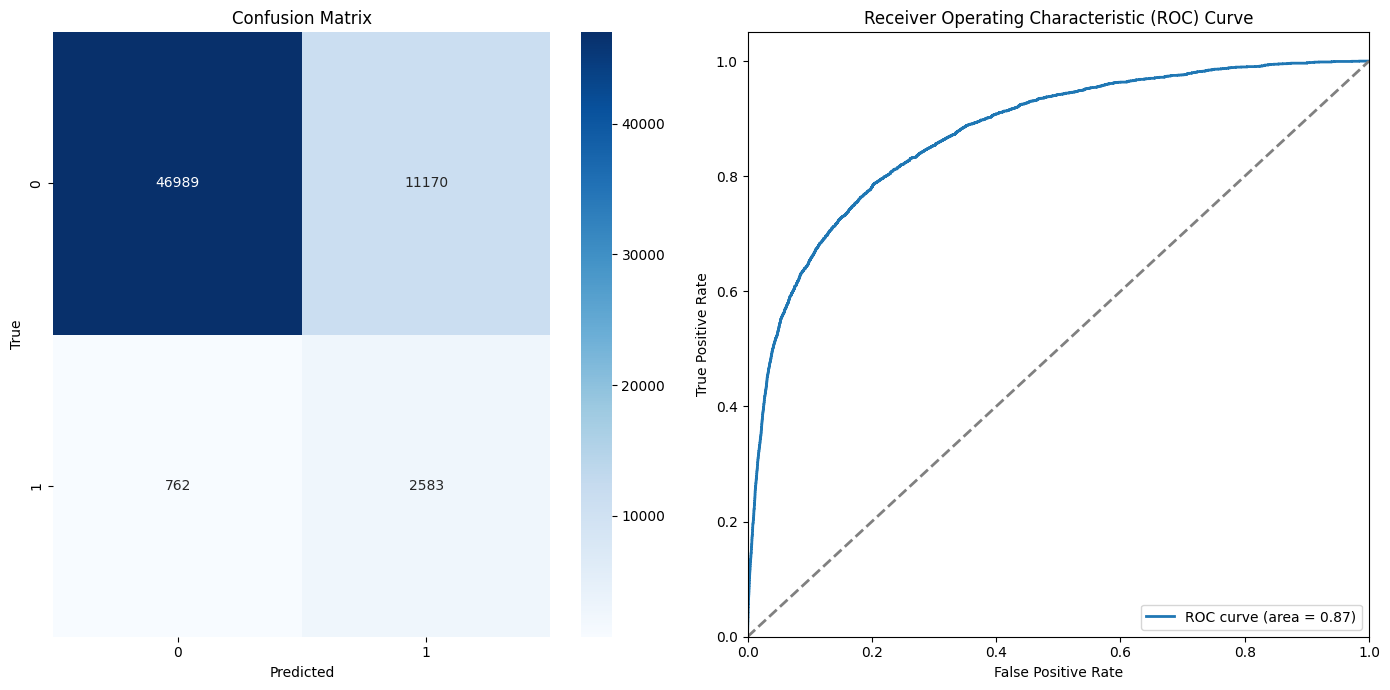

------- Sklearn Classification Report ------- 

              precision    recall  f1-score   support

           0       0.98      0.81      0.89     58159
           1       0.19      0.77      0.30      3345

    accuracy                           0.81     61504
   macro avg       0.59      0.79      0.59     61504
weighted avg       0.94      0.81      0.86     61504



In [ ]:
#Logistic Regression
compute_LogRegr(X_upsampled_train, X_test, y_upsampled_train, y_test)

##### Grid Search w/ LogisticRegression Classifier

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best parameters: {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best score: 0.7871979135269072
Best estimator: LogisticRegression(C=0.01, random_state=42, solver='liblinear')
                                               params  mean_test_f1  \
0   {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', ...      0.782146   
1   {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', ...      0.781877   
2   {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', ...      0.782831   
3   {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', ...      0.782082   
4   {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', ...      0.781969   
..                                                ...           ...   
95  {'C': 100, 'max_iter': 1000, 'penalty': 'l2', ...      0.779483   
96  {'C': 100, 'max_iter': 1000, 'penalty': 'l2', ...      0.779423   
97  {'C': 100, 'max_iter': 1000, 'penalty': 'l2', ...      0.779464   
98  {'C': 100, 'max_iter': 1000, 'penalty': 'l2', ...      0.779553   
99  {'C': 100, 'max_it

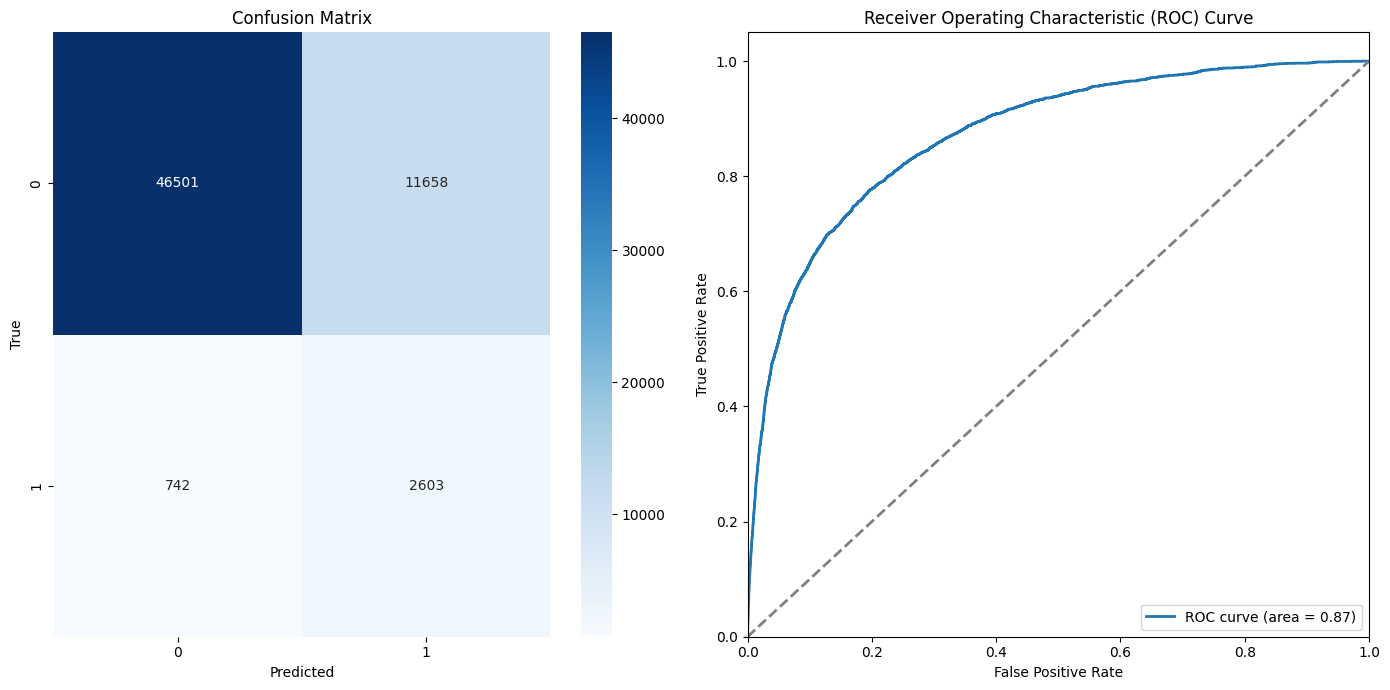

------- Sklearn Classification Report ------- 

              precision    recall  f1-score   support

           0       0.98      0.80      0.88     58159
           1       0.18      0.78      0.30      3345

    accuracy                           0.80     61504
   macro avg       0.58      0.79      0.59     61504
weighted avg       0.94      0.80      0.85     61504



In [ ]:
logReg_clf = LogisticRegression(random_state = 42)

param_grid_logreg = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'penalty': ['l2'],
    'max_iter': [100, 200, 500, 1000]
}

compute_grid_search(logReg_clf, param_grid_logreg, X_upsampled_train, X_test, y_upsampled_train, y_test)

#### Naive Bayesian Classification

In [ ]:
from sklearn.naive_bayes import GaussianNB

def compute_NaiveBayes (X_train, X_test, y_train, y_test):
  naiveBay_clf = GaussianNB()
  naiveBay_clf.fit(X_train, y_train)

  y_pred = naiveBay_clf.predict(X_test)

  print(f"Results for Logistic Regression\n")

  #Visualizza matrice di confusione e curva ROC
  plot_confusion_matrix_and_roc(naiveBay_clf, X_test, y_test, y_pred, naiveBay_clf.predict_proba(X_test)[:,1])

  print("------- Sklearn Classification Report ------- \n")
  print(classification_report(y_test, y_pred))



Results for Logistic Regression



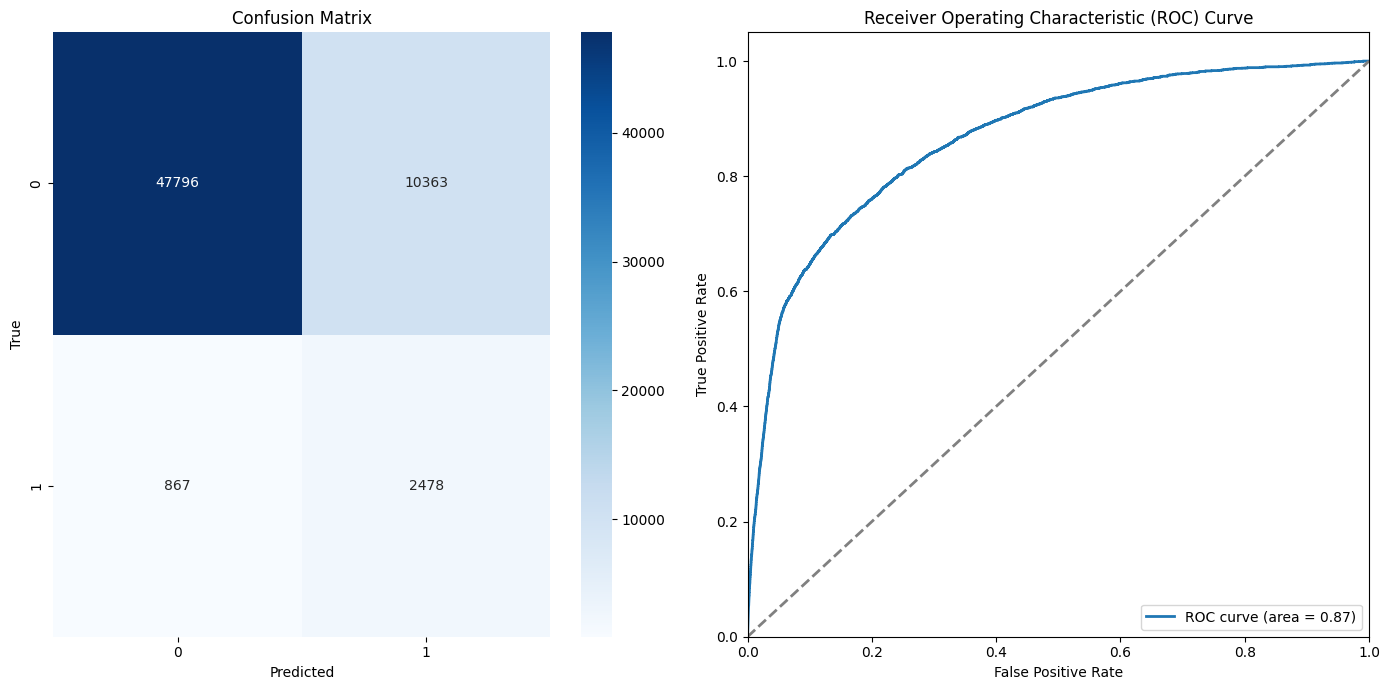

------- Sklearn Classification Report ------- 

              precision    recall  f1-score   support

           0       0.98      0.82      0.89     58159
           1       0.19      0.74      0.31      3345

    accuracy                           0.82     61504
   macro avg       0.59      0.78      0.60     61504
weighted avg       0.94      0.82      0.86     61504



In [ ]:
compute_NaiveBayes(X_upsampled_train, X_test, y_upsampled_train, y_test)

##### Grid Search w/ Naive Bayes Classifier with Gaussian Distribution

Best parameters: {'var_smoothing': 0.0001}
Best score: 0.7689839623387261
Best estimator: GaussianNB(var_smoothing=0.0001)
                      params  mean_test_f1  mean_test_f1_weighted  \
0   {'var_smoothing': 1e-09}      0.755213               0.768363   
1   {'var_smoothing': 1e-08}      0.755213               0.768363   
2   {'var_smoothing': 1e-07}      0.755213               0.768363   
3   {'var_smoothing': 1e-06}      0.755331               0.768441   
4   {'var_smoothing': 1e-05}      0.755431               0.768340   
5  {'var_smoothing': 0.0001}      0.757600               0.768984   
6   {'var_smoothing': 0.001}      0.749582               0.760510   
7    {'var_smoothing': 0.01}      0.676828               0.707416   
8     {'var_smoothing': 0.1}      0.513436               0.604909   
9       {'var_smoothing': 1}      0.453846               0.570567   

   mean_test_recall  mean_test_roc_auc  
0           0.71415           0.861490  
1           0.71415           0.861

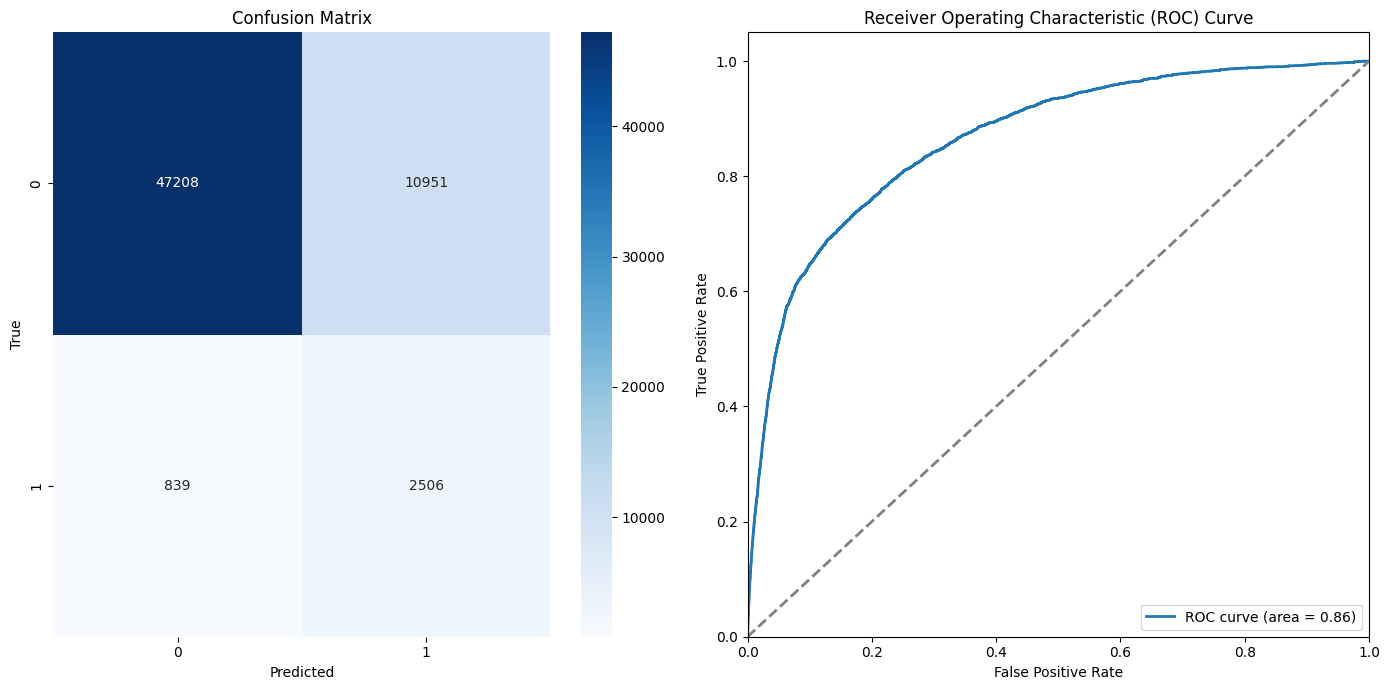

------- Sklearn Classification Report ------- 

              precision    recall  f1-score   support

           0       0.98      0.81      0.89     58159
           1       0.19      0.75      0.30      3345

    accuracy                           0.81     61504
   macro avg       0.58      0.78      0.59     61504
weighted avg       0.94      0.81      0.86     61504



In [ ]:
naiveBay_clf = GaussianNB()

param_grid_naiveBay = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]}


compute_grid_search(naiveBay_clf, param_grid_naiveBay, X_upsampled_train, X_test, y_upsampled_train, y_test)

#### K-Nearest Neighbor Classification

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

def compute_KNN (k, X_train, X_test, y_train, y_test):
  knn_clf = KNeighborsClassifier(n_neighbors= k)
  knn_clf.fit(X_train, y_train)

  y_pred = knn_clf.predict(X_test)

  print(f"Results for KNN Classification\n")

  #Visualizza matrice di confusione e curva ROC
  plot_confusion_matrix_and_roc(knn_clf, X_test, y_test, y_pred, knn_clf.predict_proba(X_test)[:,1])

  print("------- Sklearn Classification Report ------- \n")
  print(classification_report(y_test, y_pred))

##### KNN w/k=5

Results for KNN Classification



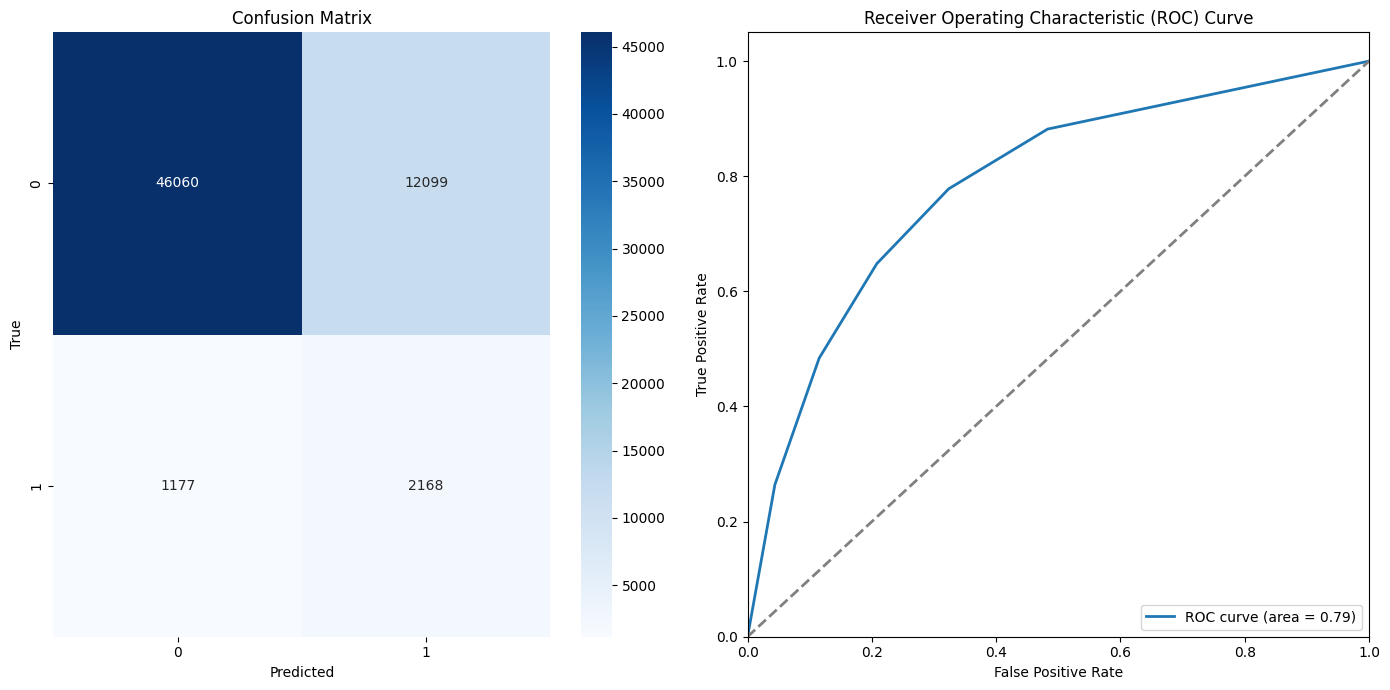

------- Sklearn Classification Report ------- 

              precision    recall  f1-score   support

           0       0.98      0.79      0.87     58159
           1       0.15      0.65      0.25      3345

    accuracy                           0.78     61504
   macro avg       0.56      0.72      0.56     61504
weighted avg       0.93      0.78      0.84     61504



In [ ]:
#KNN w/ k=5
compute_KNN(5, X_upsampled_train, X_test, y_upsampled_train, y_test)

##### Grid Search w/ K-Nearest Neighbor Classifier

Best parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Best score: 0.8660731768116852
Best estimator: KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')
                                               params  mean_test_f1  \
0   {'metric': 'euclidean', 'n_neighbors': 3, 'wei...      0.844369   
1   {'metric': 'euclidean', 'n_neighbors': 3, 'wei...      0.853887   
2   {'metric': 'euclidean', 'n_neighbors': 5, 'wei...      0.827395   
3   {'metric': 'euclidean', 'n_neighbors': 5, 'wei...      0.845301   
4   {'metric': 'euclidean', 'n_neighbors': 10, 'we...      0.790973   
5   {'metric': 'euclidean', 'n_neighbors': 10, 'we...      0.834575   
6   {'metric': 'euclidean', 'n_neighbors': 20, 'we...      0.780764   
7   {'metric': 'euclidean', 'n_neighbors': 20, 'we...      0.817487   
8   {'metric': 'euclidean', 'n_neighbors': 50, 'we...      0.776827   
9   {'metric': 'euclidean', 'n_neighbors': 50, 'we...      0.800323   
10  {'metric':

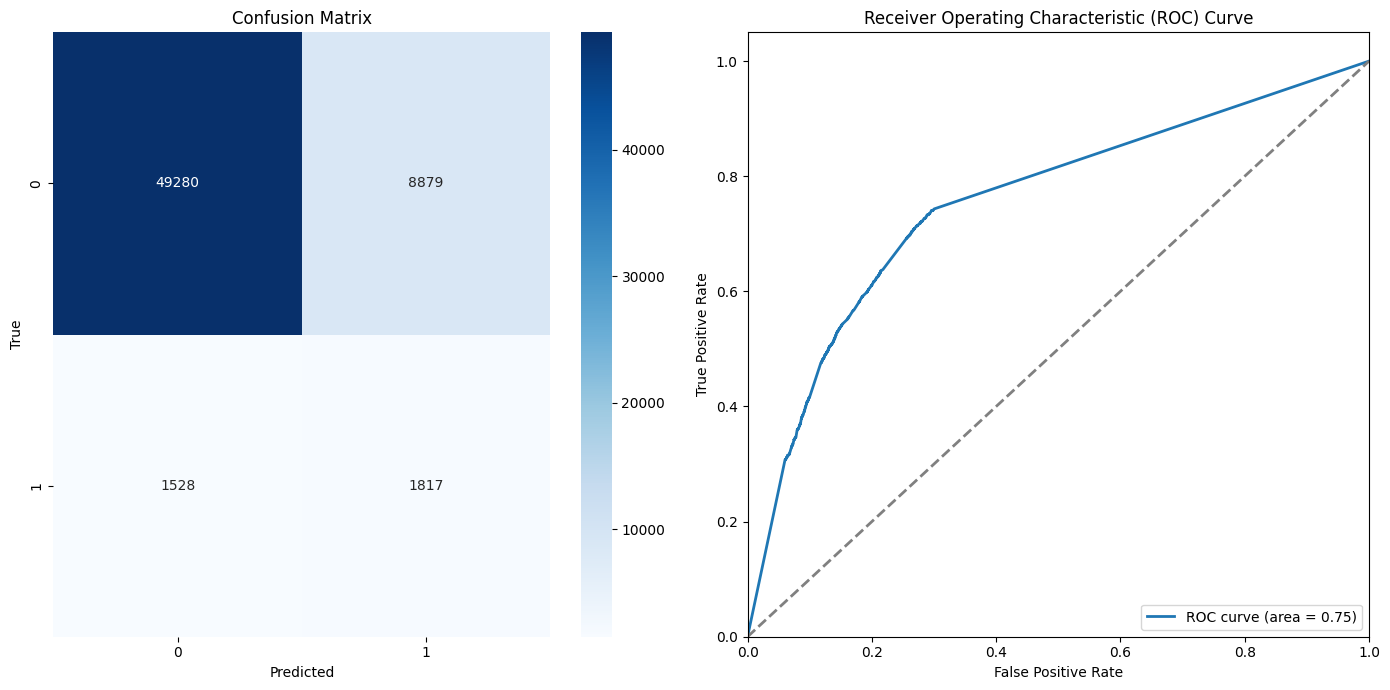

------- Sklearn Classification Report ------- 

              precision    recall  f1-score   support

           0       0.97      0.85      0.90     58159
           1       0.17      0.54      0.26      3345

    accuracy                           0.83     61504
   macro avg       0.57      0.70      0.58     61504
weighted avg       0.93      0.83      0.87     61504



In [ ]:
KNN_clf = KNeighborsClassifier()

param_grid_knn = {
    'n_neighbors': [3, 5, 10, 20, 50, 100],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

compute_grid_search(KNN_clf, param_grid_knn, X_upsampled_train, X_test, y_upsampled_train, y_test)

#### SGD Classification

In [ ]:
from sklearn.linear_model import SGDClassifier

def compute_SGD (X_train, X_test, y_train, y_test):
  sgd_clf = SGDClassifier(random_state = 42, loss='modified_huber')
  sgd_clf.fit(X_train, y_train)

  y_pred = sgd_clf.predict(X_test)

  print(f"Results for SGD Classification\n")

  #Visualizza matrice di confusione e curva ROC
  plot_confusion_matrix_and_roc(sgd_clf, X_test, y_test, y_pred, sgd_clf.predict_proba(X_test)[:,1])

  print("------- Sklearn Classification Report ------- \n")
  print(classification_report(y_test, y_pred))

Results for SGD Classification



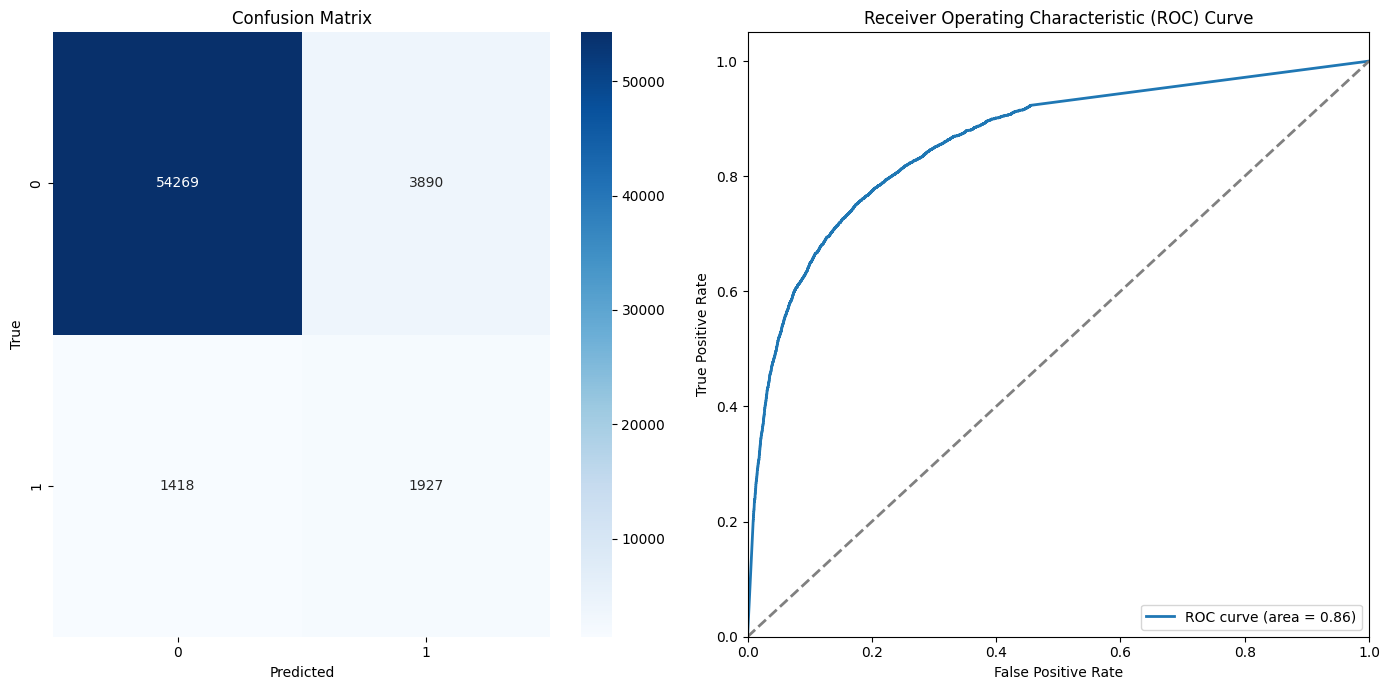

------- Sklearn Classification Report ------- 

              precision    recall  f1-score   support

           0       0.97      0.93      0.95     58159
           1       0.33      0.58      0.42      3345

    accuracy                           0.91     61504
   macro avg       0.65      0.75      0.69     61504
weighted avg       0.94      0.91      0.92     61504



In [ ]:
compute_SGD(X_upsampled_train, X_test, y_upsampled_train, y_test)

##### Grid Search w/ SGD Classifier

Best parameters: {'loss': 'log_loss', 'max_iter': 1000, 'penalty': 'l1'}
Best score: 0.7823224433359206
Best estimator: SGDClassifier(loss='log_loss', penalty='l1', random_state=42)
                                               params  mean_test_f1  \
0   {'loss': 'log_loss', 'max_iter': 1000, 'penalt...      0.755711   
1   {'loss': 'log_loss', 'max_iter': 1000, 'penalt...      0.755549   
2   {'loss': 'log_loss', 'max_iter': 1000, 'penalt...      0.775486   
3   {'loss': 'log_loss', 'max_iter': 1000, 'penalt...      0.775299   
4   {'loss': 'log_loss', 'max_iter': 2000, 'penalt...      0.755711   
5   {'loss': 'log_loss', 'max_iter': 2000, 'penalt...      0.755549   
6   {'loss': 'log_loss', 'max_iter': 2000, 'penalt...      0.775486   
7   {'loss': 'log_loss', 'max_iter': 2000, 'penalt...      0.775299   
8   {'loss': 'log_loss', 'max_iter': 3000, 'penalt...      0.755711   
9   {'loss': 'log_loss', 'max_iter': 3000, 'penalt...      0.755549   
10  {'loss': 'log_loss', 'max_iter': 

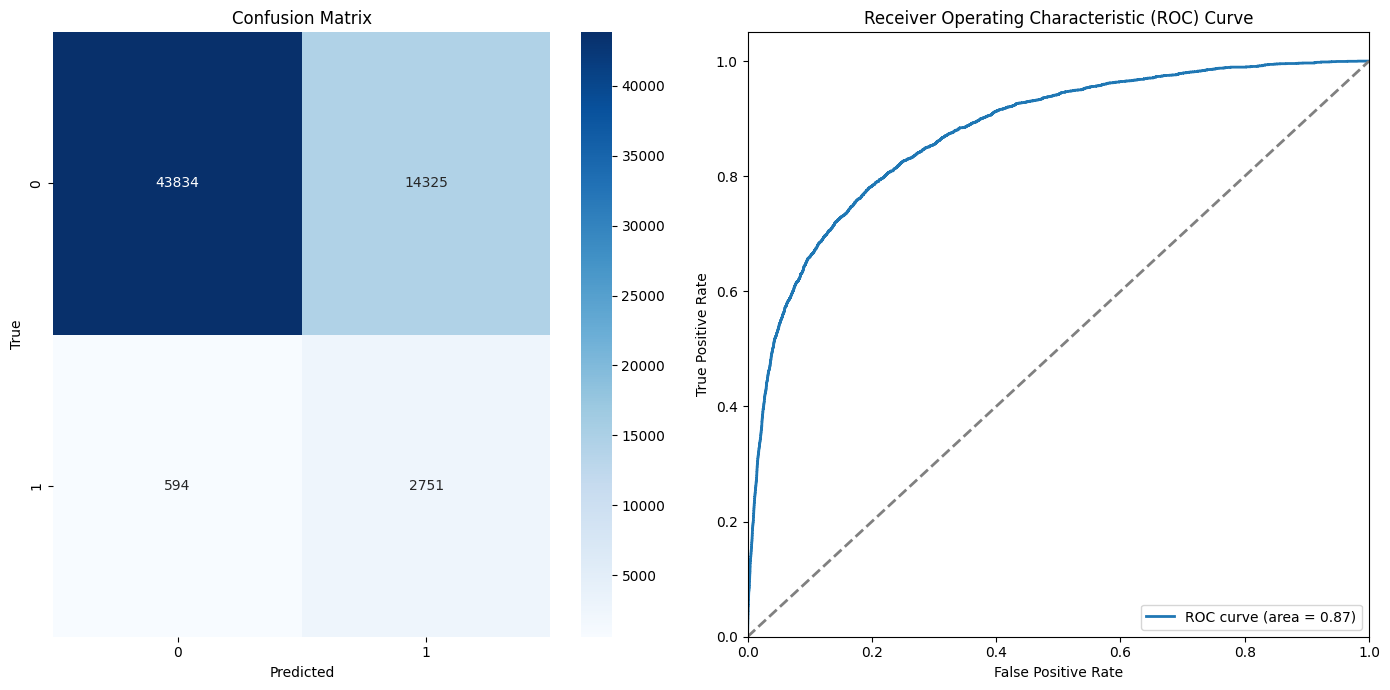

------- Sklearn Classification Report ------- 

              precision    recall  f1-score   support

           0       0.99      0.75      0.85     58159
           1       0.16      0.82      0.27      3345

    accuracy                           0.76     61504
   macro avg       0.57      0.79      0.56     61504
weighted avg       0.94      0.76      0.82     61504



In [ ]:
sgd_clf = SGDClassifier(random_state = 42, loss='modified_huber')

param_grid_sgd = {
    'loss': ['log_loss', 'modified_huber'],
    'penalty': [None, 'l2', 'l1', 'elasticnet'],
    'max_iter': [1000, 2000, 3000]
}

compute_grid_search(sgd_clf, param_grid_sgd, X_upsampled_train, X_test, y_upsampled_train, y_test)

## Neural Network

Abbiamo creato una rete neurale multi-layer perceptron (MLP) utilizzando la classe MLPClassifier di scikit-learn, con i seguenti parametri specificati: hidden_layer_sizes=(64, 32), max_iter=500, e random_state=42. Questa configurazione definisce una rete neurale con due livelli nascosti, dove il primo livello contiene 64 neuroni e il secondo livello ne contiene 32.
Il parametro random_state=42 viene utilizzato per garantire la riproducibilità dei risultati, fissando il seed per la generazione casuale dei pesi iniziali e della suddivisione dei dati.
Gli altri parametri utilizzati sono quelli di default di MLPClassifier, inclusi activation='relu', solver='adam', alpha=0.0001, learning_rate='constant', e learning_rate_init=0.001. Questi parametri default indicano che la funzione di attivazione dei neuroni è la ReLU (Rectified Linear Unit), l’algoritmo di ottimizzazione è Adam, la penalizzazione L2 (regolarizzazione) è impostata a 0.0001, il tasso di apprendimento è costante e inizialmente impostato a 0.001.

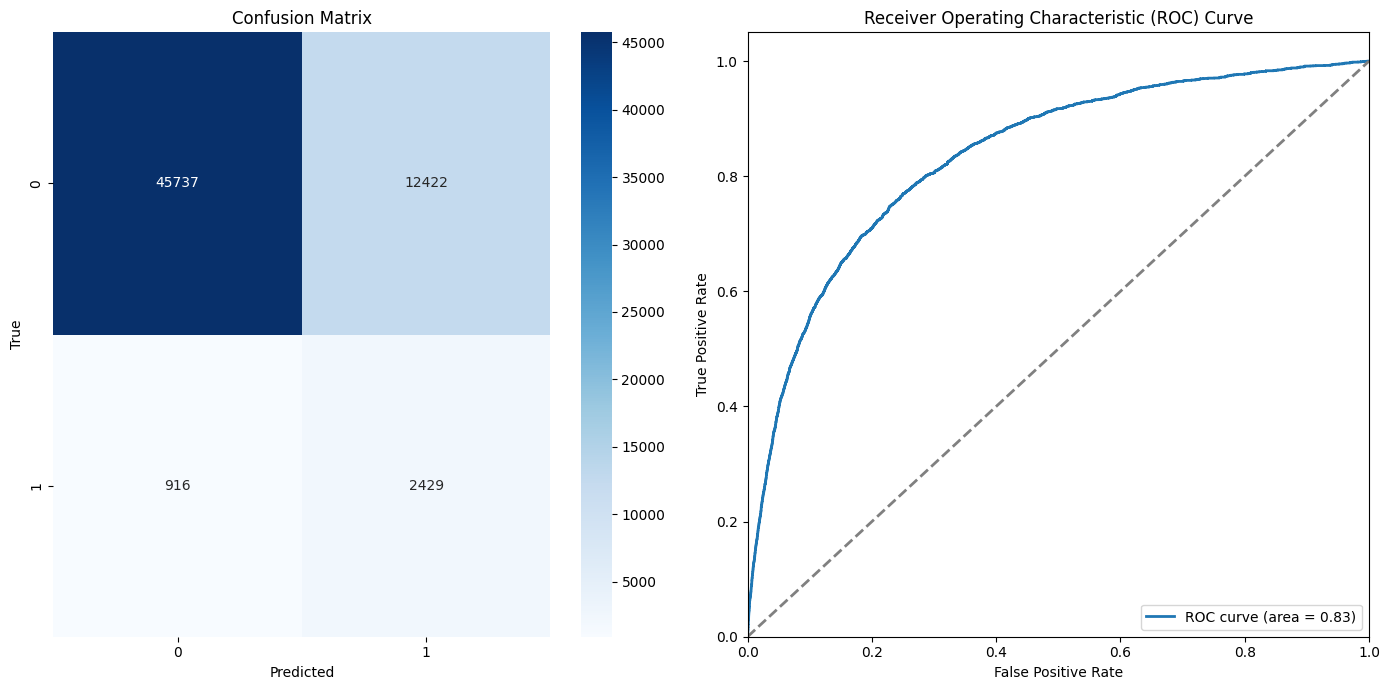

------- Sklearn Classification Report ------- 

              precision    recall  f1-score   support

           0       0.98      0.79      0.87     58159
           1       0.16      0.73      0.27      3345

    accuracy                           0.78     61504
   macro avg       0.57      0.76      0.57     61504
weighted avg       0.94      0.78      0.84     61504



In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Normalizza i dati
scaler = StandardScaler()
X_train = scaler.fit_transform(X_upsampled_train)
X_test = scaler.transform(X_test)

# Definisci il modello
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)

# Addestra il modello
mlp.fit(X_train, y_upsampled_train)

# Predizioni
y_pred = mlp.predict(X_test)

plot_confusion_matrix_and_roc(mlp, X_test, y_test, y_pred, mlp.predict_proba(X_test)[:,1])

print("------- Sklearn Classification Report ------- \n")
print(classification_report(y_test, y_pred))


Successivamente, abbiamo definito una ricerca casuale (randomized search) per ottimizzare i parametri della nostra rete neurale. I parametri esplorati durante questa ricerca sono stati specificati nel seguente spazio dei parametri: parameter_space = { 'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)], 'activation': ['tanh', 'relu'], 'solver': ['sgd', 'adam'], 'alpha': uniform(0.0001, 0.05), 'learning_rate': ['constant', 'adaptive'] }. Questa configurazione ci ha permesso di esplorare diverse architetture per i livelli nascosti (con 3 layer di 50 neuroni ciascuno, 50-100-50 neuroni, e un singolo layer di 100 neuroni), diverse funzioni di attivazione (tanh e relu), solutori (sgd e adam), valori di regolarizzazione L2 (alpha variabile uniformemente tra 0.0001 e 0.05), e schemi di apprendimento (constant e adaptive). Abbiamo scelto di utilizzare una ricerca casuale invece di una ricerca esaustiva (grid search) per risparmiare risorse computazionali, dato che la randomized search esplora una sottosezione casuale dello spazio dei parametri, riducendo significativamente il tempo di calcolo richiesto rispetto a testare tutte le possibili combinazioni in una grid search

In [ ]:
from sklearn.model_selection import  GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

#### GRID SEARCH SU PARAMETRI RETE NEURALE

Best parameters found:
 {'activation': 'relu', 'alpha': 0.03746600550686905, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}


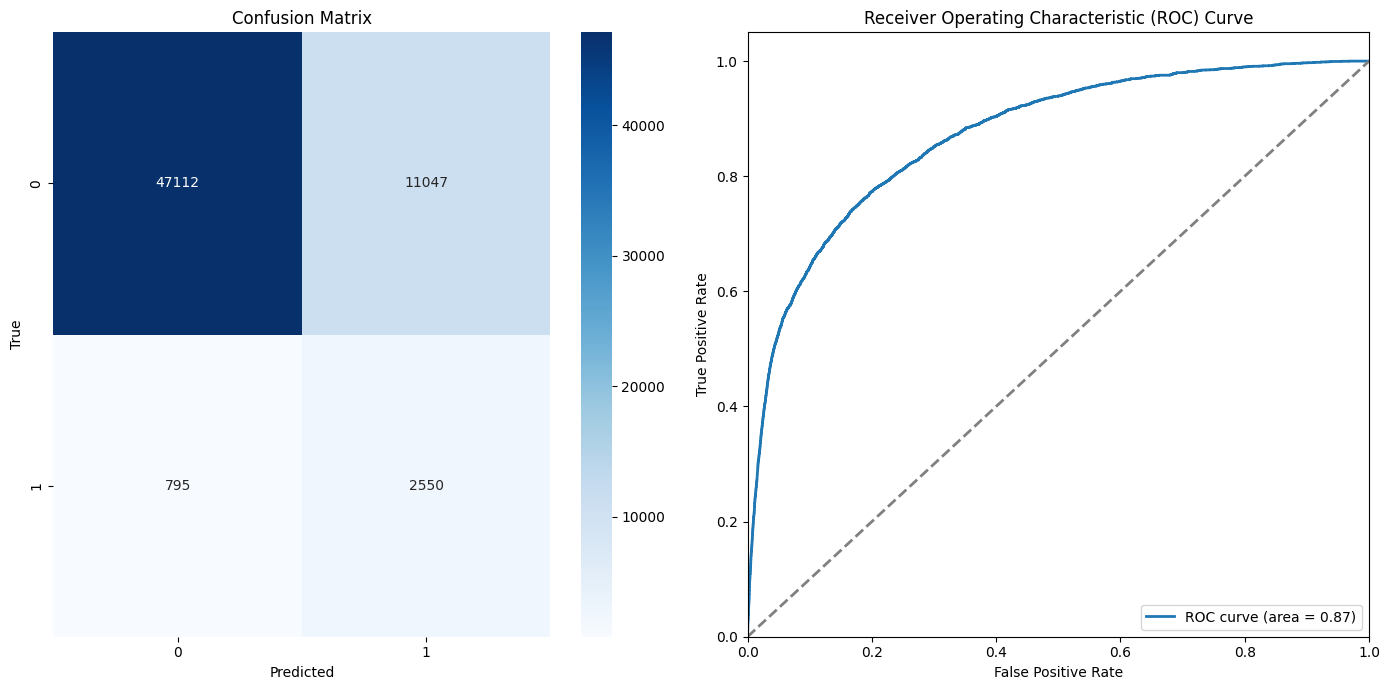

              Metric     Value
0       F1 Score Std  0.301027
1  F1 Score Weighted  0.856410
2           Accuracy  0.807460
3             Recall  0.762332


In [ ]:
# Definizione del modello con parametri base

mlp = MLPClassifier(max_iter=500, random_state=42)

# Definizione dei parametri per la Randomized Search
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': uniform(0.0001, 0.05),
    'learning_rate': ['constant', 'adaptive'],
}

# Randomized Search con 5-fold Cross-Validation
clf = RandomizedSearchCV(mlp, parameter_space, n_iter=30, n_jobs=-1, cv=5, random_state=42)
clf.fit(X_upsampled_train, y_upsampled_train)

# Best parameters from Randomized Search
print('Best parameters found:\n', clf.best_params_)

y_pred = clf.predict(X_test)

plot_confusion_matrix_and_roc(mlp, X_test, y_test, y_pred, clf.predict_proba(X_test)[:,1])

print("------- Sklearn Classification Report ------- \n")
print(classification_report(y_test, y_pred))

In dettaglio, i parametri migliori trovati sono:

	•	activation: 'relu', che indica l’uso della funzione di attivazione Rectified Linear Unit, una scelta comune per le reti neurali grazie alla sua capacità di mitigare il problema del gradiente vanescente e favorire una convergenza più rapida.
	•	alpha: 0.03746600550686905, che rappresenta il coefficiente di regolarizzazione L2. Questo valore relativamente alto rispetto ai valori di default suggerisce una maggiore penalizzazione per pesi di grandi dimensioni, aiutando a prevenire l’overfitting.
	•	hidden_layer_sizes: (100), che indica una rete neurale con un singolo livello nascosto contenente 100 neuroni. Questa configurazione è relativamente semplice ma efficace, permettendo alla rete di apprendere rappresentazioni significative dei dati senza diventare eccessivamente complessa.
	•	learning_rate: 'constant', che utilizza un tasso di apprendimento fisso durante tutto il processo di addestramento. Questa scelta, in combinazione con il solutore adam, consente una convergenza stabile.
	•	solver: 'adam', che si riferisce all’algoritmo di ottimizzazione Adam, noto per la sua efficienza e capacità di adattarsi dinamicamente al tasso di apprendimento, rendendolo ideale per una vasta gamma di problemi di apprendimento.

Questi parametri ottimizzati riflettono un buon equilibrio tra semplicità e capacità di apprendimento, fornendo una configurazione efficace per la nostra rete neurale nella risoluzione del problema in esame.

## Ensemble Learning & Voting Classifiers

#### Voting Classifier

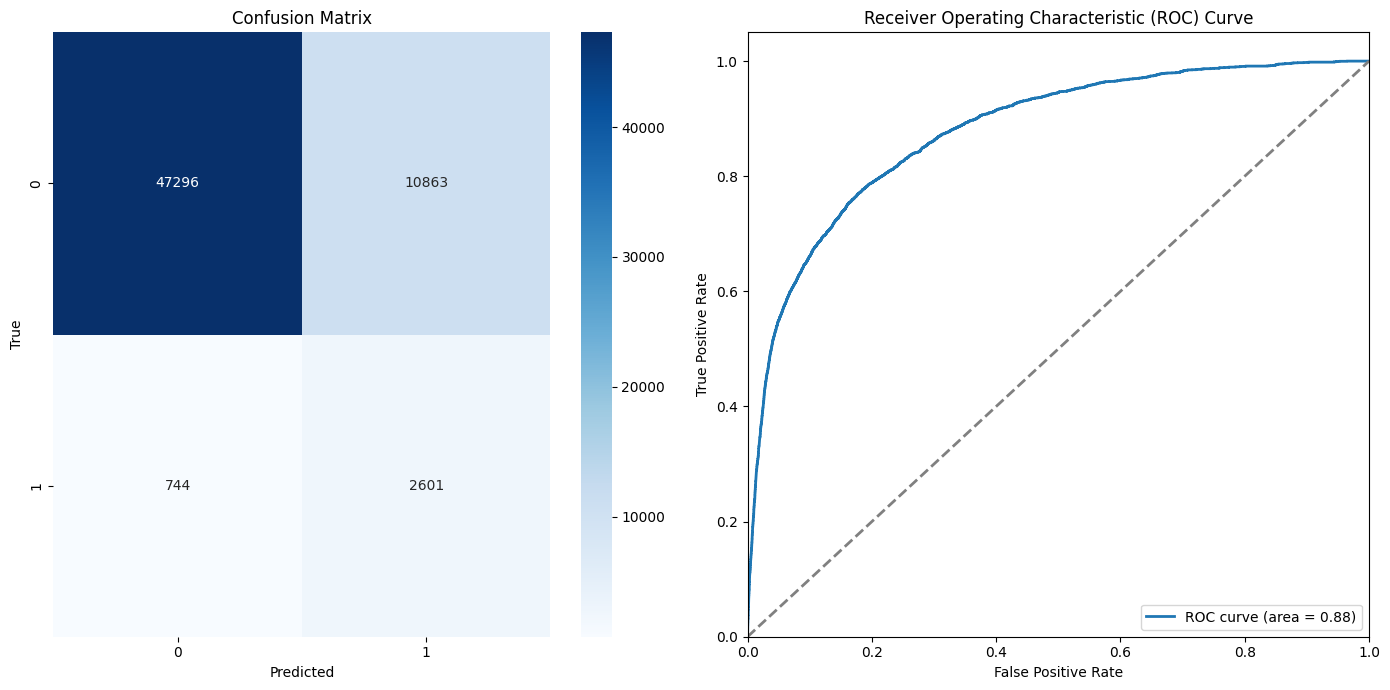

------- Sklearn Classification Report ------- 

              precision    recall  f1-score   support

           0       0.98      0.81      0.89     58159
           1       0.19      0.78      0.31      3345

    accuracy                           0.81     61504
   macro avg       0.59      0.80      0.60     61504
weighted avg       0.94      0.81      0.86     61504



In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

#Best parameters: {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
log_clf_ens = LogisticRegression(C = 0.01, max_iter = 100, penalty = "l2", solver = "liblinear", random_state = 42)

#Best parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
rnd_clf_ens = RandomForestClassifier(max_depth = 30, min_samples_leaf = 1, min_samples_split= 2, n_estimators= 200, random_state = 42)

#Best parameters: {'loss': 'log_loss', 'max_iter': 1000, 'penalty': 'l1'}
sgd_clf_ens = SGDClassifier(loss = 'log_loss', max_iter = 1000, penalty = 'l1', random_state = 42)

mlp_ann_ens = MLPClassifier(activation='relu', alpha=0.03746600550686905, hidden_layer_sizes=(100,), learning_rate='constant', solver='adam', random_state=42)

voting_clf_soft = VotingClassifier(
    estimators=[('lr', log_clf_ens), ('rf', rnd_clf_ens), ('sgd', sgd_clf_ens), ('ann', mlp_ann_ens)],
    voting='soft')

voting_clf_soft.fit(X_upsampled_train, y_upsampled_train)

y_pred = voting_clf_soft.predict(X_test)

#Visualizza matrice di confusione e curva ROC
plot_confusion_matrix_and_roc(voting_clf_soft, X_test, y_test, y_pred, voting_clf_soft.predict_proba(X_test)[:,1])

print("------- Sklearn Classification Report ------- \n")
print(classification_report(y_test, y_pred))

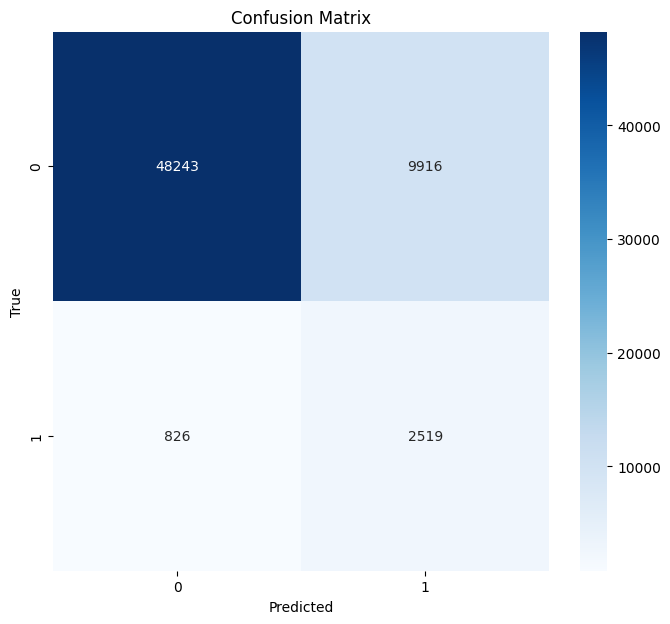

------- Sklearn Classification Report ------- 

              precision    recall  f1-score   support

           0       0.98      0.83      0.90     58159
           1       0.20      0.75      0.32      3345

    accuracy                           0.83     61504
   macro avg       0.59      0.79      0.61     61504
weighted avg       0.94      0.83      0.87     61504



In [ ]:
voting_clf_hard = VotingClassifier(
    estimators=[('lr', log_clf_ens), ('rf', rnd_clf_ens), ('sgd', sgd_clf_ens), ('ann', mlp_ann_ens)],
    voting='hard')

voting_clf_hard.fit(X_upsampled_train, y_upsampled_train)

y_pred = voting_clf_hard.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plot_Confusion_matrix(cm)

print("------- Sklearn Classification Report ------- \n")
print(classification_report(y_test, y_pred))

#### XG Boost Classification

XGBoost: Utilizza il concetto di boosting, dove vengono addestrati molti modelli deboli in sequenza. Ogni modello successivo mira a correggere gli errori residui dei modelli precedenti. XGBoost ottimizza direttamente una funzione di perdita regolarizzata, utilizzando alberi decisionali come modelli deboli di default.

Validation error: 0.11932557232049948
Results for XG Boost Classification without early stopping rule



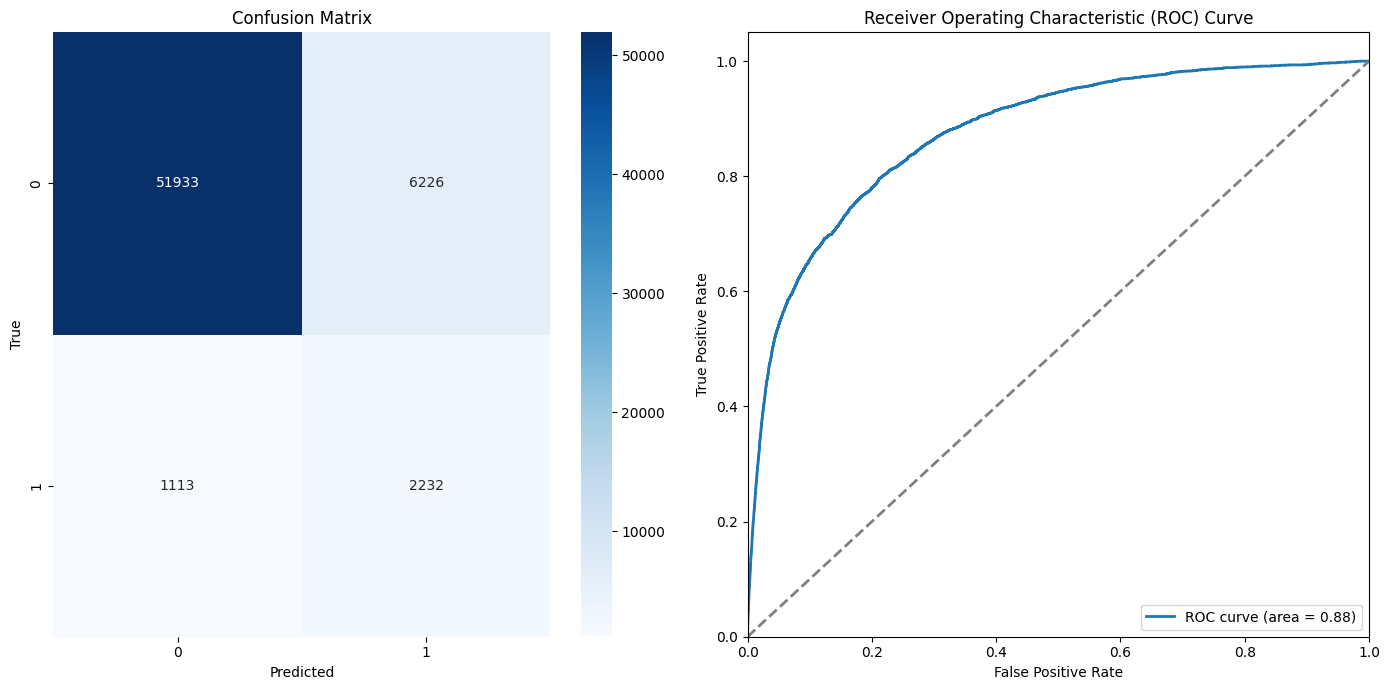

------- Sklearn Classification Report ------- 

              precision    recall  f1-score   support

           0       0.98      0.89      0.93     58159
           1       0.26      0.67      0.38      3345

    accuracy                           0.88     61504
   macro avg       0.62      0.78      0.66     61504
weighted avg       0.94      0.88      0.90     61504



In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# XGBoost without early stopping rule

xgb_reg_clf = xgb.XGBClassifier(random_state=42)
xgb_reg_clf.fit(X_upsampled_train, y_upsampled_train)

y_pred = xgb_reg_clf.predict(X_test)

val_error = mean_squared_error(y_test, y_pred)
print(f"Validation error: {val_error}")

print(f"Results for XG Boost Classification without early stopping rule\n")

#Visualizza matrice di confusione e curva ROC
plot_confusion_matrix_and_roc(xgb_reg_clf, X_test, y_test, y_pred, xgb_reg_clf.predict_proba(X_test)[:,1])

print("------- Sklearn Classification Report ------- \n")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.58190
[1]	validation_0-logloss:0.51930
[2]	validation_0-logloss:0.47728
[3]	validation_0-logloss:0.45201
[4]	validation_0-logloss:0.43452
[5]	validation_0-logloss:0.42025
[6]	validation_0-logloss:0.41030
[7]	validation_0-logloss:0.40140
[8]	validation_0-logloss:0.39635
[9]	validation_0-logloss:0.39137
[10]	validation_0-logloss:0.38788
[11]	validation_0-logloss:0.38200
[12]	validation_0-logloss:0.37868
[13]	validation_0-logloss:0.37158
[14]	validation_0-logloss:0.37043
[15]	validation_0-logloss:0.36539
[16]	validation_0-logloss:0.36096
[17]	validation_0-logloss:0.35855
[18]	validation_0-logloss:0.35734
[19]	validation_0-logloss:0.35595
[20]	validation_0-logloss:0.35369
[21]	validation_0-logloss:0.35204
[22]	validation_0-logloss:0.34994
[23]	validation_0-logloss:0.34769
[24]	validation_0-logloss:0.34570
[25]	validation_0-logloss:0.34477
[26]	validation_0-logloss:0.34321
[27]	validation_0-logloss:0.34237
[28]	validation_0-logloss:0.34217
[29]	validation_0-loglos

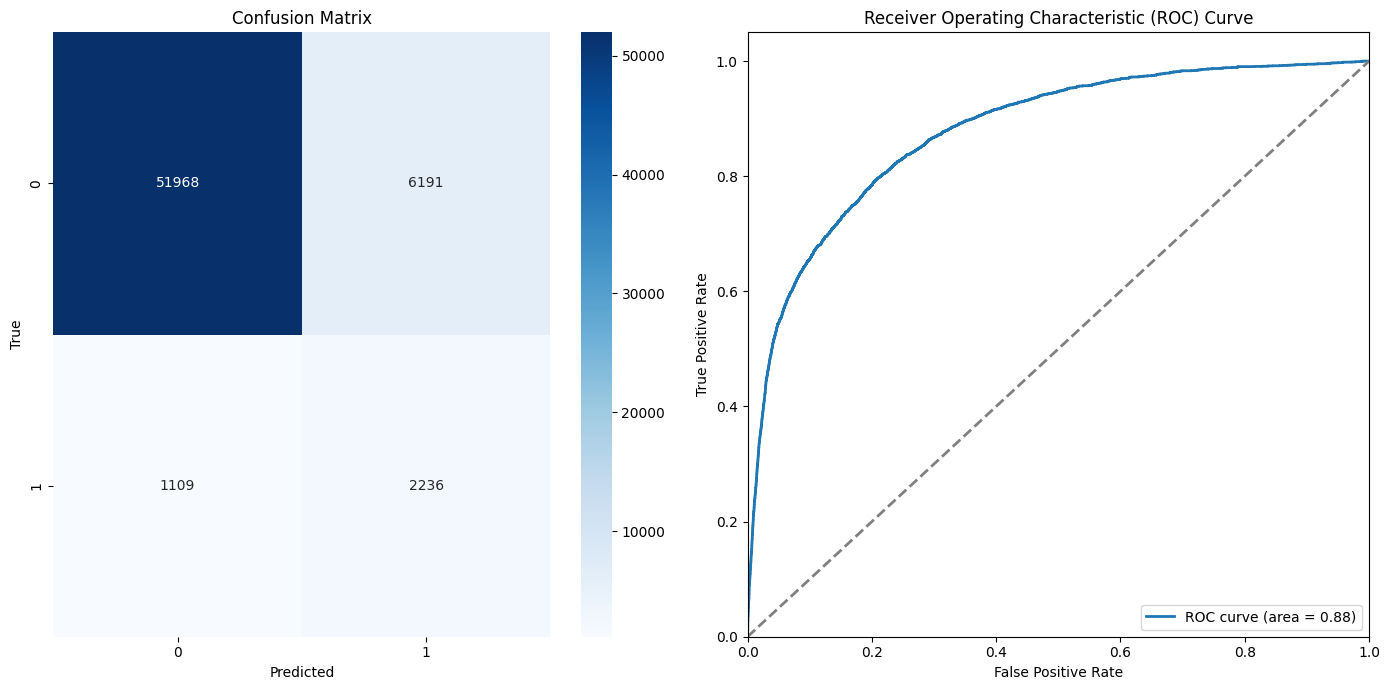

------- Sklearn Classification Report ------- 

              precision    recall  f1-score   support

           0       0.98      0.89      0.93     58159
           1       0.27      0.67      0.38      3345

    accuracy                           0.88     61504
   macro avg       0.62      0.78      0.66     61504
weighted avg       0.94      0.88      0.90     61504



In [ ]:
# XGBoost w/ early stopping rule

xgb_reg_clf.fit(X_upsampled_train, y_upsampled_train, eval_set=[(X_test, y_test)], early_stopping_rounds=4)
y_pred = xgb_reg_clf.predict(X_test)

val_error = mean_squared_error(y_test, y_pred)
print(f"Validation error: {val_error}")

print(f"Results for XG Boost Classification WITH early stopping rule\n")

#Visualizza matrice di confusione e curva ROC
plot_confusion_matrix_and_roc(xgb_reg_clf, X_test, y_test, y_pred, xgb_reg_clf.predict_proba(X_test)[:,1])

print("------- Sklearn Classification Report ------- \n")
print(classification_report(y_test, y_pred))

#TASK 2: DATA IMPUTATION

In [ ]:
df_withNanCopy.head()

State     Sex GeneralHealth  PhysicalHealthDays  MentalHealthDays  \
0  Alabama  Female     Very good                 0.0               0.0   
1  Alabama  Female     Excellent                 0.0               0.0   
2  Alabama  Female     Very good                 2.0               3.0   
3  Alabama  Female     Excellent                 0.0               0.0   
4  Alabama  Female          Fair                 2.0               0.0   

                                     LastCheckupTime PhysicalActivities  \
0  Within past year (anytime less than 12 months ...                 No   
1                                                NaN                 No   
2  Within past year (anytime less than 12 months ...                Yes   
3  Within past year (anytime less than 12 months ...                Yes   
4  Within past year (anytime less than 12 months ...                Yes   

   SleepHours RemovedTeeth HadHeartAttack  ... HeightInMeters  \
0         8.0          NaN             No  ...            NaN   
1         6.0          NaN             No  ...           1.60   
2         5.0          NaN             No  ...           1.57   
3         7.0          NaN             No  ...           1.65   
4         9.0          NaN             No  ...           1.57   

  WeightInKilograms    BMI AlcoholDrinkers HIVTesting FluVaxLast12  \
0               NaN    NaN              No         No          Yes   
1             68.04  26.57              No         No           No   
2             63.50  25.61              No         No           No   
3             63.50  23.30              No         No          Yes   
4             53.98  21.77             Yes         No           No   

  PneumoVaxEver                                  TetanusLast10Tdap  \
0            No  Yes, received tetanus shot but not sure what type   
1            No  No, did not receive any tetanus shot in the pa...   
2            No                                                NaN   
3           Yes  No, did not receive any tetanus shot in the pa...   
4           Yes  No, did not receive any tetanus shot in the pa...   

  HighRiskLastYear CovidPos  
0               No       No  
1               No       No  
2               No      Yes  
3               No       No  
4               No       No  

[5 rows x 40 columns]

In [ ]:
df_withNanCopy.shape

(444975, 40)

Dopo aver completato la fase precedente con un dataset ripulito da tutte le istanze che possedevano valori Nan, procediamo ora ripristinando il dataset originale(da backup precedentemente fatto) rimpiazzando tutti valori Nan facendo data imputation. Questo passaggio ci consentirà di valutare se i risultati ottenuti saranno in linea con quelli precedenti, e di verificare se l'intervento per sostituire i valori mancanti avrà un impatto significativo sull'analisi dei dati.

In [ ]:
df_withNan = df_withNanCopy.copy()

# Calcola il numero di valori nulli per ogni riga
null_counts_per_row = df_withNan.isnull().sum(axis=1)

# Calcola la soglia per considerare una riga come contenente un numero elevato di valori nulli
threshold = int(0.30 * df_withNan.shape[1])

# Conta quante righe hanno un numero di valori nulli superiore alla soglia
rows_with_high_nulls = (null_counts_per_row > threshold).sum()

# Visualizza il numero di righe con un numero elevato di valori nulli
print("Numero di righe con più del 30% di valori nulli:", rows_with_high_nulls)

# Elimina tutte le istanze che hanno più del 30% di valori nulli
df_withNan = df_withNan[df_withNan.isnull().sum(axis=1) <= threshold]

# Visualizza il numero di righe dopo l'eliminazione
print("Numero di righe dopo l'eliminazione:", df_withNan.shape[0])

Numero di righe con più del 30% di valori nulli: 24170
Numero di righe dopo l'eliminazione: 420805


In [ ]:
#Visualizza il numero di istanze prima dell'eliminazione
print("Numero di righe originali PRE:", df_withNan.shape[0])

# Elimina le righe dove 'HadHeartAttack' è NaN
df_withNan= df_withNan.dropna(subset=['HadHeartAttack'])

#Visualizza il numero di istanze dopo l'eliminazione
print("Numero di righe originali POST:", df_withNan.shape[0])

Numero di righe originali PRE: 420805
Numero di righe originali POST: 418265


TetanusLast10Tdap            13.822098
PneumoVaxEver                12.541571
HIVTesting                    9.934850
ChestScan                     7.542826
BMI                           6.838966
CovidPos                      6.308680
HighRiskLastYear              6.276643
WeightInKilograms             5.469977
FluVaxLast12                  5.434593
AlcoholDrinkers               5.305488
RaceEthnicityCategory         2.854410
ECigaretteUsage               2.749692
SmokerStatus                  2.713113
RemovedTeeth                  2.379353
PhysicalHealthDays            2.305476
HeightInMeters                2.275830
MentalHealthDays              1.913858
LastCheckupTime               1.741958
AgeCategory                   1.701075
SleepHours                    1.115322
HadAngina                     0.803318
DifficultyConcentrating       0.638590
HadSkinCancer                 0.615877
DifficultyErrands             0.610857
HadDepressiveDisorder         0.522396
HadArthritis             

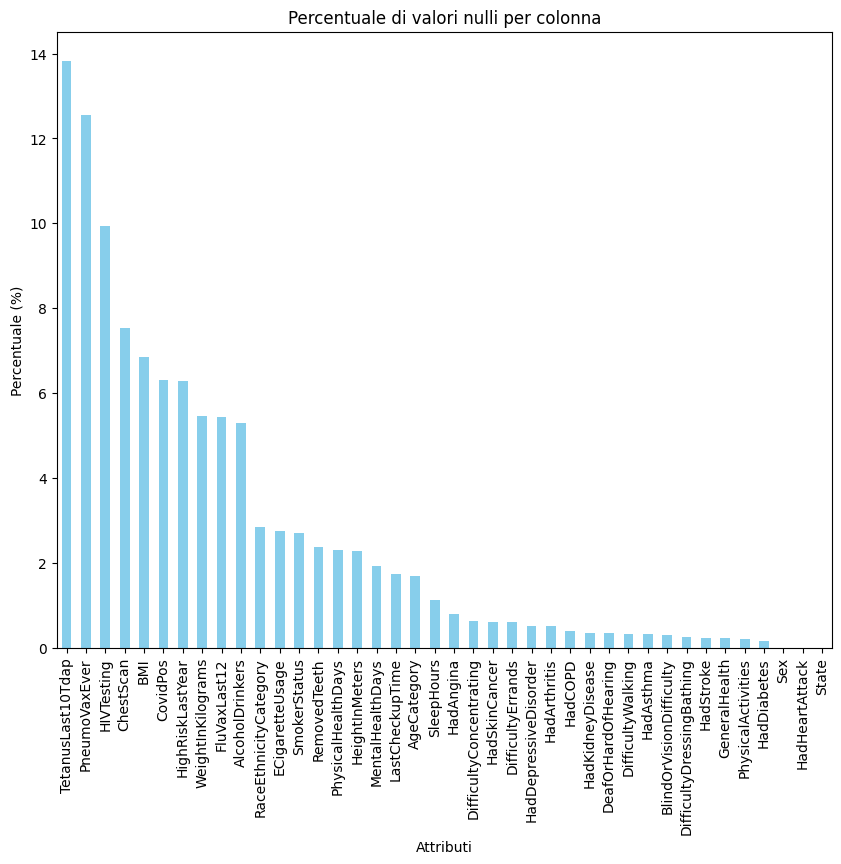

In [ ]:
percentualeNan(df_withNan)

Tra le tecniche disponibili in contrapposizione ai metodi di eliminazione dei dati ci sono metodi di imputazione. Il metodo di imputazione più semplice consiste nel sostituire i valori mancanti con i valori medi o mediani del set di dati in generale, o con una statistica di riepilogo simile.

Questo ha il vantaggio di essere l'approccio più semplice possibile e di non introdurre pregiudizi indebiti nel set di dati.

In [ ]:
# Calcola la mediana per ciascuna delle colonne interessate
median_physical_health_days = df_withNan['PhysicalHealthDays'].median()
median_mental_health_days = df_withNan['MentalHealthDays'].median()
median_sleep_hours = df_withNan['SleepHours'].median()

# Riempie i valori nulli con la mediana calcolata
df_withNan['PhysicalHealthDays'].fillna(median_physical_health_days, inplace=True)
df_withNan['MentalHealthDays'].fillna(median_mental_health_days, inplace=True)
df_withNan['SleepHours'].fillna(median_sleep_hours, inplace=True)

Per la feature 'WeightInKilograms' ed 'HeightInMeters' andiamo a riempire gli elementi Nan con la media.
Tuttavia sappiamo che misure campionarie come la media possono essere fortemente influenzate dai cosiddetti **outlier**.
Per evitare perciò di avere una media "contaminata" da questi valori non rappresentativi della popolazione andiamo a considerare la cosiddetta **Media Troncata**, la quale settata al 10% escluderà il 10% dei valori più bassi e il 10% dei valori più alti.

Poiché inoltre sappiamo che tra donna e uomo ci siano forti differenze nella corporatura andiamo a fare due riempimenti separati in base al sesso della persona.

In [ ]:
# Percentuale di valori da tagliare
proportion_to_cut = 0.10

# Calcolo della media troncata per il peso e l'altezza delle donne
trimmed_mean_weight_female = trim_mean(df_withNan[df_withNan['Sex'] == 'Female']['WeightInKilograms'].dropna(), proportion_to_cut)
trimmed_mean_height_female = trim_mean(df_withNan[df_withNan['Sex'] == 'Female']['HeightInMeters'].dropna(), proportion_to_cut)

# Calcolo della media troncata per il peso e l'altezza degli uomini
trimmed_mean_weight_male = trim_mean(df_withNan[df_withNan['Sex'] == 'Male']['WeightInKilograms'].dropna(), proportion_to_cut)
trimmed_mean_height_male = trim_mean(df_withNan[df_withNan['Sex'] == 'Male']['HeightInMeters'].dropna(), proportion_to_cut)

# Riempimento dei valori nulli nella colonna del peso per le donne
df_withNan.loc[(df_withNan['Sex'] == 'Female') & (df_withNan['WeightInKilograms'].isnull()), 'WeightInKilograms'] = trimmed_mean_weight_female

# Riempimento dei valori nulli nella colonna dell'altezza per le donne
df_withNan.loc[(df_withNan['Sex'] == 'Female') & (df_withNan['HeightInMeters'].isnull()), 'HeightInMeters'] = trimmed_mean_height_female

# Riempimento dei valori nulli nella colonna del peso per gli uomini
df_withNan.loc[(df_withNan['Sex'] == 'Male') & (df_withNan['WeightInKilograms'].isnull()), 'WeightInKilograms'] = trimmed_mean_weight_male

# Riempimento dei valori nulli nella colonna dell'altezza per gli uomini
df_withNan.loc[(df_withNan['Sex'] == 'Male') & (df_withNan['HeightInMeters'].isnull()), 'HeightInMeters'] = trimmed_mean_height_male

# Visualizza le medie troncate calcolate
print("Trimmed mean weight for females:", trimmed_mean_weight_female)
print("Trimmed mean height for females:", trimmed_mean_height_female)
print("Trimmed mean weight for males:", trimmed_mean_weight_male)
print("Trimmed mean height for males:", trimmed_mean_height_male)

Trimmed mean weight for females: 73.81065325800931
Trimmed mean height for females: 1.6325880074453338
Trimmed mean weight for males: 89.01096769984538
Trimmed mean height for males: 1.781170095054451


Prima di andare ad utilizzare la formula del BMI per calcolare i valori mancanti della stessa feature andiamo a verificare la distribuzione dei dati prima dell'imputazione e successivi all'imputazione. Distribuzioni simili mostrano come abbiamo condotto un buon processo di imputazione

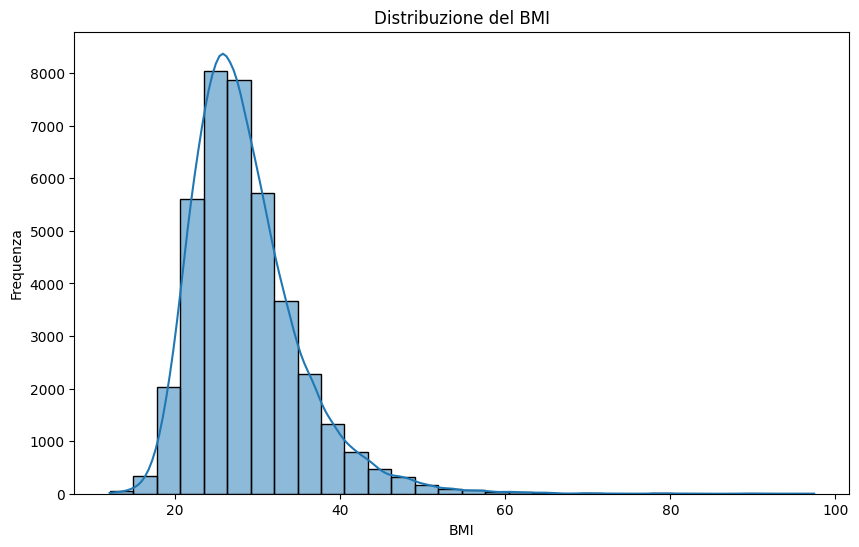

In [ ]:
# Prendere un campione del 10% del dataset
sample_df = df_withNan.sample(frac=0.1, random_state=42)

# Creare un istogramma per la distribuzione del BMI
plt.figure(figsize=(10, 6))
sns.histplot(sample_df['BMI'], bins=30, kde=True)
plt.title('Distribuzione del BMI')
plt.xlabel('BMI')
plt.ylabel('Frequenza')
plt.show()

In [ ]:

def calculate_bmi(row):
    weight = row['WeightInKilograms']
    height = row['HeightInMeters']
    if pd.notnull(weight) and pd.notnull(height) and height > 0:
        return weight / (height ** 2)
    else:
        return np.nan

# Applica la funzione alla colonna BMI solo per le righe con valori NaN nella colonna BMI
df_withNan.loc[df_withNan['BMI'].isnull(), 'BMI'] = df_withNan[df_withNan['BMI'].isnull()].apply(calculate_bmi, axis=1)

# Verifica il risultato
print(df_withNan['BMI'].isnull().sum())

0


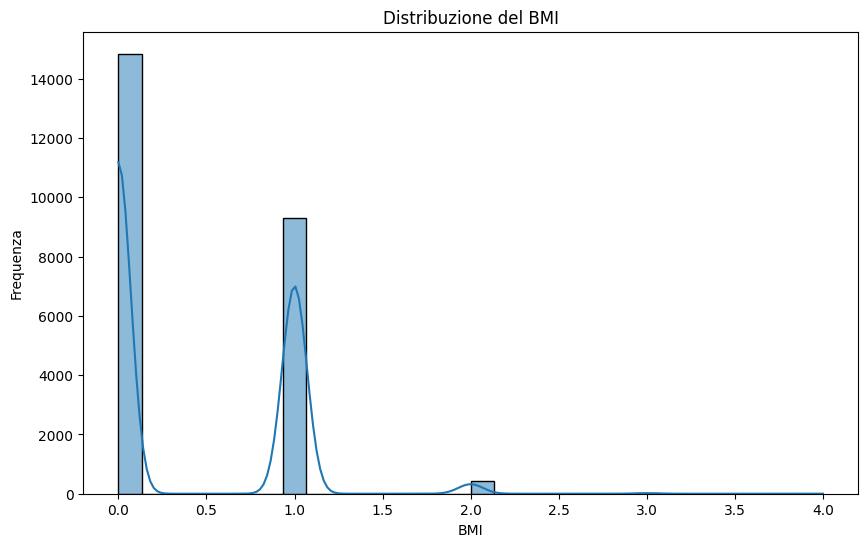

In [ ]:
# Prendere un campione del 10% del dataset
sample_df = df.sample(frac=0.1, random_state=42)

# Creare un istogramma per la distribuzione del BMI
plt.figure(figsize=(10, 6))
sns.histplot(sample_df['BMI'], bins=30, kde=True)
plt.title('Distribuzione del BMI')
plt.xlabel('BMI')
plt.ylabel('Frequenza')
plt.show()

Come possiamo notare le features rimanenti che possiedono valori Nan sono solo features di tipo Object, procediamo perciò con la scelta di utilizzare la moda per riempire i valori mancanti nelle colonne che hanno una soglia di riempimento maggiore del 90%,l'idea è basata sull'efficacia e semplicità di questo approccio per gestire un basso livello di dati mancanti.

In [ ]:
threshold = 0.1

# Trova le colonne che hanno meno del 10% di valori nulli
columns_to_fill_mode = [col for col in df_withNan.columns if df_withNan[col].isnull().mean() < threshold]

# Riempie le colonne selezionate con la moda
for col in columns_to_fill_mode:
    if df_withNan[col].isnull().any():
        mode_value = df_withNan[col].mode()[0]  # Trova la moda
        df_withNan[col].fillna(mode_value, inplace=True)

TetanusLast10Tdap            13.822098
PneumoVaxEver                12.541571
State                         0.000000
AgeCategory                   0.000000
DifficultyWalking             0.000000
DifficultyDressingBathing     0.000000
DifficultyErrands             0.000000
SmokerStatus                  0.000000
ECigaretteUsage               0.000000
ChestScan                     0.000000
RaceEthnicityCategory         0.000000
HeightInMeters                0.000000
Sex                           0.000000
WeightInKilograms             0.000000
BMI                           0.000000
AlcoholDrinkers               0.000000
HIVTesting                    0.000000
FluVaxLast12                  0.000000
HighRiskLastYear              0.000000
DifficultyConcentrating       0.000000
BlindOrVisionDifficulty       0.000000
DeafOrHardOfHearing           0.000000
HadHeartAttack                0.000000
GeneralHealth                 0.000000
PhysicalHealthDays            0.000000
MentalHealthDays         

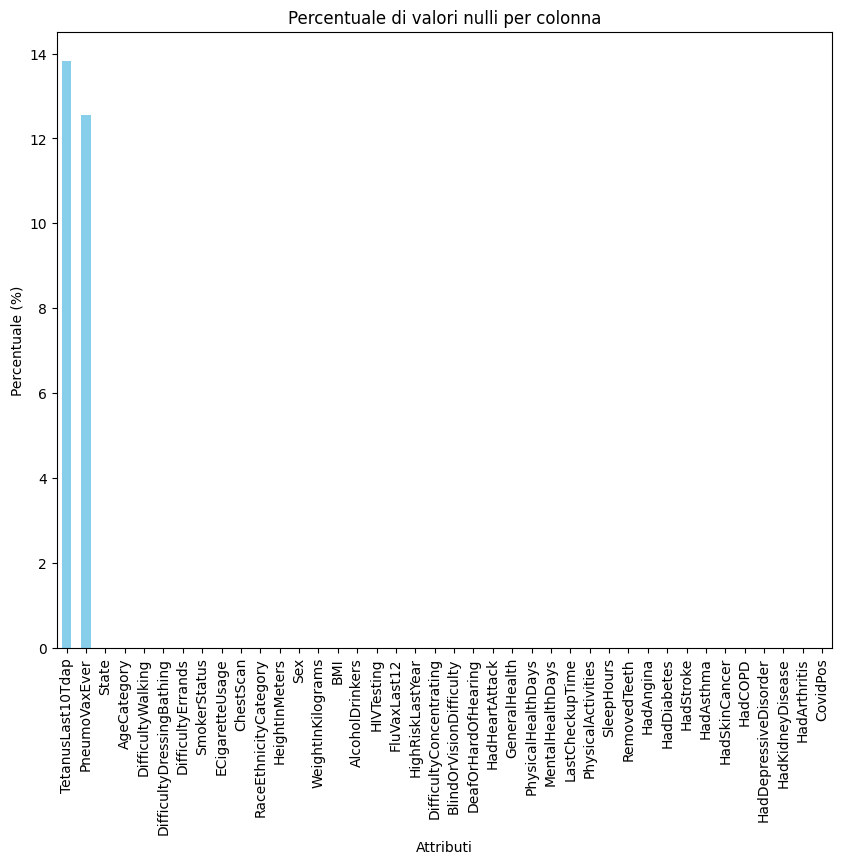

In [ ]:
percentualeNan(df_withNan)

Nel nostro dataset rimangono così solo due feature che continuano ad avere valori Nan: TetanusLast10Tdap e PneumoVaxEver. Prima di procedere con l’imputazione convertiamo tutte le variabili categoriche in variabili numeriche utilizzando codifiche opportune . Successivamente utilizzeremo la tecnologia MICE(Multiple Imputation by Chained Equations) per imputare i valori mancanti nella colonna PneumoVaxEver e TetanusLast10Tdap.

MICE per ogni variabile con valori mancanti, MICE modella il valore mancante come una funzione delle altre variabili nel dataset.Dopo aver previsto i valori mancanti per una variabile, questi valori vengono utilizzati come input per le successive iterazioni e imputazioni delle altre variabili.

In [ ]:
df_withNan['CovidPos'] = df_withNan['CovidPos'].replace('Tested positive using home test without a health professional', 'Yes')
value_counts = df_withNan['CovidPos'].value_counts(dropna=False)


df_withNan['HadDiabetes'] = df_withNan['HadDiabetes'].replace('Yes, but only during pregnancy (female)', 'No')

df_withNan['TetanusLast10Tdap'] = df_withNan['TetanusLast10Tdap'].replace({
    'Yes, received tetanus shot but not sure what type': 'Yes',
    'Yes, received Tdap': 'Yes',
    'Yes, received tetanus shot, but not Tdap': 'Yes',
    'No, did not receive any tetanus shot in the past 10 years':'No'
})

Codifichiamo tenendo conto dei valori Nan

In [ ]:
binary_columns = [
    'HadHeartAttack','PhysicalActivities', 'HadAngina', 'HadStroke', 'HadAsthma',
    'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease',
    'HadArthritis', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
    'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing',
    'DifficultyErrands', 'AlcoholDrinkers', 'CovidPos','FluVaxLast12','PneumoVaxEver',
    'HIVTesting','TetanusLast10Tdap','HighRiskLastYear','ChestScan'
]

encoder = LabelEncoder()

for col in binary_columns:
    if df_withNan[col].dtype == 'object':
        # Sostituisci temporaneamente NaN con 'missing'
        df_withNan[col] = df_withNan[col].fillna('missing')
        encoder.fit(['No', 'Yes', 'missing'])  # Include 'missing' nei valori da codificare
        df_withNan[col] = encoder.transform(df_withNan[col].astype(str))
        # Ripristina i valori NaN
        df_withNan[col] = df_withNan[col].replace(encoder.transform(['missing'])[0], pd.NA)

# Codifica della colonna 'Sex'
encoder.fit(['Female','Male'])
df_withNan['Sex']=encoder.transform(df_withNan['Sex'].astype(str))

# Verifica finale per assicurarsi che non ci siano più valori 'missing'
print(df_withNan.isnull().sum())

State                            0
Sex                              0
GeneralHealth                    0
PhysicalHealthDays               0
MentalHealthDays                 0
LastCheckupTime                  0
PhysicalActivities               0
SleepHours                       0
RemovedTeeth                     0
HadHeartAttack                   0
HadAngina                        0
HadStroke                        0
HadAsthma                        0
HadSkinCancer                    0
HadCOPD                          0
HadDepressiveDisorder            0
HadKidneyDisease                 0
HadArthritis                     0
HadDiabetes                      0
DeafOrHardOfHearing              0
BlindOrVisionDifficulty          0
DifficultyConcentrating          0
DifficultyWalking                0
DifficultyDressingBathing        0
DifficultyErrands                0
SmokerStatus                     0
ECigaretteUsage                  0
ChestScan                        0
RaceEthnicityCategor

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
# Applicazione del one-hot encoding alle feature specifiche
df_withNan = pd.get_dummies(df_withNan, columns=['State','RaceEthnicityCategory'])

# Identifica le colonne di tipo booleano
boolean_columns = df_withNan.select_dtypes(include=['bool']).columns
for col in boolean_columns:
    df_withNan[col] = df_withNan[col].astype(int)



# Definire l'ordine dei valori per la codifica ordinale
ECigarette_order = ['Never used e-cigarettes in my entire life', 'Not at all (right now)', 'Use them some days', 'Use them every day']
ordinal_encoder = OrdinalEncoder(categories=[ECigarette_order])

# Codificare la feature EcigaretteUsage
df_withNan['ECigaretteUsage'] = ordinal_encoder.fit_transform(df_withNan[['ECigaretteUsage']])

# Definire l'ordine dei valori per la codifica ordinale
SmokerSatus_order = ['Never smoked', 'Former smoker', 'Current smoker - now smokes some days', 'Current smoker - now smokes every day']
ordinal_encoder = OrdinalEncoder(categories=[SmokerSatus_order])

# Codificare la feature SmokerStatus
df_withNan['SmokerStatus'] = ordinal_encoder.fit_transform(df_withNan[['SmokerStatus']])

HadDiabetes_order = ['No', 'No, pre-diabetes or borderline diabetes', 'Yes']
ordinal_encoder = OrdinalEncoder(categories=[HadDiabetes_order])

# Codificare la feature HadDiabetes
df_withNan['HadDiabetes'] = ordinal_encoder.fit_transform(df_withNan[['HadDiabetes']])

health_order = ['Poor', 'Fair', 'Good', 'Very good', 'Excellent']
ordinal_encoder = OrdinalEncoder(categories=[health_order])

# Codificare la feature GeneralHealth
df_withNan['GeneralHealth'] = ordinal_encoder.fit_transform(df_withNan[['GeneralHealth']])

#--------------

checkup_order = [
    '5 or more years ago',
    'Within past 5 years (2 years but less than 5 years ago)',
    'Within past 2 years (1 year but less than 2 years ago)',
    'Within past year (anytime less than 12 months ago)'
]
ordinal_encoder = OrdinalEncoder(categories=[checkup_order])

# Codificare la feature LastCheckupTime
df_withNan['LastCheckupTime'] = ordinal_encoder.fit_transform(df_withNan[['LastCheckupTime']])

#--------------

teeth_order = [
    'None of them',
    '1 to 5',
    '6 or more, but not all',
    'All'
]
ordinal_encoder = OrdinalEncoder(categories=[teeth_order])

# Codificare la feature RemovedTeeth
df_withNan['RemovedTeeth'] = ordinal_encoder.fit_transform(df_withNan[['RemovedTeeth']])

#--------------

age_order = [
    'Age 18 to 24',
    'Age 25 to 29',
    'Age 30 to 34',
    'Age 35 to 39',
    'Age 40 to 44',
    'Age 45 to 49',
    'Age 50 to 54',
    'Age 55 to 59',
    'Age 60 to 64',
    'Age 65 to 69',
    'Age 70 to 74',
    'Age 75 to 79',
    'Age 80 or older'
]
ordinal_encoder = OrdinalEncoder(categories=[age_order])

# Codificare la feature AgeCategory
df_withNan['AgeCategory'] = ordinal_encoder.fit_transform(df_withNan[['AgeCategory']])

###Discretizziamo

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer

# Istanzia il discretizzatore
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')

# Applica il discretizzatore alla colonna 'BMI'
bmi_discretized = discretizer.fit_transform(df_withNan[['BMI']])

# Sostituisci la colonna 'BMI' con la colonna discretizzata
df_withNan['BMI'] = bmi_discretized

# Verifica i risultati
print(df_withNan[['BMI']].head())

   BMI
0  0.0
1  0.0
2  0.0
3  0.0
4  0.0


In [ ]:
# Istanzia il discretizzatore
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')

# Applica il discretizzatore alla colonna 'BMI'
physicalHealthDays_discretized = discretizer.fit_transform(df[['PhysicalHealthDays']])

# Sostituisci la colonna 'BMI' con la colonna discretizzata
df['PhysicalHealthDays'] = physicalHealthDays_discretized


In [ ]:
# Istanzia il discretizzatore
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')

# Applica il discretizzatore alla colonna 'BMI'
mentalHealthDays_discretized = discretizer.fit_transform(df[['MentalHealthDays']])

# Sostituisci la colonna 'BMI' con la colonna discretizzata
df['MentalHealthDays'] = mentalHealthDays_discretized


###Data Cleaning

In [ ]:
# Lista delle colonne da rimuovere che iniziano per 'State'
columns_to_remove = df_withNan.filter(regex=r'^State').columns

# Crea un nuovo DataFrame escludendo le colonne 'State'
df_withNan = df_withNan.drop(columns=columns_to_remove)
df_withNan = df_withNan.drop(columns=['WeightInKilograms', 'HeightInMeters'])

Prima di procedere con l'imputazione tramite previsione dei valori Nan è buona norma mostrare per confrontare successivamente la distribuzione delle due features da imputare

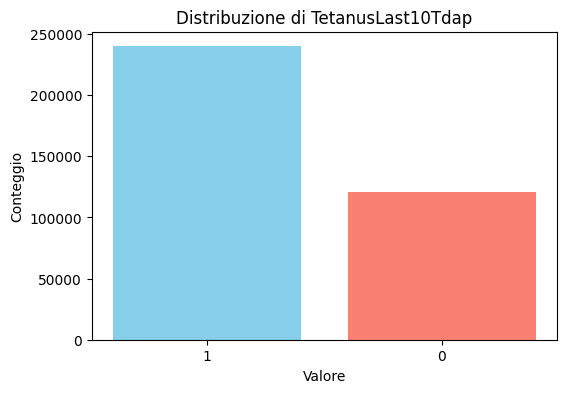

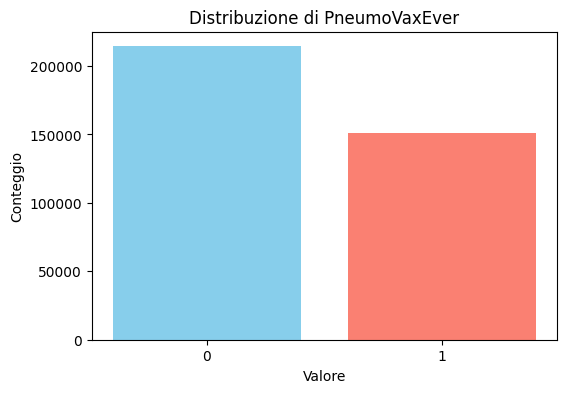

In [ ]:
def plot_binary_distribution(feature_name,df):
    counts = df[feature_name].value_counts()
    plt.figure(figsize=(6, 4))
    plt.bar(counts.index.astype(str), counts.values, color=['skyblue', 'salmon'])
    plt.title(f'Distribuzione di {feature_name.replace("_", " ")}')
    plt.xlabel('Valore')
    plt.ylabel('Conteggio')
    plt.show()

# Plot della distribuzione di TetanusLast10Tdap prima dell'imputazione
plot_binary_distribution('TetanusLast10Tdap',df_withNan)

# Plot della distribuzione di PneumoVaxEver prima dell'imputazione
plot_binary_distribution('PneumoVaxEver',df_withNan)

In [ ]:
X = df_withNan.apply(pd.to_numeric, errors='coerce')


# Rinomina le colonne per rimuovere spazi e caratteri speciali che non sono consentiti utilizzando MICE
X.columns = X.columns.str.replace(' ', '_').str.replace(',', '').str.replace('-', '_').str.replace('(', '').str.replace(')', '')


In [ ]:
from statsmodels.imputation.mice import MICEData

# Seleziona solo le colonne che devono essere imputate
cols_to_impute = ['TetanusLast10Tdap', 'PneumoVaxEver']

# Assicurati che il DataFrame contenga le colonne da imputare
assert all(col in X.columns for col in cols_to_impute), "Colonne da imputare mancanti nel DataFrame"

# Usa MICE per l'imputazione
mice_data = MICEData(X)
mice_data.update_all()

# Ottieni il DataFrame con i valori imputati
df_imputed = mice_data.data

# Verifica delle colonne imputate
print(df_imputed[cols_to_impute].isnull().sum())

TetanusLast10Tdap    0
PneumoVaxEver        0
dtype: int64


Sex                                                   0.0
DifficultyWalking                                     0.0
DifficultyErrands                                     0.0
SmokerStatus                                          0.0
ECigaretteUsage                                       0.0
ChestScan                                             0.0
AgeCategory                                           0.0
BMI                                                   0.0
AlcoholDrinkers                                       0.0
HIVTesting                                            0.0
FluVaxLast12                                          0.0
PneumoVaxEver                                         0.0
TetanusLast10Tdap                                     0.0
HighRiskLastYear                                      0.0
CovidPos                                              0.0
RaceEthnicityCategory_Black_only_Non_Hispanic         0.0
RaceEthnicityCategory_Hispanic                        0.0
RaceEthnicityC

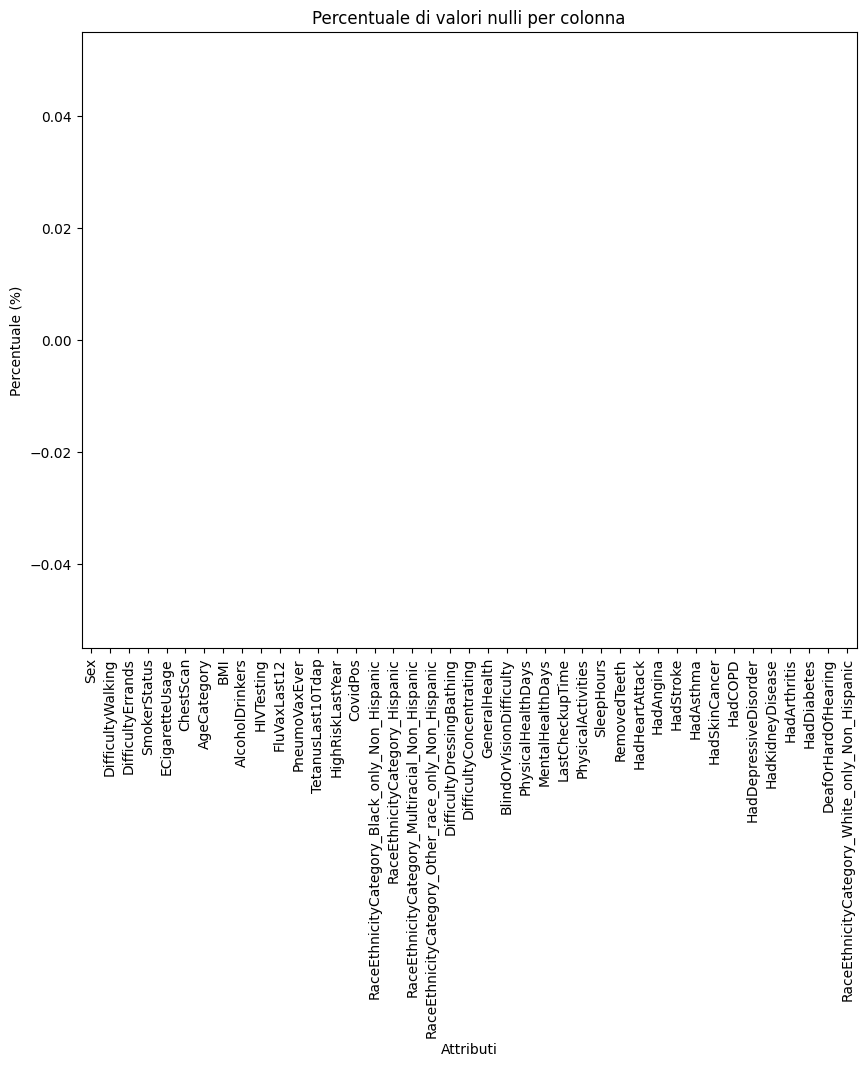

In [ ]:
X=df_imputed
percentualeNan(X)

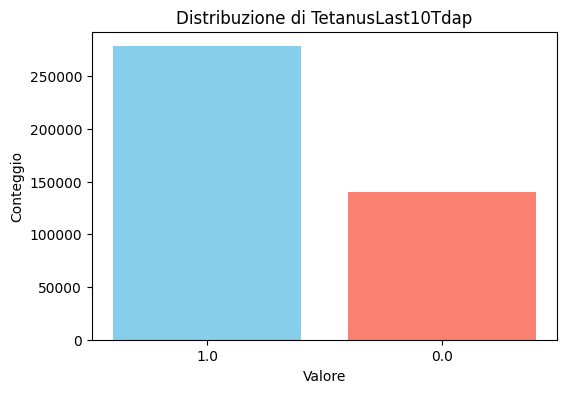

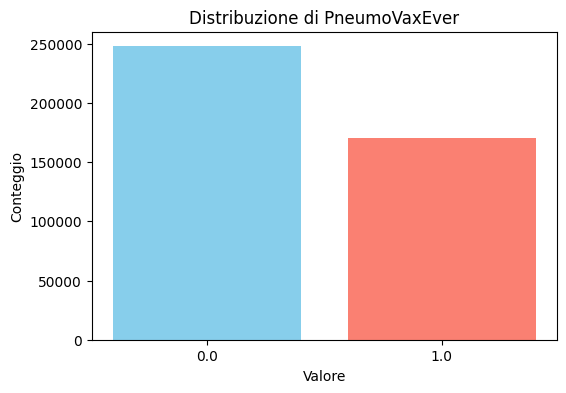

In [ ]:
# Plot della distribuzione di TetanusLast10Tdap prima dell'imputazione
plot_binary_distribution('TetanusLast10Tdap',X)

# Plot della distribuzione di PneumoVaxEver prima dell'imputazione
plot_binary_distribution('PneumoVaxEver',X)

Come possiamo notare le distribuzioni dei dati prima e dopo essere imputati possiedono esattamente la stessa distribuzione, questo ci fa pensare che abbiamo fatto un buon lavoro nell'imputazione dei dati tramite previsione.

Procediamo andando a verificare come abbiamo fatto per il dataset senza Nan, le correlazioni e la feature importance tra variabili :

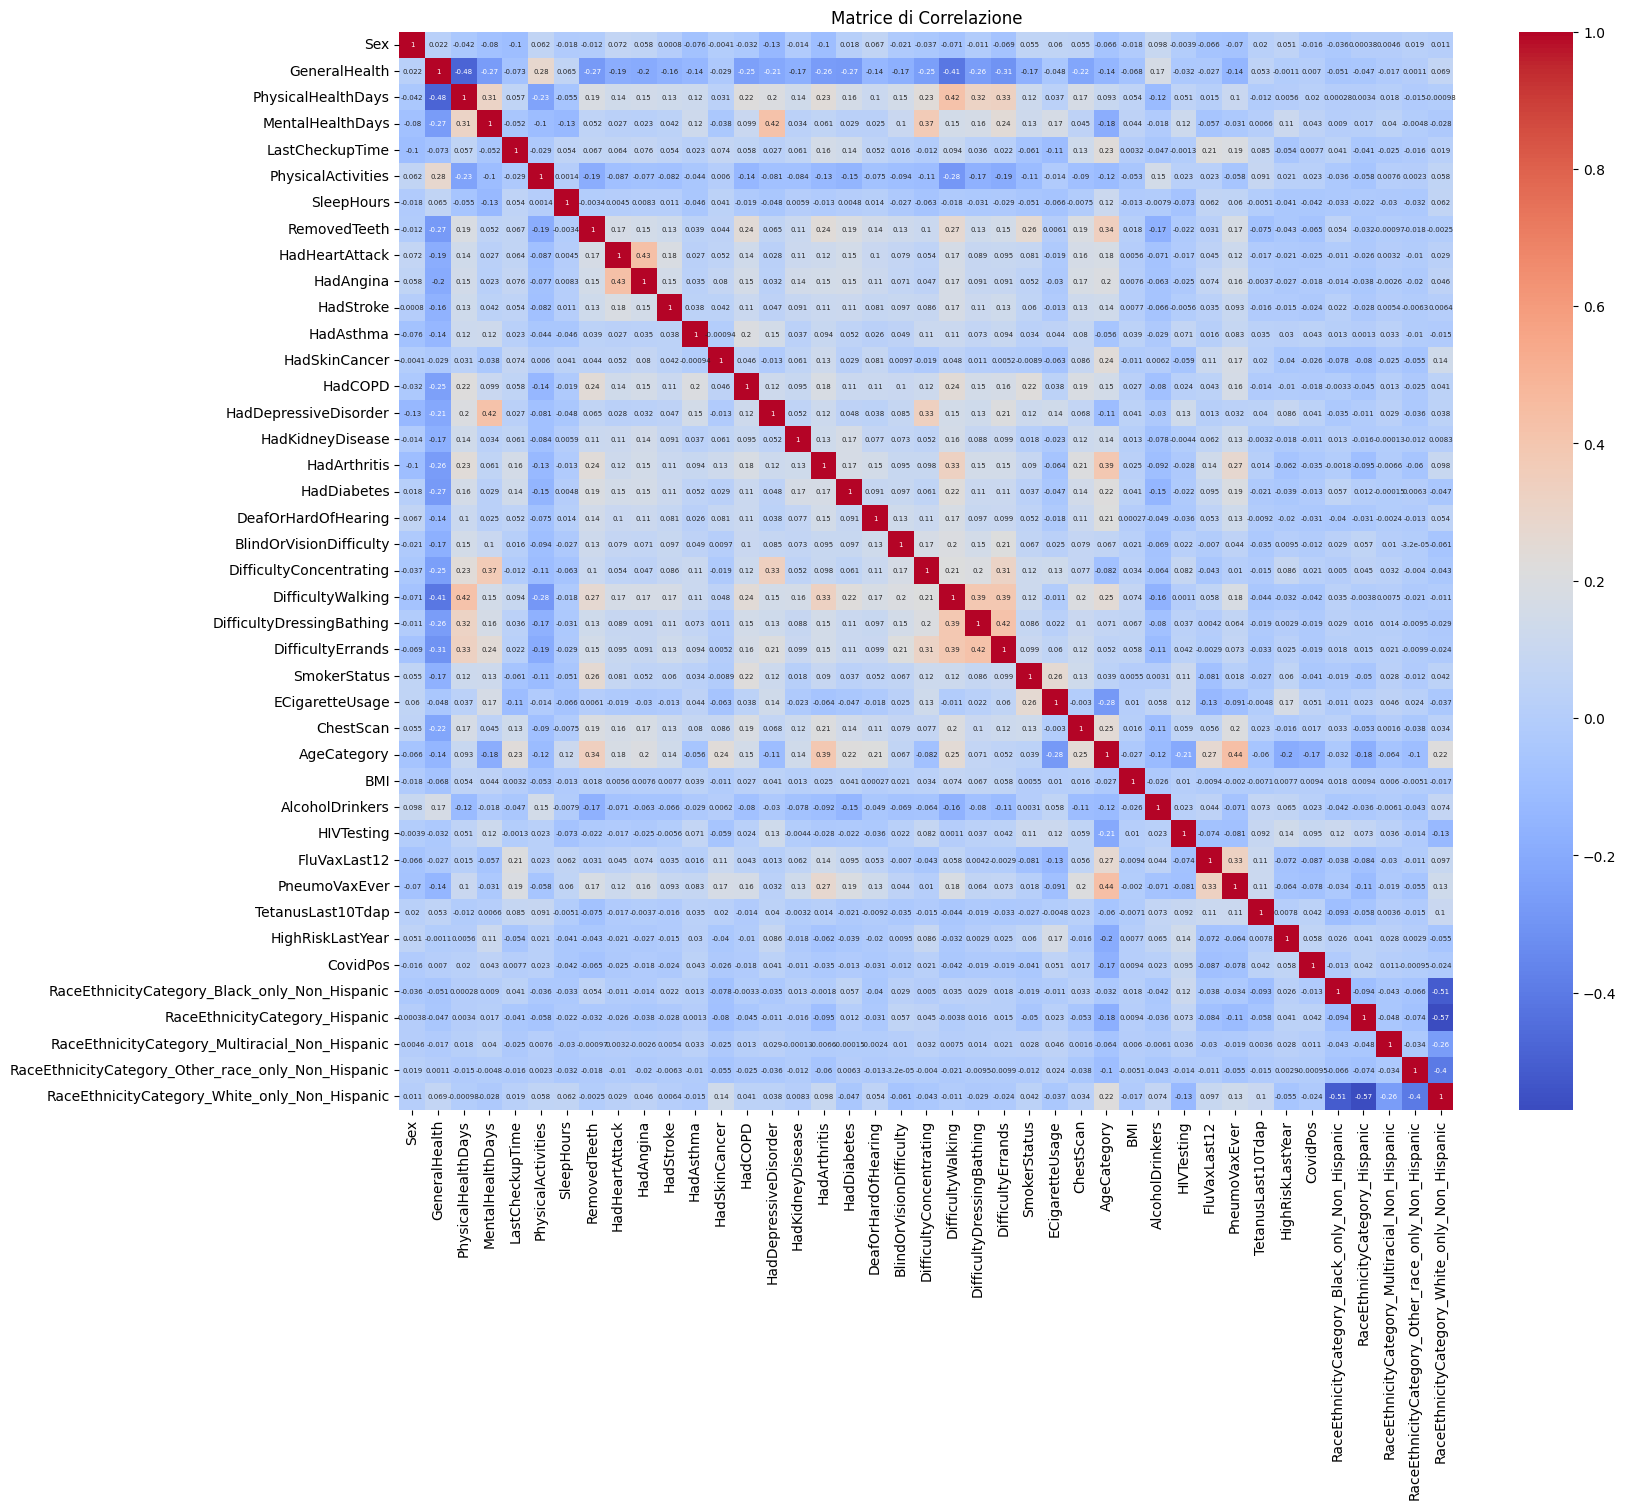

In [ ]:
numeric_columns = X.select_dtypes(include=[np.number])
corr_matrix = numeric_columns.corr(method='pearson')

# Imposta le dimensioni del grafico e le proprietà delle annotazioni
plt.figure(figsize=(17, 14))  # Imposta le dimensioni del grafico
sns.heatmap(corr_matrix, annot=True, annot_kws={"size": 5}, cmap='coolwarm')

# Aggiungi titolo e visualizza il grafico
plt.title('Matrice di Correlazione')
plt.show()

In [ ]:
corr_matrix['HadHeartAttack'].sort_values(ascending=False)

HadHeartAttack                                        1.000000
HadAngina                                             0.430901
HadStroke                                             0.184878
AgeCategory                                           0.177092
RemovedTeeth                                          0.166535
DifficultyWalking                                     0.165582
ChestScan                                             0.159832
HadDiabetes                                           0.149090
HadCOPD                                               0.141065
PhysicalHealthDays                                    0.137228
HadArthritis                                          0.123473
PneumoVaxEver                                         0.121857
HadKidneyDisease                                      0.114334
DeafOrHardOfHearing                                   0.103468
DifficultyErrands                                     0.094943
DifficultyDressingBathing                             0

##Feature importance con RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# df: il dataframe completo

# Separa le caratteristiche (X) e la variabile target (Y)
y = X['HadHeartAttack']
X = X.drop(columns=['HadHeartAttack'])


# Inizializza il RandomForestClassifier
rnd_clf = RandomForestClassifier(random_state=42)

# Addestra il modello
rnd_clf.fit(X, y)

# Crea una serie con le importanze delle caratteristiche
feat_importancesRF = pd.Series(rnd_clf.feature_importances_, index=X.columns)

# Ordina le caratteristiche in base all'importanza
feat_importancesRF = feat_importancesRF.sort_values(ascending=False)
print(feat_importancesRF)

HadAngina                                             0.144705
SleepHours                                            0.075912
AgeCategory                                           0.073625
PhysicalHealthDays                                    0.055786
GeneralHealth                                         0.045660
RemovedTeeth                                          0.044400
MentalHealthDays                                      0.044027
SmokerStatus                                          0.033655
TetanusLast10Tdap                                     0.025160
FluVaxLast12                                          0.023193
ECigaretteUsage                                       0.022954
AlcoholDrinkers                                       0.022623
HadStroke                                             0.021989
CovidPos                                              0.021910
HadArthritis                                          0.021670
HadDiabetes                                           0

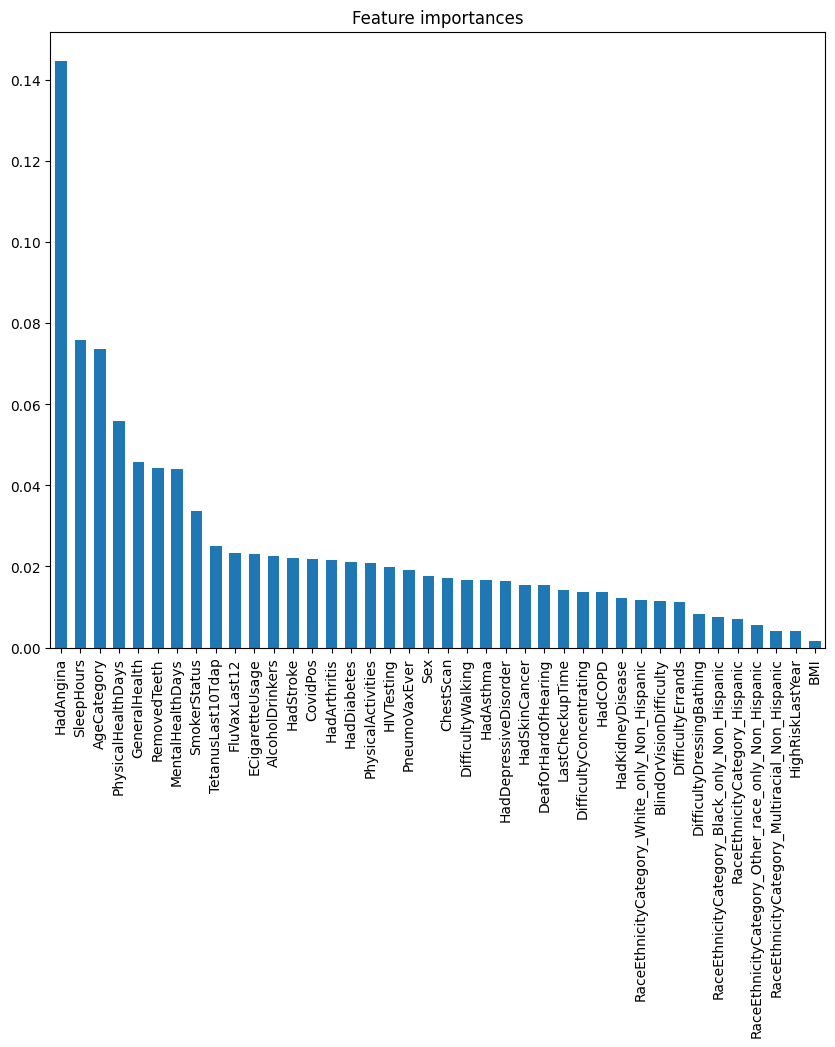

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))  # Opzionale: aumenta le dimensioni della figura

# Aumenta la grandezza delle barre
feat_importancesRF.plot.bar(ax=ax, width=0.6)

ax.set_title("Feature importances")

# Mostra il grafico
plt.show()

Nonostante la somiglianza generale, abbiamo riscontrato alcune discrepanze significative tra il primo task condotto depurando il dataset da valori Nan e questo. Ad esempio, il BMI, che in precedenza era tra le feature più importanti, ora si trova all’ultimo posto per importanza. Inoltre, abbiamo osservato piccole variazioni nella rilevanza di altre feature. Queste differenze indicano che il metodo di gestione dei valori mancanti può influenzare l’analisi e l’interpretazione dei dati, sottolineando l’importanza di una scelta accurata del metodo di imputazione.

Consideriamo nuovamente le prime 21 feature per importanza

In [ ]:
columns_to_drop = ['BMI',
                   'ChestScan',
                   'HadAsthma',
                   'HadDepressiveDisorder',
                   'HadSkinCancer',
                   'DeafOrHardOfHearing',
                   'DifficultyWalking',
                   'HadCOPD',
                   'LastCheckupTime',
                   'DifficultyConcentrating',
                   'HadKidneyDisease',
                   'RaceEthnicityCategory_White_only_Non_Hispanic',
                   'BlindOrVisionDifficulty',
                   'DifficultyErrands',
                   'RaceEthnicityCategory_Black_only_Non_Hispanic',
                   'DifficultyDressingBathing',
                   'RaceEthnicityCategory_Hispanic',
                   'RaceEthnicityCategory_Other_race_only_Non_Hispanic',
                   'HighRiskLastYear',
                   'RaceEthnicityCategory_Multiracial_Non_Hispanic']

X = X.drop(columns= columns_to_drop)

X.head()

Sex  GeneralHealth  PhysicalHealthDays  MentalHealthDays  \
0    0            3.0                 0.0               0.0   
1    0            4.0                 0.0               0.0   
2    0            3.0                 2.0               3.0   
3    0            4.0                 0.0               0.0   
4    0            1.0                 2.0               0.0   

   PhysicalActivities  SleepHours  RemovedTeeth  HadAngina  HadStroke  \
0                   0         8.0           0.0          0          0   
1                   0         6.0           0.0          0          0   
2                   1         5.0           0.0          0          0   
3                   1         7.0           0.0          0          0   
4                   1         9.0           0.0          0          0   

   HadArthritis  HadDiabetes  SmokerStatus  ECigaretteUsage  AgeCategory  \
0             0          2.0           0.0              1.0         12.0   
1             0          0.0           0.0              0.0         12.0   
2             0          0.0           0.0              0.0          7.0   
3             1          0.0           2.0              0.0          9.0   
4             0          0.0           0.0              0.0          4.0   

   AlcoholDrinkers  HIVTesting  FluVaxLast12  PneumoVaxEver  \
0                0           0             1            0.0   
1                0           0             0            0.0   
2                0           0             0            0.0   
3                0           0             1            1.0   
4                1           0             0            1.0   

   TetanusLast10Tdap  CovidPos  
0                1.0         0  
1                0.0         0  
2                1.0         1  
3                0.0         0  
4                0.0         0

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_train.shape

(313698, 20)

In [ ]:
X_test.shape

(104567, 20)

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 313698 entries, 135348 to 121958
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Sex                 313698 non-null  int64  
 1   GeneralHealth       313698 non-null  float64
 2   PhysicalHealthDays  313698 non-null  float64
 3   MentalHealthDays    313698 non-null  float64
 4   PhysicalActivities  313698 non-null  int64  
 5   SleepHours          313698 non-null  float64
 6   RemovedTeeth        313698 non-null  float64
 7   HadAngina           313698 non-null  int64  
 8   HadStroke           313698 non-null  int64  
 9   HadArthritis        313698 non-null  int64  
 10  HadDiabetes         313698 non-null  float64
 11  SmokerStatus        313698 non-null  float64
 12  ECigaretteUsage     313698 non-null  float64
 13  AgeCategory         313698 non-null  float64
 14  AlcoholDrinkers     313698 non-null  int64  
 15  HIVTesting          313698 non-nul

In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 104567 entries, 103186 to 1486
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Sex                 104567 non-null  int64  
 1   GeneralHealth       104567 non-null  float64
 2   PhysicalHealthDays  104567 non-null  float64
 3   MentalHealthDays    104567 non-null  float64
 4   PhysicalActivities  104567 non-null  int64  
 5   SleepHours          104567 non-null  float64
 6   RemovedTeeth        104567 non-null  float64
 7   HadAngina           104567 non-null  int64  
 8   HadStroke           104567 non-null  int64  
 9   HadArthritis        104567 non-null  int64  
 10  HadDiabetes         104567 non-null  float64
 11  SmokerStatus        104567 non-null  float64
 12  ECigaretteUsage     104567 non-null  float64
 13  AgeCategory         104567 non-null  float64
 14  AlcoholDrinkers     104567 non-null  int64  
 15  HIVTesting          104567 non-null 

Ora che abbiamo completato la fase di preprocessing dei dati, siamo pronti per passare alla fase successiva: il calcolo dei modelli. Con i dati puliti, trasformati e pronti all'uso, siamo in grado di iniziare a costruire e valutare i modelli che ci consentiranno di estrarre informazioni significative e prendere decisioni informate.

###Classificazione dataset sbilanciato

Results for weigthed Random Forest without any weights



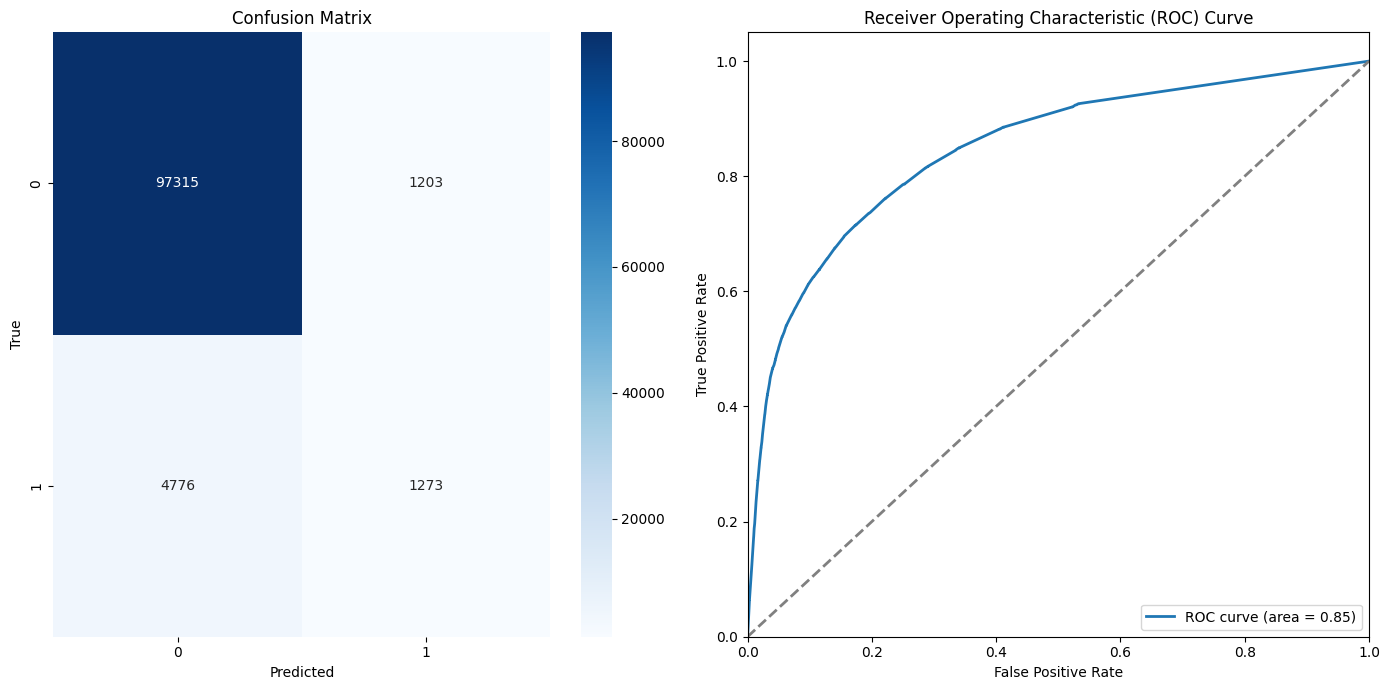

------- Sklearn Classification Report ------- 

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     98518
           1       0.51      0.21      0.30      6049

    accuracy                           0.94    104567
   macro avg       0.73      0.60      0.63    104567
weighted avg       0.93      0.94      0.93    104567



In [ ]:
forest_clf_notBalanced_2 = RandomForestClassifier(random_state = 42)
forest_clf_notBalanced_2.fit(X_train, y_train)

y_pred_notBalanced_2 = forest_clf_notBalanced_2.predict(X_test)

y_prob_notBalanced_2 = forest_clf_notBalanced_2.predict_proba(X_test)[:, 1]

#Random forest without weights
forest_clf_displayStats(forest_clf_notBalanced_2, X_train, X_test, y_train, y_test, y_pred_notBalanced_2, y_prob_notBalanced_2)

Le performance tra il datset imputato e il dataset depurato dai valori Nan risultano essere molto simili in termini di area sotto la curva ROC (AUC), F1-score e altre metriche di valutazione. In particolare, l’AUC è risultata pressoché invariata, suggerendo che la capacità del modello di distinguere tra le classi positive e negative è rimasta consistente. Anche l’F1-score, che considera sia la precisione che il recall, ha mostrato differenze minime, indicando che l’imputazione dei valori mancanti non ha alterato significativamente l’equilibrio tra falsi positivi e falsi negativi. Tuttavia, sono emerse piccole variazioni nella feature importance: ad esempio, il BMI, che nel dataset depurato risultava tra le variabili più influenti, ha perso importanza nel dataset imputato. Questi risultati suggeriscono che, sebbene l’imputazione non abbia compromesso le performance generali del modello, ha influito leggermente sulla rilevanza relativa di alcune feature. In sintesi, l’analisi conferma la robustezza del nostro classificatore, indipendentemente dal trattamento dei valori mancanti, pur evidenziando sottili differenze nella dinamica delle variabili predittive.

###Dataset bilanciato

In [ ]:
# Supponiamo che X_train e y_train siano già definiti
# Concatenare X_train e y_train per facilitare le operazioni di bilanciamento
Xy_train = pd.concat([X_train, y_train], axis=1)

# Separare le istanze per classe
X_no_heartAttack = Xy_train[Xy_train['HadHeartAttack'] == 0].drop(columns=['HadHeartAttack'])
y_no_heartAttack = Xy_train[Xy_train['HadHeartAttack'] == 0]['HadHeartAttack']
X_yes_heartAttack = Xy_train[Xy_train['HadHeartAttack'] == 1].drop(columns=['HadHeartAttack'])
y_yes_heartAttack = Xy_train[Xy_train['HadHeartAttack'] == 1]['HadHeartAttack']

# Applichiamo Tomek Links sull'intero dataset
tomek = TomekLinks(sampling_strategy='majority')
X_tomek, y_tomek = tomek.fit_resample(X_train, y_train)

In [ ]:
# Creare un nuovo DataFrame dal risultato di Tomek Links
Xy_tomek = pd.concat([X_tomek, y_tomek], axis=1)

print(Xy_tomek.shape)
Xy_tomek.head()

(310113, 21)


Sex  GeneralHealth  PhysicalHealthDays  MentalHealthDays  \
0    1            3.0                 0.0               0.0   
1    1            3.0                 5.0              10.0   
2    1            2.0                30.0               0.0   
3    0            3.0                 0.0               0.0   
4    0            3.0                 0.0               0.0   

   PhysicalActivities  SleepHours  RemovedTeeth  HadAngina  HadStroke  \
0                   1         7.0           0.0          0          0   
1                   1         6.0           0.0          0          0   
2                   1         8.0           1.0          0          0   
3                   1         8.0           0.0          0          0   
4                   1         8.0           1.0          0          0   

   HadArthritis  ...  SmokerStatus  ECigaretteUsage  AgeCategory  \
0             1  ...           0.0              0.0         12.0   
1             0  ...           1.0              0.0          3.0   
2             1  ...           1.0              0.0         11.0   
3             0  ...           1.0              0.0         10.0   
4             0  ...           1.0              0.0          7.0   

   AlcoholDrinkers  HIVTesting  FluVaxLast12  PneumoVaxEver  \
0                0           0             1            1.0   
1                1           0             0            0.0   
2                1           0             0            1.0   
3                0           0             1            0.0   
4                0           0             0            0.0   

   TetanusLast10Tdap  CovidPos  HadHeartAttack  
0                1.0         0               0  
1                0.0         0               0  
2                1.0         1               0  
3                0.0         1               0  
4                1.0         1               0  

[5 rows x 21 columns]

In [ ]:
# Separare le istanze dopo Tomek Links
Xy_tomek_HHA_no = Xy_tomek[Xy_tomek['HadHeartAttack'] == 0]
Xy_tomek_HHA_yes = Xy_tomek[Xy_tomek['HadHeartAttack'] == 1]

# Downsampling delle istanze "no" nel training set
Xy_no_heartAttack_downsampled = resample(Xy_tomek_HHA_no,
                                         replace=False,
                                         n_samples=20000,
                                         random_state=42)

print(Xy_no_heartAttack_downsampled.shape)

Xy_heartAttack_downsampled_complete = pd.concat([Xy_no_heartAttack_downsampled, Xy_tomek_HHA_yes])
print(Xy_heartAttack_downsampled_complete.shape)

X_heartAttack_downsampled_complete = Xy_heartAttack_downsampled_complete.drop(columns=['HadHeartAttack'])
y_heartAttack_downsampled_complete = Xy_heartAttack_downsampled_complete['HadHeartAttack']

# Upsampling delle istanze "yes" nel training set
#Istanziamo SMOTE
smote = SMOTE(sampling_strategy='minority', random_state=42)

#Applichiamo SMOTE
X_upsampled_train, y_upsampled_train = smote.fit_resample(X_heartAttack_downsampled_complete, y_heartAttack_downsampled_complete)

y_upsampled_train.value_counts()

(20000, 21)
(37856, 21)


HadHeartAttack
0    20000
1    20000
Name: count, dtype: int64

In [ ]:
#Da usare:

print(X_upsampled_train.shape)
print(y_upsampled_train.shape)

(40000, 20)
(40000,)


####Random Forest Classification

In [ ]:
def compute_RndFrst_balanced (X_train, X_test, y_train, y_test):
  forest_clf = RandomForestClassifier(random_state = 42)
  forest_clf.fit(X_train, y_train)

  y_pred = forest_clf.predict(X_test)

  print(f"Results for Random Forest\n")

  #Visualizza matrice di confusione e curva ROC
  plot_confusion_matrix_and_roc(forest_clf, X_test, y_test, y_pred, forest_clf.predict_proba(X_test)[:,1])

  print("------- Sklearn Classification Report ------- \n")
  print(classification_report(y_test, y_pred))


Results for Random Forest



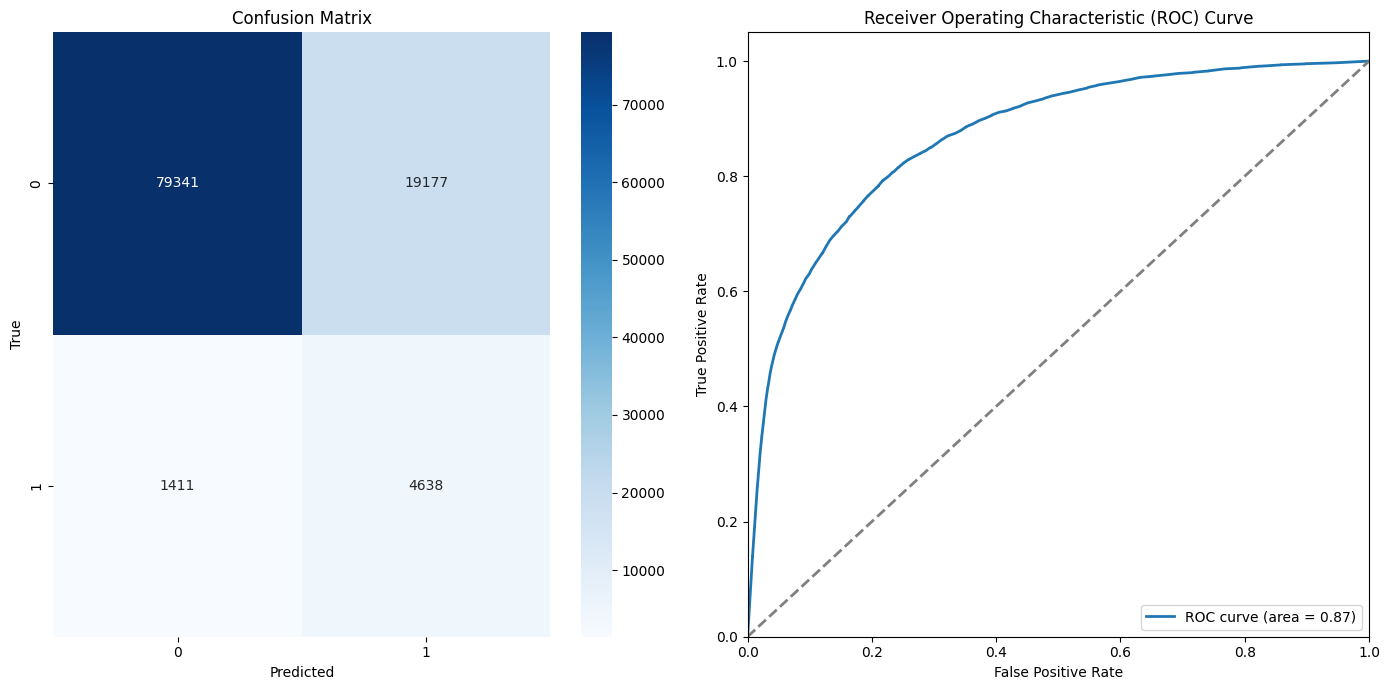

------- Sklearn Classification Report ------- 

              precision    recall  f1-score   support

           0       0.98      0.81      0.89     98518
           1       0.19      0.77      0.31      6049

    accuracy                           0.80    104567
   macro avg       0.59      0.79      0.60    104567
weighted avg       0.94      0.80      0.85    104567



In [ ]:
#Random forest classification
compute_RndFrst_balanced(X_upsampled_train, X_test, y_upsampled_train, y_test)

I modelli applicati ai due dataset (imputato e depurato) mostrano differenze nelle prestazioni, con il modello depurato che ha generalmente prestazioni migliori in termini di F1 Score Weighted e Accuracy. Tuttavia, il modello imputato mostra un recall superiore, il che potrebbe essere vantaggioso in contesti dove la cattura dei veri positivi è più critica. Questo suggerisce che, sebbene l’imputazione possa mantenere una buona performance complessiva, ci sono alcuni compromessi da considerare in termini di recall rispetto ai dataset depurati.

#### Logistic Regression Classification

In [ ]:
from sklearn.linear_model import LogisticRegression

def compute_LogRegr (X_train, X_test, y_train, y_test):
  logReg_clf = LogisticRegression(random_state = 42)
  logReg_clf.fit(X_train, y_train)

  y_pred = logReg_clf.predict(X_test)

  print(f"Results for Logistic Regression\n")

  #Visualizza matrice di confusione e curva ROC
  plot_confusion_matrix_and_roc(logReg_clf, X_test, y_test, y_pred, logReg_clf.predict_proba(X_test)[:,1])

  print("------- Sklearn Classification Report ------- \n")
  print(classification_report(y_test, y_pred))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Results for Logistic Regression



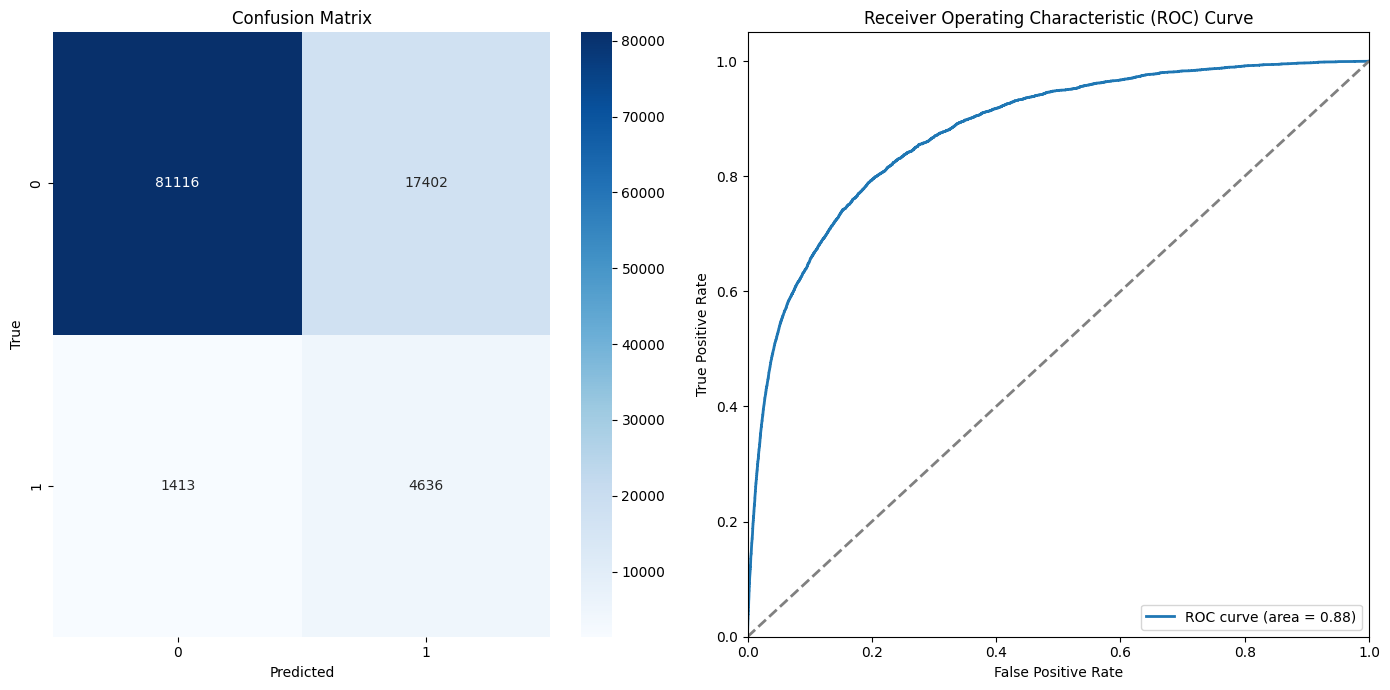

------- Sklearn Classification Report ------- 

              precision    recall  f1-score   support

           0       0.98      0.82      0.90     98518
           1       0.21      0.77      0.33      6049

    accuracy                           0.82    104567
   macro avg       0.60      0.79      0.61    104567
weighted avg       0.94      0.82      0.86    104567



In [ ]:
#Logistic Regression
compute_LogRegr(X_upsampled_train, X_test, y_upsampled_train, y_test)

I modelli applicati ai due dataset (imputato e depurato) mostrano differenze nelle prestazioni, con il modello imputato che ha generalmente prestazioni migliori in termini di F1 Score Std, F1 Score Weighted e Accuracy. Tuttavia, il modello depurato mostra un recall leggermente superiore, il che potrebbe essere vantaggioso in contesti dove la cattura dei veri positivi è più critica.

####Neural Network Classifier

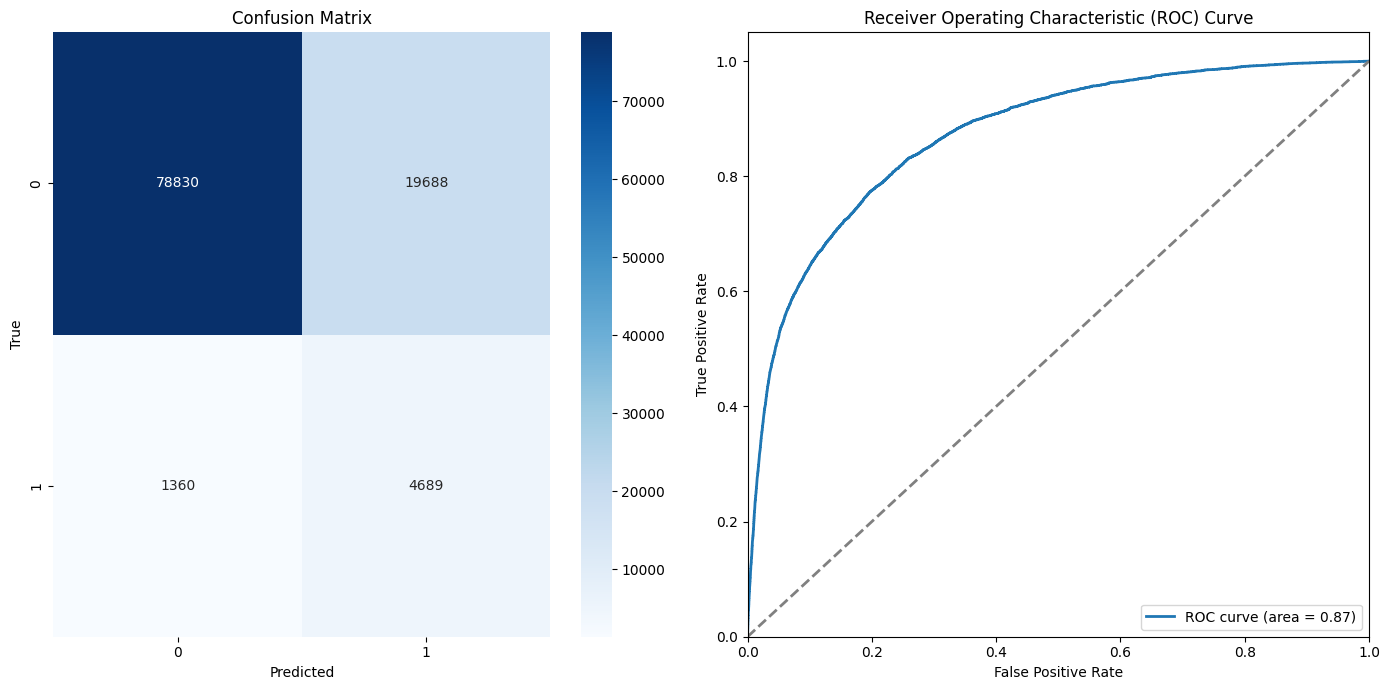

------- Sklearn Classification Report ------- 

              precision    recall  f1-score   support

           0       0.98      0.80      0.88     98518
           1       0.19      0.78      0.31      6049

    accuracy                           0.80    104567
   macro avg       0.59      0.79      0.60    104567
weighted avg       0.94      0.80      0.85    104567



In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# Normalizza i dati
scaler = StandardScaler()
X_train = scaler.fit_transform(X_upsampled_train)
X_test = scaler.transform(X_test)

# Parametri trovati dalla ricerca
best_params = {
    'activation': 'relu',
    'alpha': 0.03746600550686905,
    'hidden_layer_sizes': (100,),
    'learning_rate': 'constant',
    'solver': 'adam'
}

# Creazione del modello MLPClassifier con i parametri trovati
mlp = MLPClassifier(
    activation=best_params['activation'],
    alpha=best_params['alpha'],
    hidden_layer_sizes=best_params['hidden_layer_sizes'],
    learning_rate=best_params['learning_rate'],
    solver=best_params['solver'],
    random_state=42
)


# Addestrare il modello
mlp.fit(X_train, y_upsampled_train)

# Predizioni
y_pred = mlp.predict(X_test)

plot_confusion_matrix_and_roc(mlp, X_test, y_test, y_pred, mlp.predict_proba(X_test)[:,1])

print("------- Sklearn Classification Report ------- \n")
print(classification_report(y_test, y_pred))